In [1]:
__author__ = 'ORI'

from matplotlib.collections import LineCollection

import numpy as np
import scipy.io
import sys, os
import matplotlib.pyplot as plt
# I should learn how to load libraries in a more elegant way



sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
#reload(OriKerasExtension)
reload(ThesisHelper)
from   ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
import P300Prediction
reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
from sklearn.metrics import roc_curve, auc, roc_auc_score
import P300Prediction
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from scipy import stats
from sklearn.cross_validation import StratifiedShuffleSplit

#reload(OriKerasExtension)
reload(ThesisHelper)
from ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


# [all_target, all_non_target] = LoadSingleSubjectPython(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPfat.mat')



# all_samples = np.vstack((all_target,all_non_target))


# '''
# Create the tagging column
# '''
# all_tags = np.vstack((np.ones((all_target.shape[0],1)), np.zeros((all_non_target.shape[0],1))))



# from OriKerasExtension.OriKerasExtension import DebugLSTM
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from  keras.regularizers import WeightRegularizer

'''
define the neural network model:
'''


def create_compile_cnn_model():
    model = Sequential()

    number_of_time_stamps = 20
    number_of_out_channels = 10
    number_of_in_channels = 55
    length_of_time_axe_mask = 10

    model.add(Convolution2D(nb_filter=30,
                            nb_col=number_of_out_channels,
                            nb_row=1,
                            input_shape=(30, number_of_time_stamps, number_of_in_channels),
                            border_mode='same',
                            init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, number_of_in_channels)))
    model.add(
        Convolution2D(nb_filter=number_of_out_channels, nb_row=6, nb_col=1, border_mode='same', init='glorot_normal'))
    model.add(MaxPooling2D(pool_size=(20, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    return model

def create_compile_lstm_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()

    model_lstm.add(LSTM(input_dim=55, output_dim=20,return_sequences=True))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
    model_lstm.add(Dense(1, W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
#     model_lstm.add(Activation('softmax'))
#     model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


def create_compile_dense_model_test_sharing():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,25)))
    model_lstm.add(Dense(input_dim=55*25, output_dim=30 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(1))
#     model_lstm.add(Activation('softmax'))
#     model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm

# def down_sample_data()




Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop
from keras import backend as K

In [5]:
def contrastive_loss(y, d):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y * K.square(d) + (1 - y) * K.square(K.maximum(margin - d, 0)))

def euclidean_distance(inputs):
    assert len(inputs) == 2, ('Euclidean distance needs '
                              '2 inputs, %d given' % len(inputs))
    u, v = inputs.values()
    return K.sqrt(K.sum(K.square(u - v), axis=1, keepdims=True))

def return_shared_as_vector(inputs):
    return inputs.values()


base_network = create_compile_lstm_model()


input_dim = 100
g = Graph()
for i in range(30):
    g.add_input(name='input_{0}'.format(i), input_shape=(55,25))
# g.add_input(name='input_b', input_shape=(input_dim,))
# g.add_shared_node(base_network, name='shared', inputs=['input_a', 'input_b'],merge_mode='join')
g.add_shared_node(base_network, name='shared', inputs=['input_{0}'.format(i) for i in range(30)],merge_mode='concat')
# g.add_node(Lambda(return_shared_as_vector), name='d1', input='shared')

# g.add_node(keras.layers.normalization.BatchNormalization(), name='d3', input='shared')
g.add_node(Dense(100, activation='tanh'), name='d2', input='shared')
g.add_node(Dense(30, activation='tanh'), name='d3', input='d2')
g.add_node(Activation('softmax'), name='d4', input='d3')


g.add_output(name='output', input='d4')
rms = RMSprop()
g.compile(loss={'output': 'categorical_crossentropy'}, optimizer=rms)
original_weights = g.get_weights()

In [4]:
def create_evaluation_data(gcd_res, down_samples_param):
#     gcd_res = readCompleteMatFile(file_name)
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'], gcd_res['target'],
                                    -200, 800)
    # print  data_for_eval

    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    test_data_gcd, test_target_gcd = temp_data_for_eval[gcd_res['train_mode'] != 1], data_for_eval[1][
        gcd_res['train_mode'] != 1]
    return test_data_gcd, test_target_gcd


def downsample_data(data, number_of_original_samples, down_samples_param):


    new_number_of_time_stamps = number_of_original_samples / down_samples_param


    # print  data_for_eval
    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval


def create_train_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []
    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    positive_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 1], axis=0)]
    negative_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 0], axis=0)]
    all_positive_train.append(positive_train_data_gcd)
    all_negative_train.append(negative_train_data_gcd)

    positive_train_data_gcd = np.vstack(all_positive_train)
    negative_train_data_gcd = np.vstack(all_negative_train)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 1], axis=0)]

    all_tags = gcd_res['target'][np.all([gcd_res['train_mode'] == 1], axis=0)]
    categorical_tags = to_categorical(all_tags)

#     shuffeled_samples, suffule_tags = shuffle(all_data, categorical_tags, random_state=0)
    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags


def create_data_for_compare_by_repetition(file_name):
    gcd_res = readCompleteMatFile(file_name)
    sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
                       train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
                       stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])
    return sub_gcd_res

#shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=5)
# shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=20)
# model = create_compile_dense_model_test_sharing()
# model_mlp = create_compile_dense_model()
# original_weights = model.get_weights()
# original_weights_mlp = model_mlp.get_weights()

data_set_locations = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];

# data_set_locations = ["RSVP_Color116msVPgcd.mat"]

# results = []

# for subject_name in data_set_locations:
#     file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
#     gcd_res = readCompleteMatFile(file_name)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')


In [64]:
gcd_res = readCompleteMatFile(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPicr.mat')
print gcd_res

{'train_block': array([ 1,  1,  1, ..., 10, 10, 10], dtype=uint8), 'marker_positions': array([  2641,   2665,   2688, ..., 585779, 585802, 585826]), 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), 'stimulus': array([30, 24, 23, ..., 23,  2, 12], dtype=uint8), 'train_mode': array([ 1.,  1.,  1., ...,  3.,  3.,  3.]), 'channels_names': [u'F7', u'F5', u'F3', u'F1', u'Fz', u'F2', u'F4', u'F6', u'F8', u'FC5', u'FC3', u'FC1', u'FCz', u'FC2', u'FC4', u'FC6', u'T7', u'C5', u'C3', u'C1', u'Cz', u'C2', u'C4', u'C6', u'T8', u'TP7', u'CP5', u'CP3', u'CP1', u'CPz', u'CP2', u'CP4', u'CP6', u'TP8', u'P9', u'P7', u'P5', u'P3', u'P1', u'Pz', u'P2', u'P4', u'P6', u'P8', u'P10', u'PO9', u'PO7', u'PO3', u'POz', u'PO4', u'PO8', u'PO10', u'O1', u'Oz', u'O2'], 'train_trial': array([ 1,  1,  1, ..., 62, 62, 62], dtype=uint8), 'all_relevant_channels': [array([    7,    45,   139, ..., -4278, -4171, -3982], dtype=int16), array([    6,    34,   107, ..., -4189, -4090, -3903], dtype=int16), array([    6,  

(18600L, 200L, 55L)
(7200L, 25L, 55L)
(240L, 30L, 25L, 55L)
(25L, 55L)
train input size (7200L, 25L, 55L)
--------------
(220L, 30L)
--------------
Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.5556 - val_loss: 3.2331


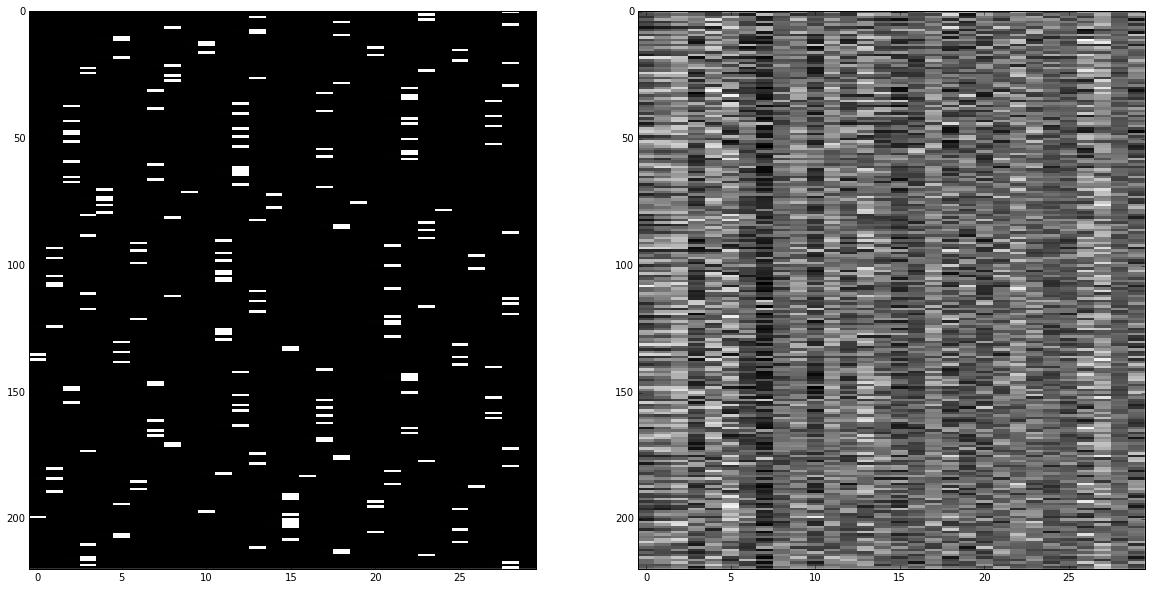

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.4573 - val_loss: 3.3075


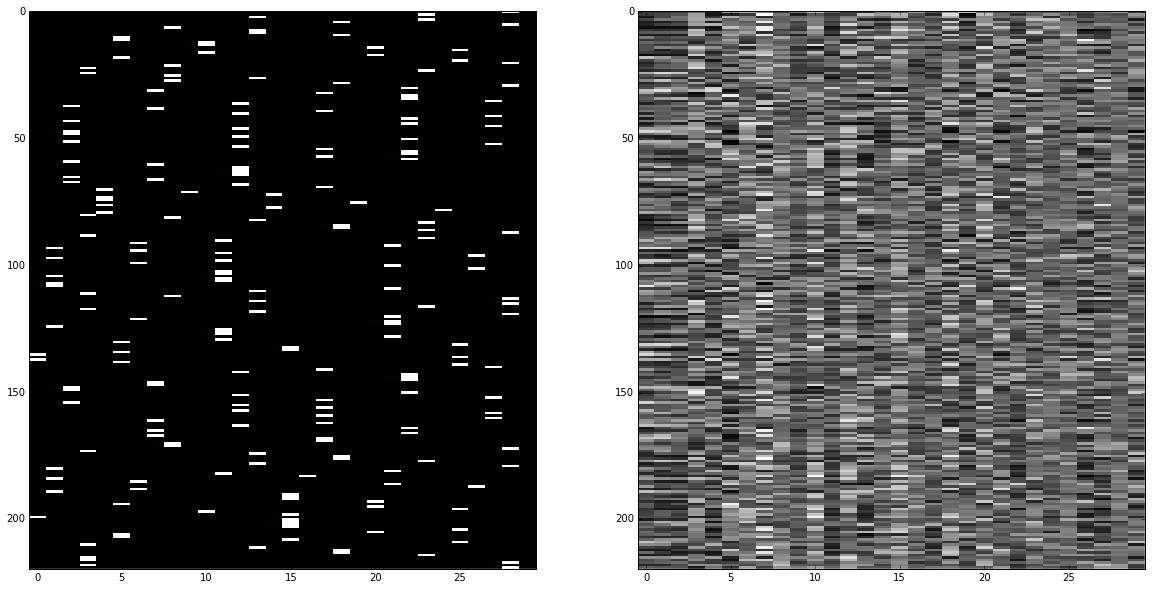

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.3963 - val_loss: 3.2280


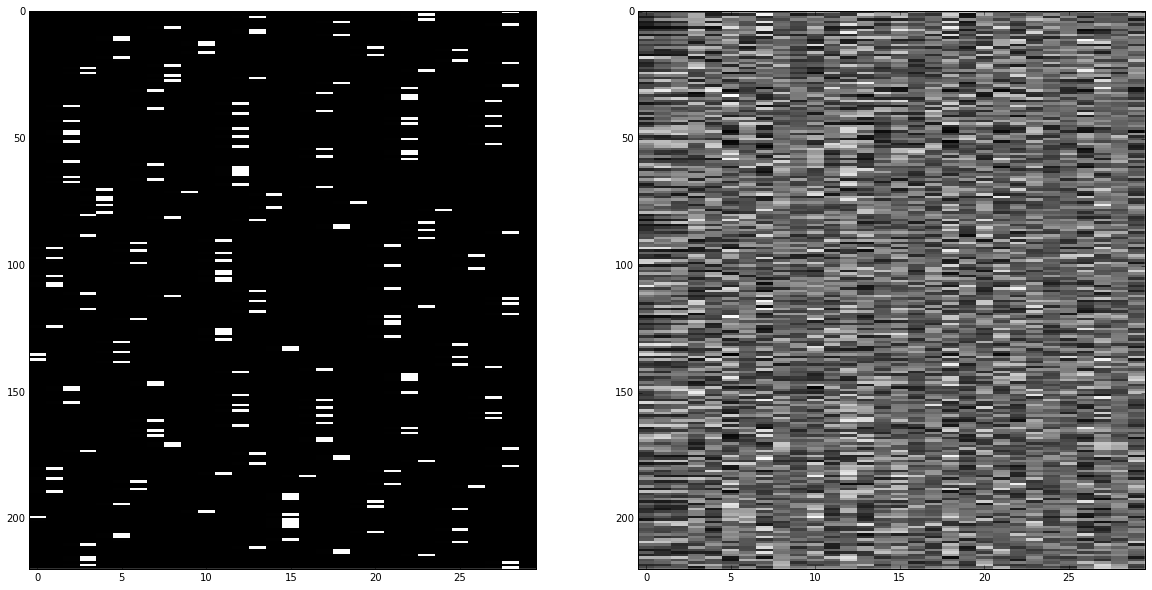

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.3253 - val_loss: 3.2146


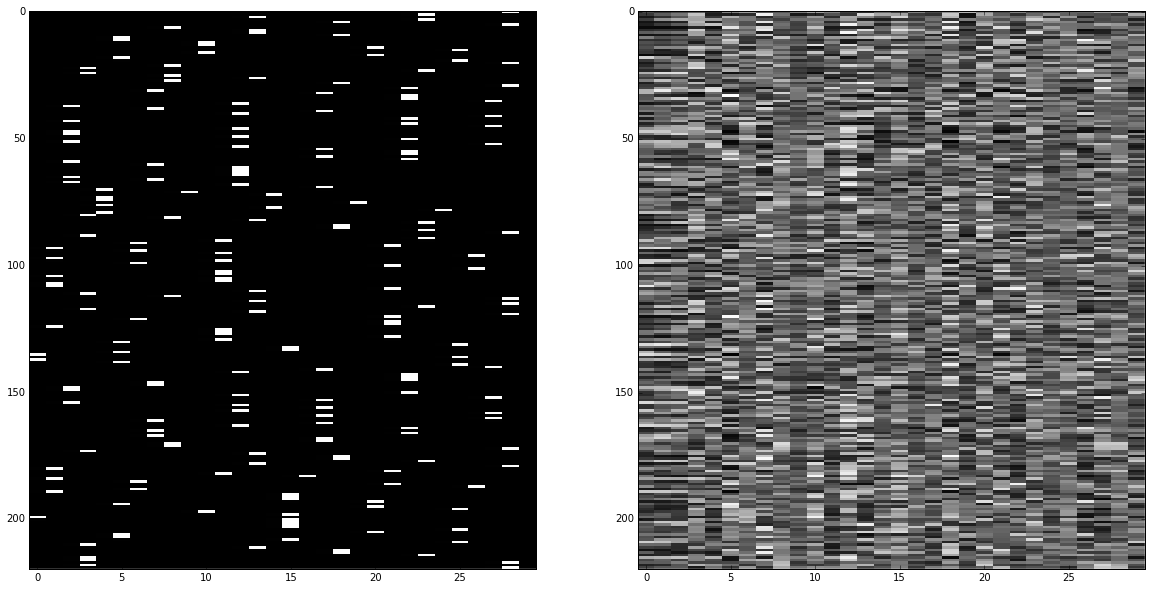

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.2589 - val_loss: 3.2204


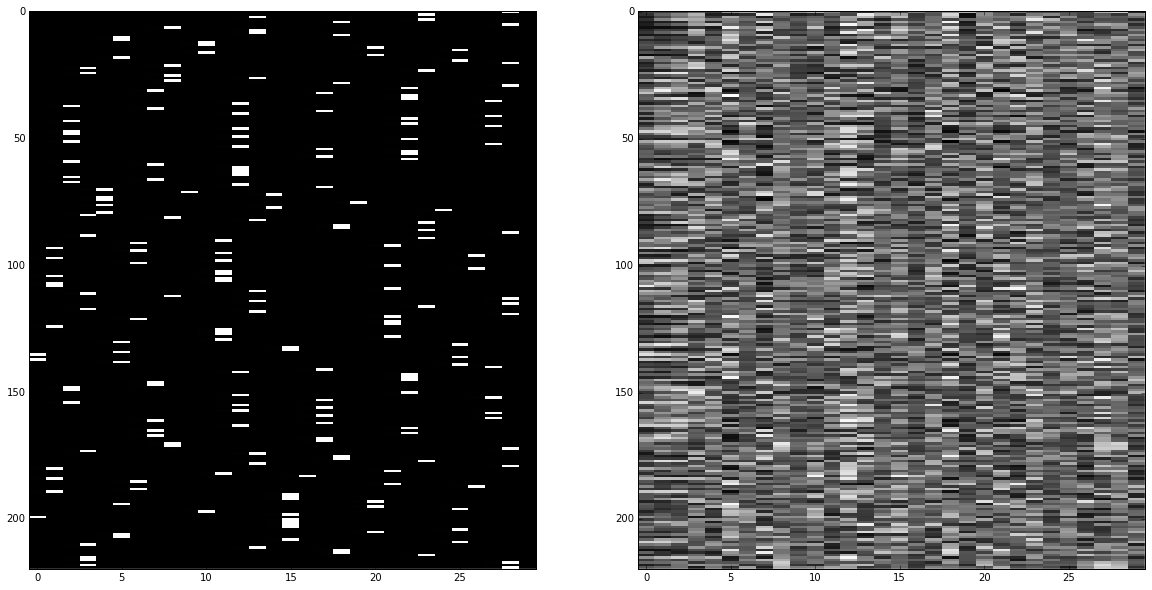

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.1969 - val_loss: 3.1435


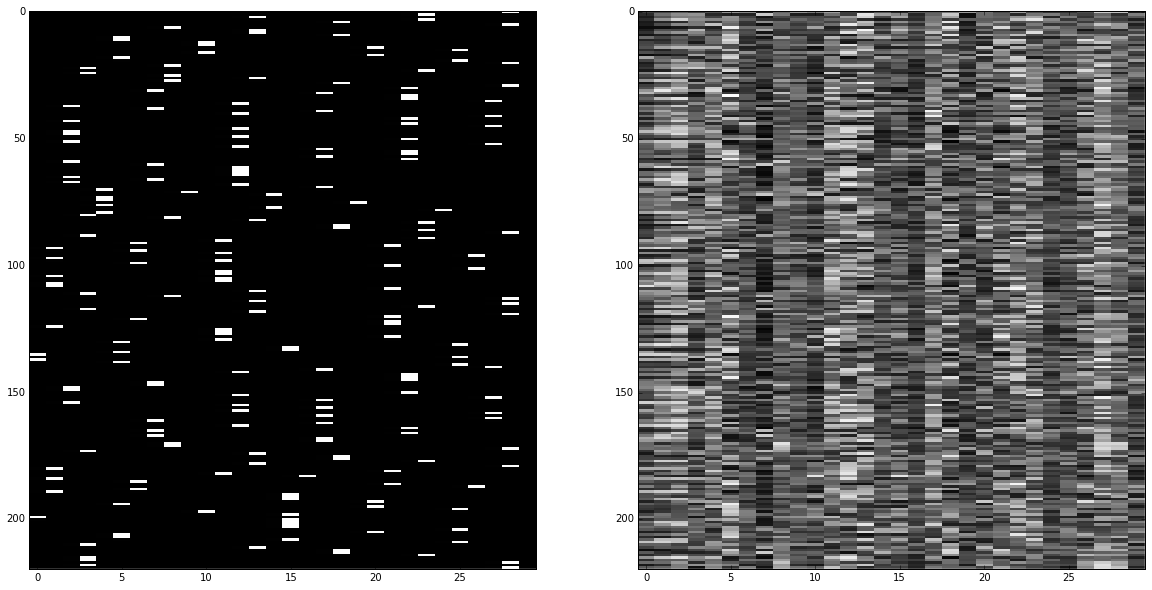

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.1635 - val_loss: 3.0855


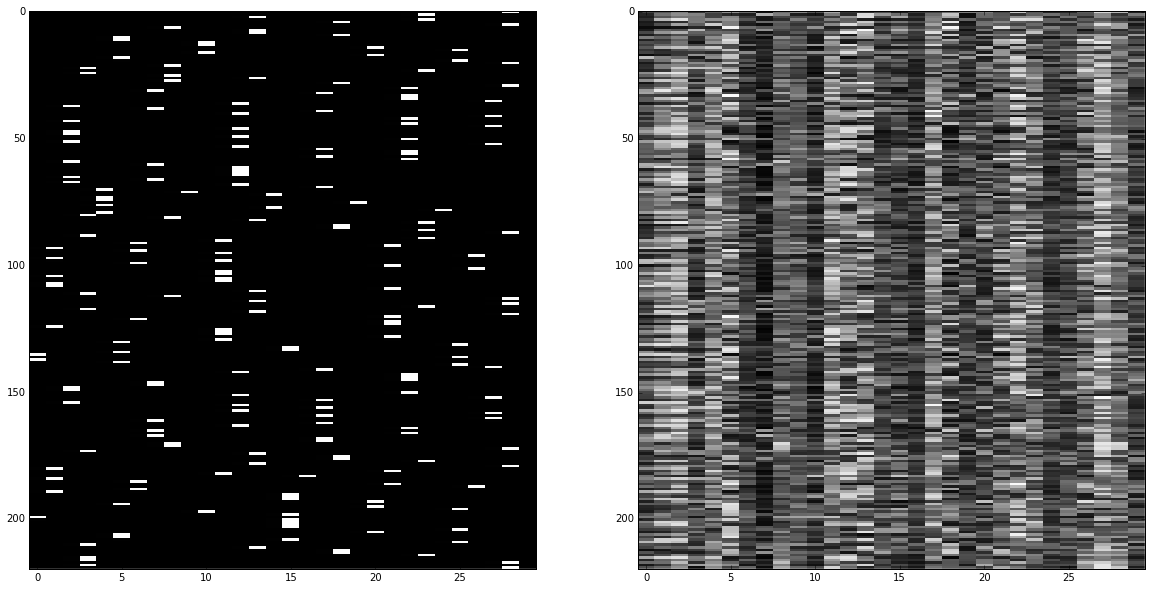

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.1256 - val_loss: 3.1263


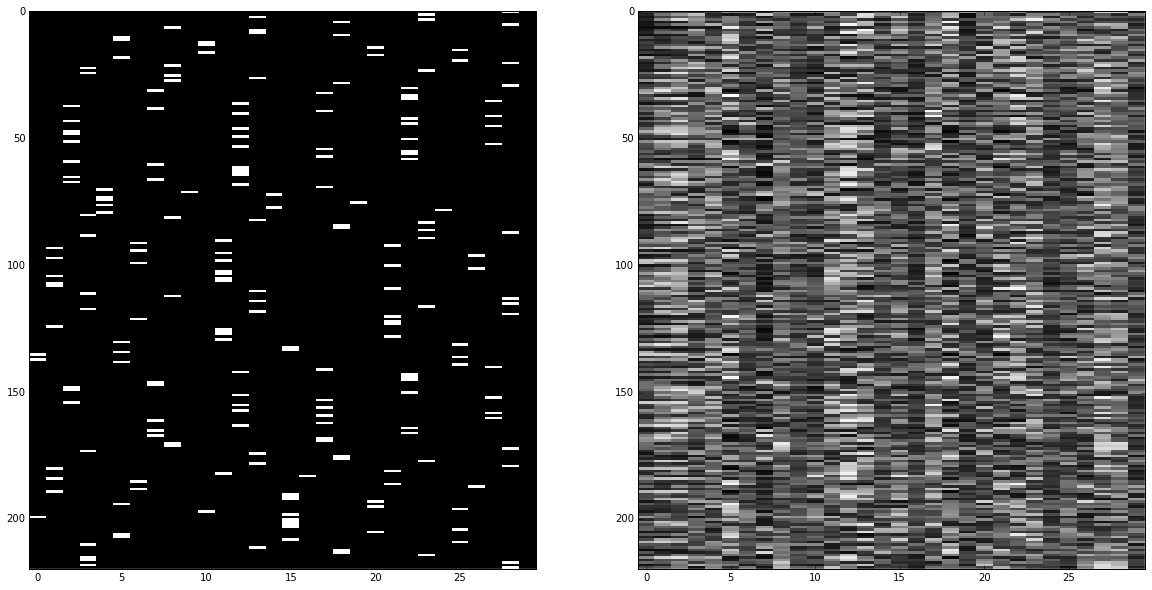

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 3.0448 - val_loss: 3.1301


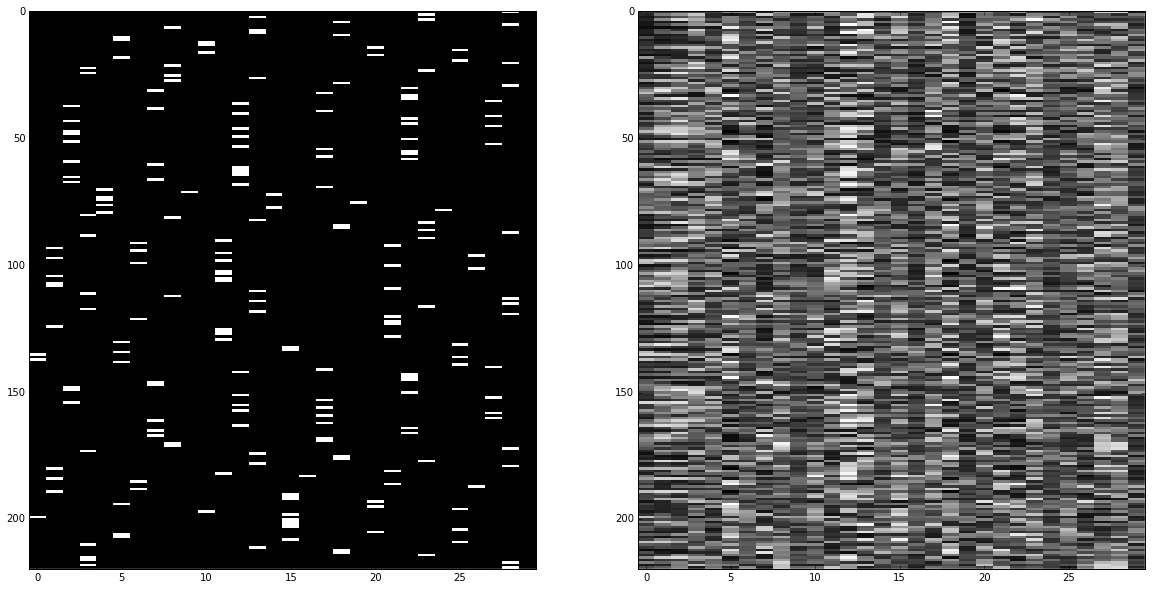

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.9945 - val_loss: 3.0807


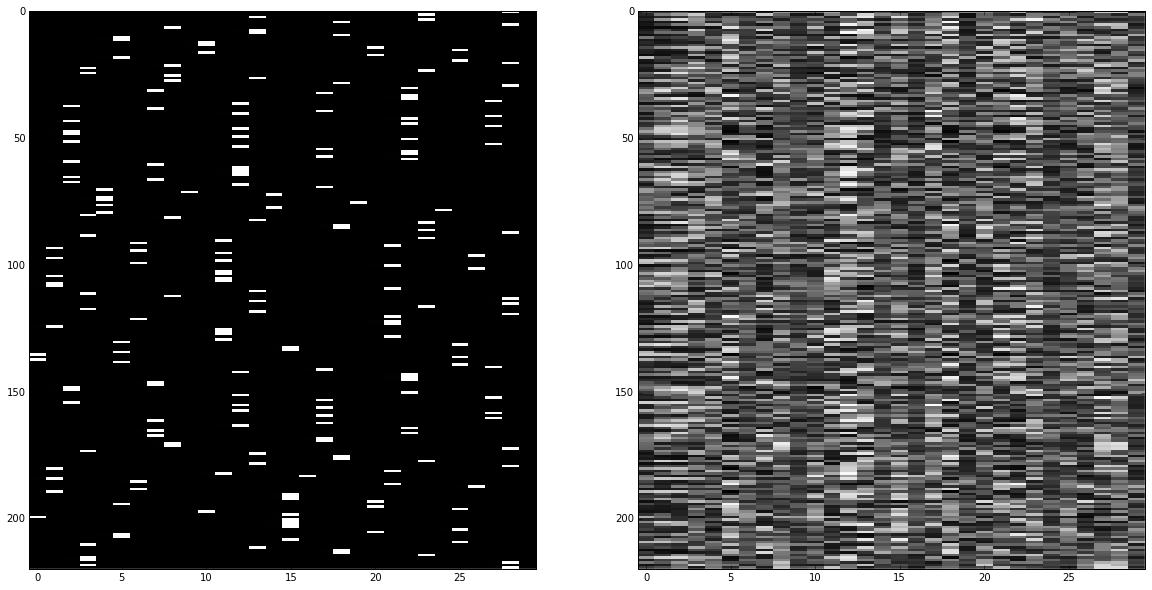

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.9508 - val_loss: 3.0455


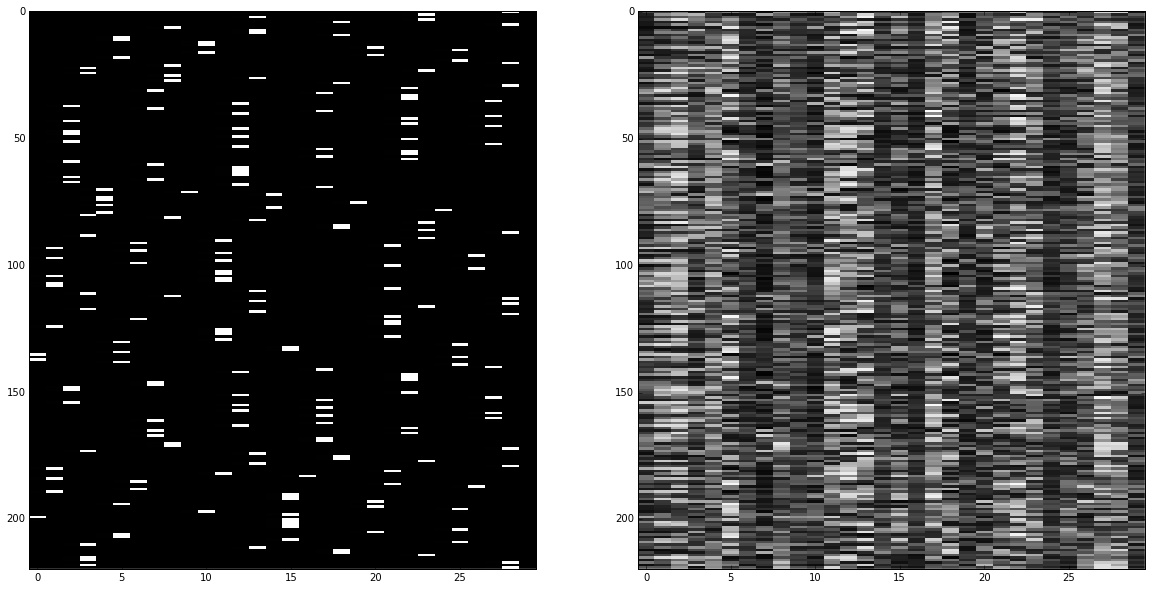

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.9418 - val_loss: 3.0152


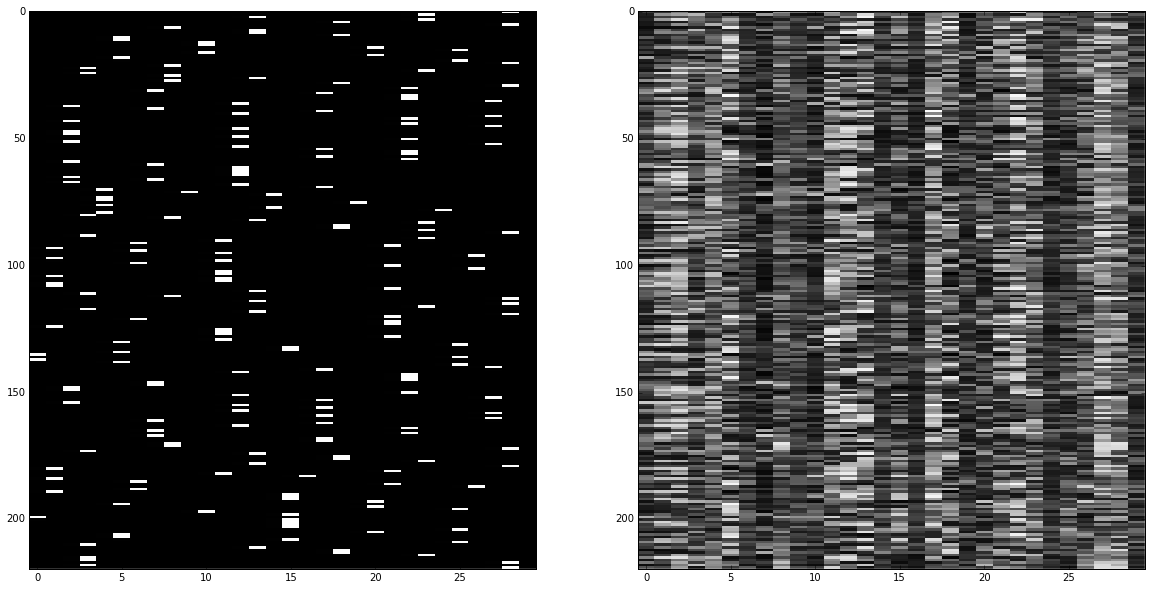

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.8976 - val_loss: 3.0299


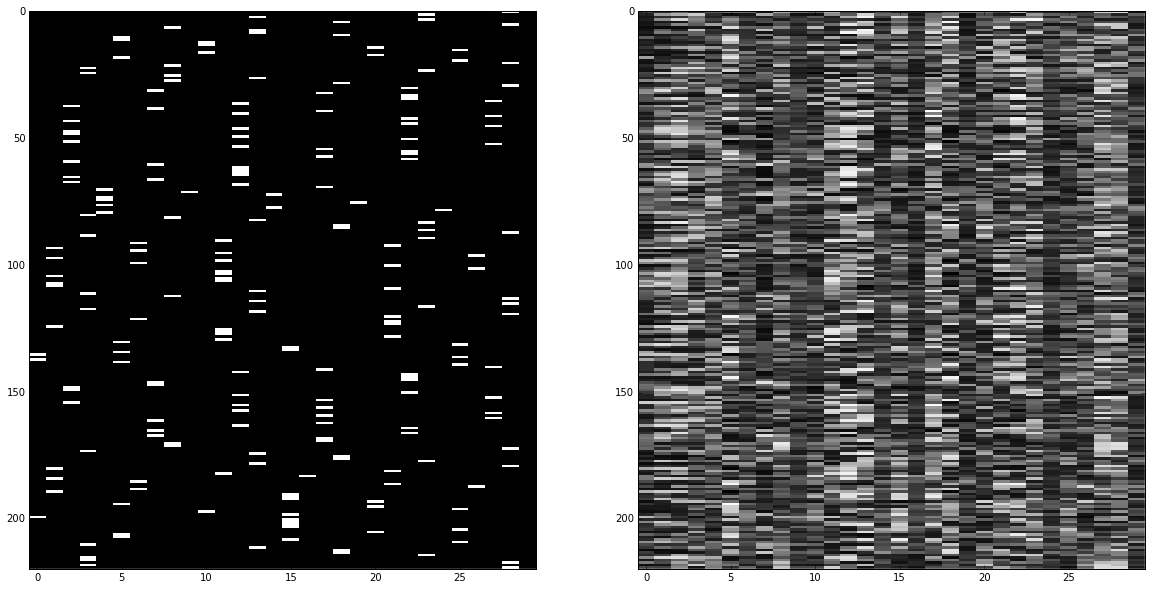

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.8561 - val_loss: 2.9797


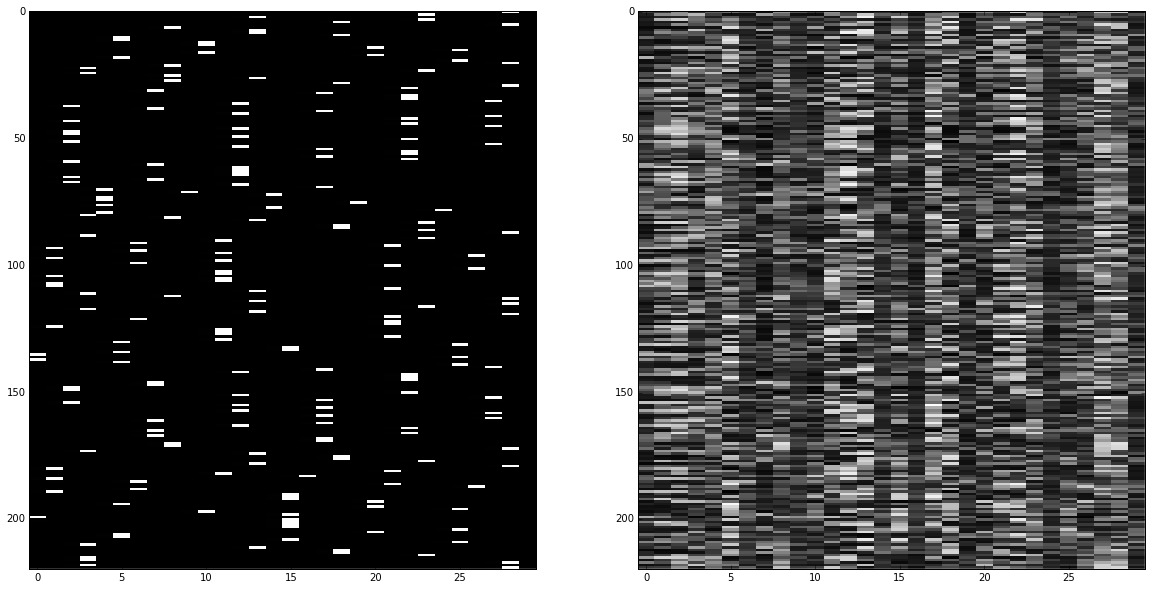

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.8531 - val_loss: 2.9806


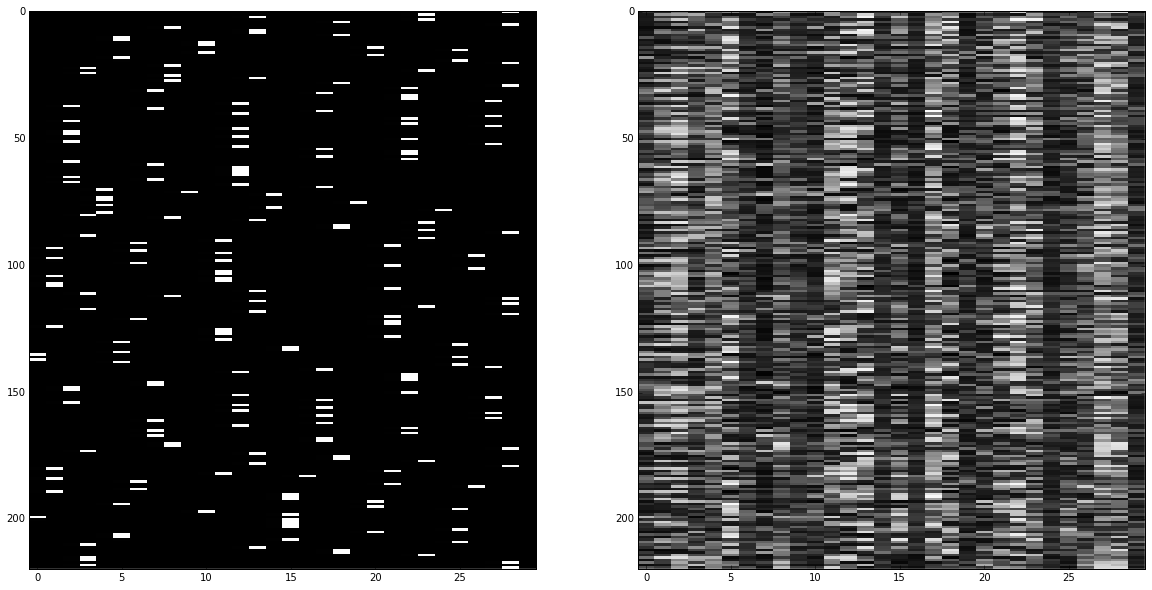

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.8414 - val_loss: 2.9800


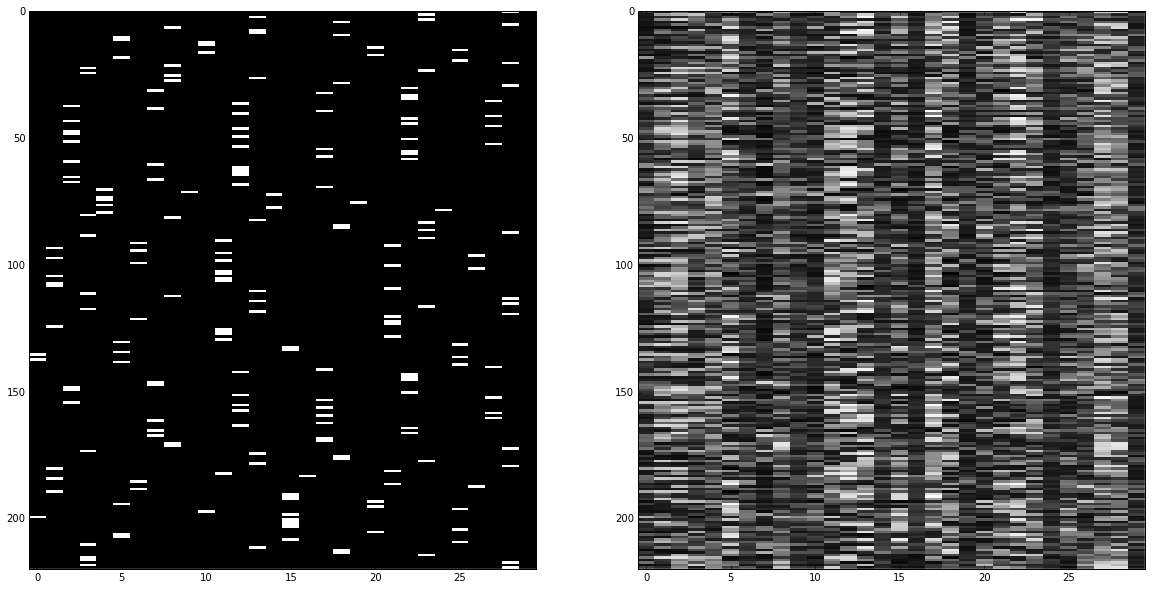

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.7788 - val_loss: 3.0012


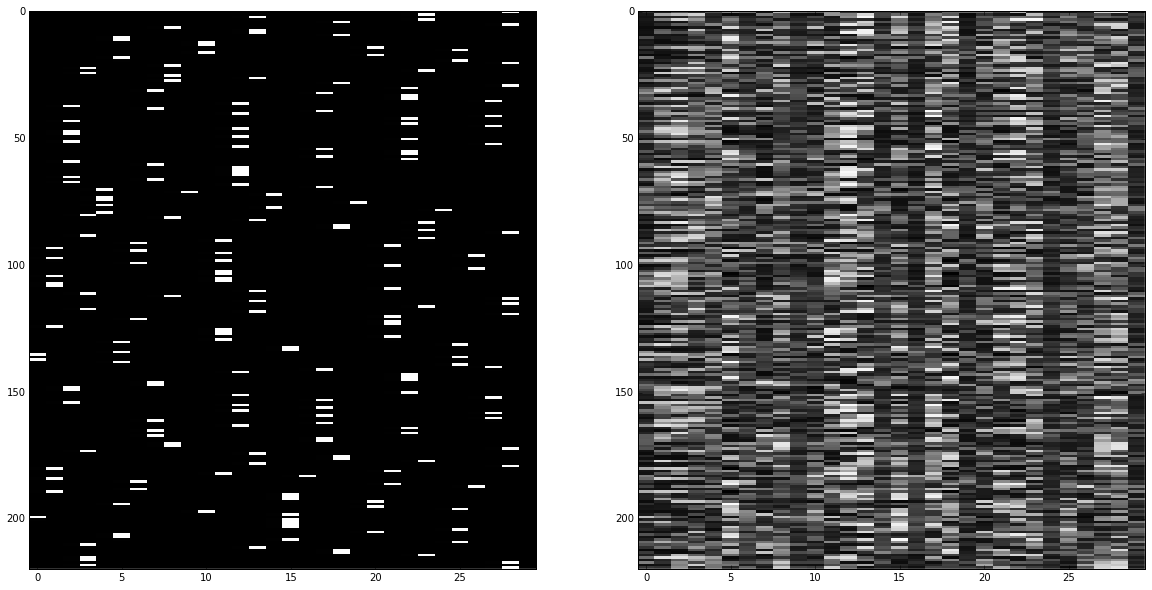

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.7394 - val_loss: 2.9911


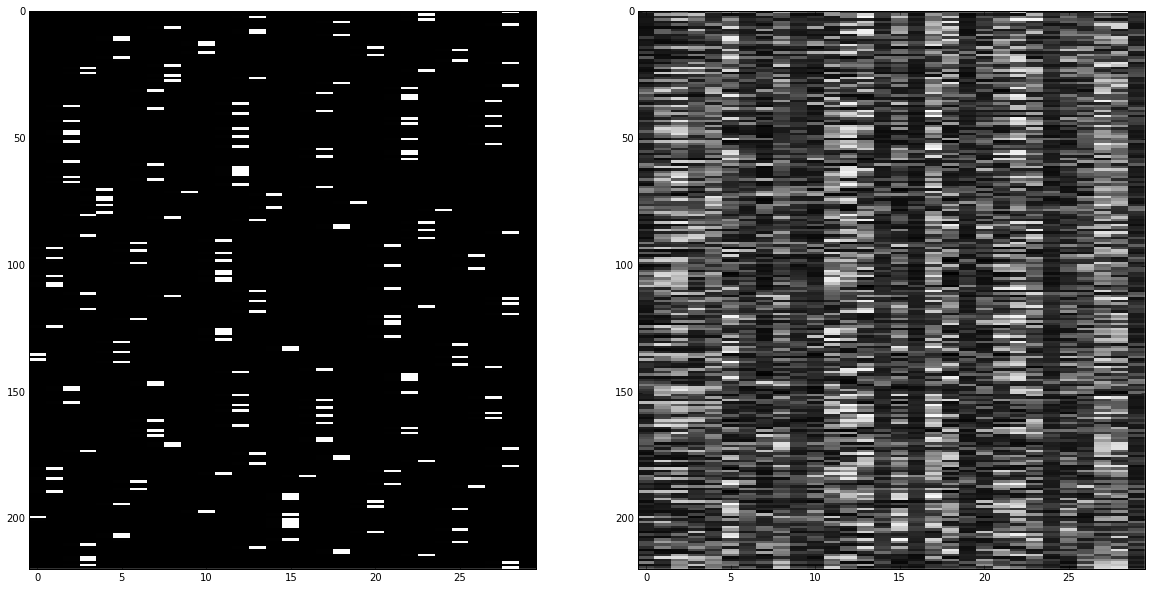

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.7334 - val_loss: 2.9568


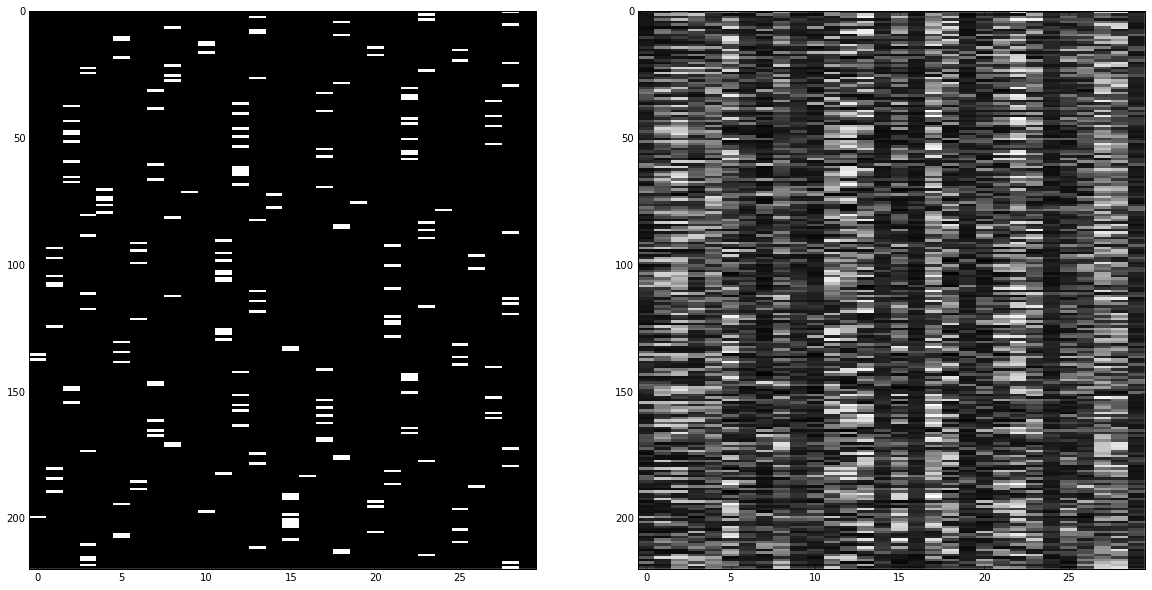

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.7434 - val_loss: 2.9220


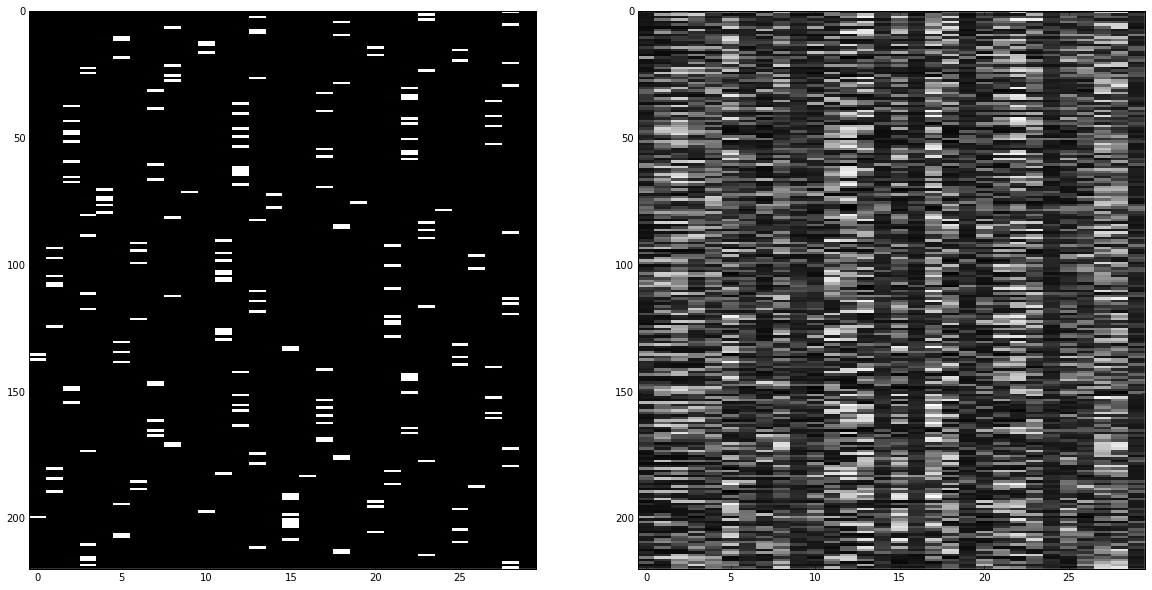

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.6892 - val_loss: 2.9623


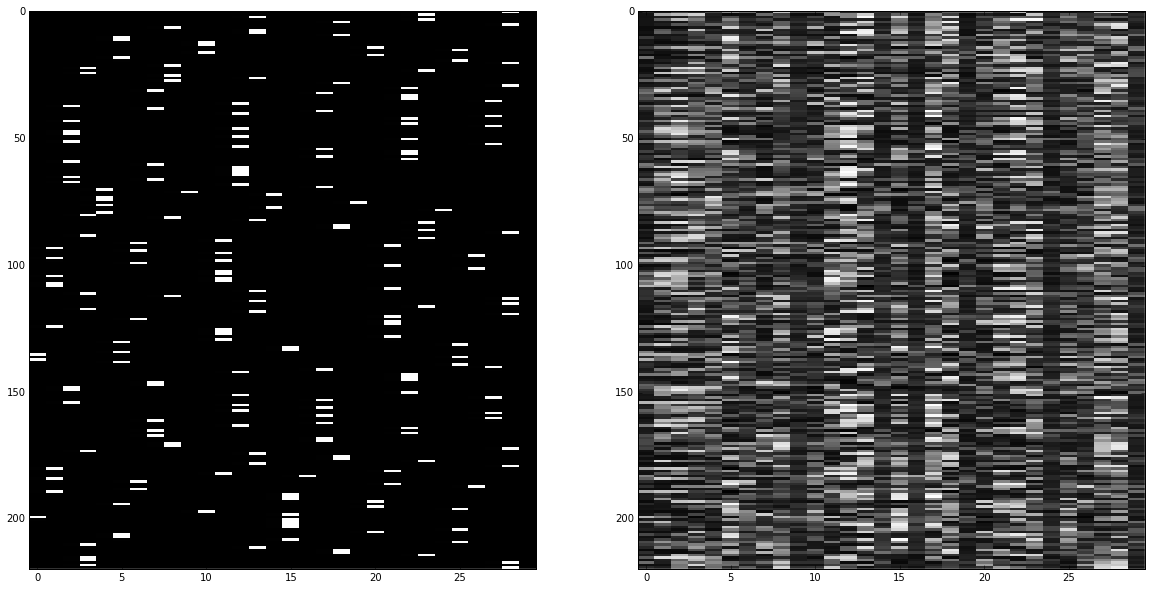

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.6426 - val_loss: 2.9925


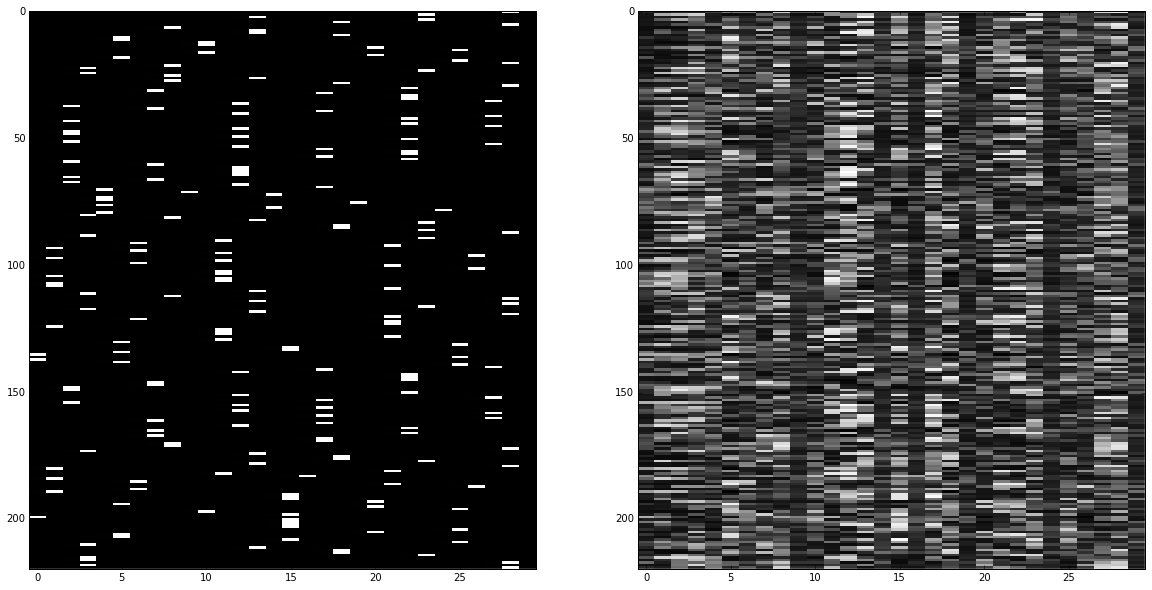

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.6295 - val_loss: 3.0557


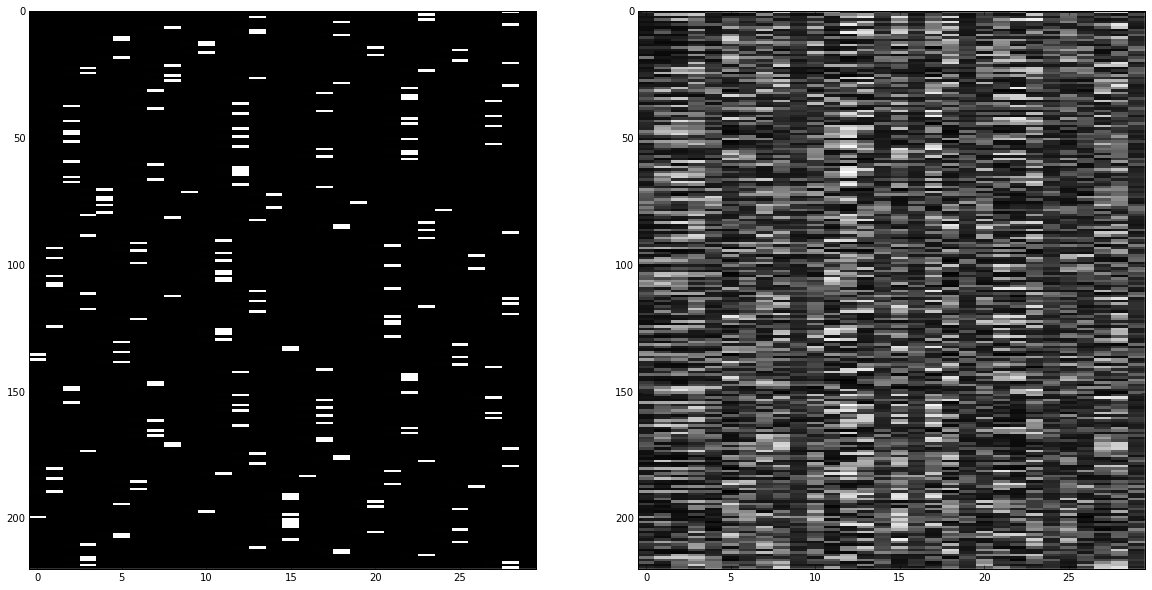

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.6430 - val_loss: 2.9582


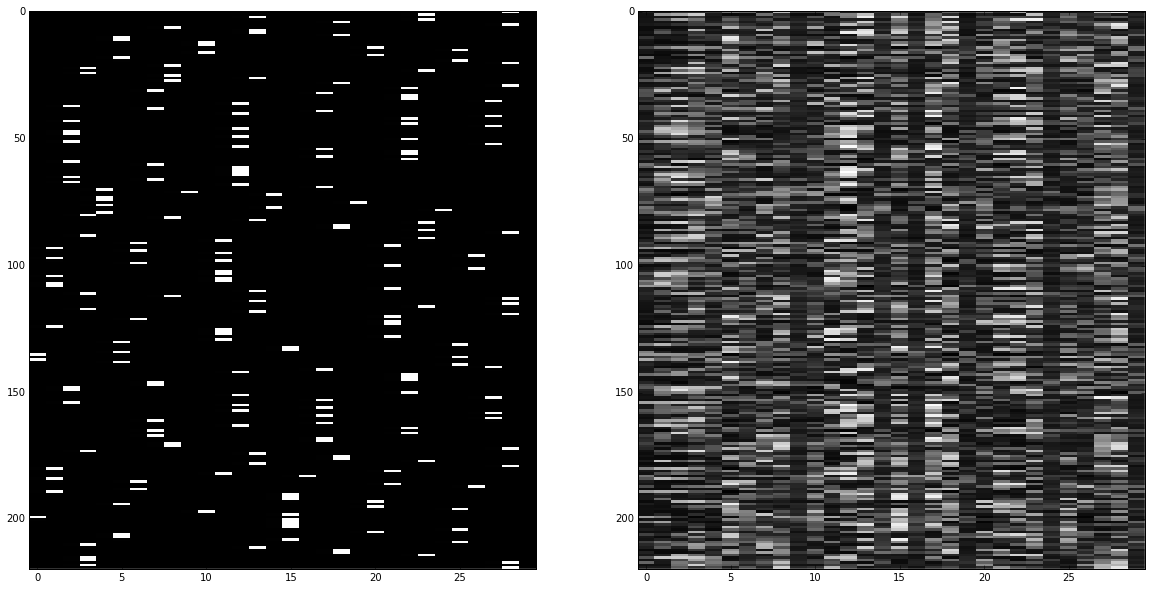

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.5947 - val_loss: 2.9689


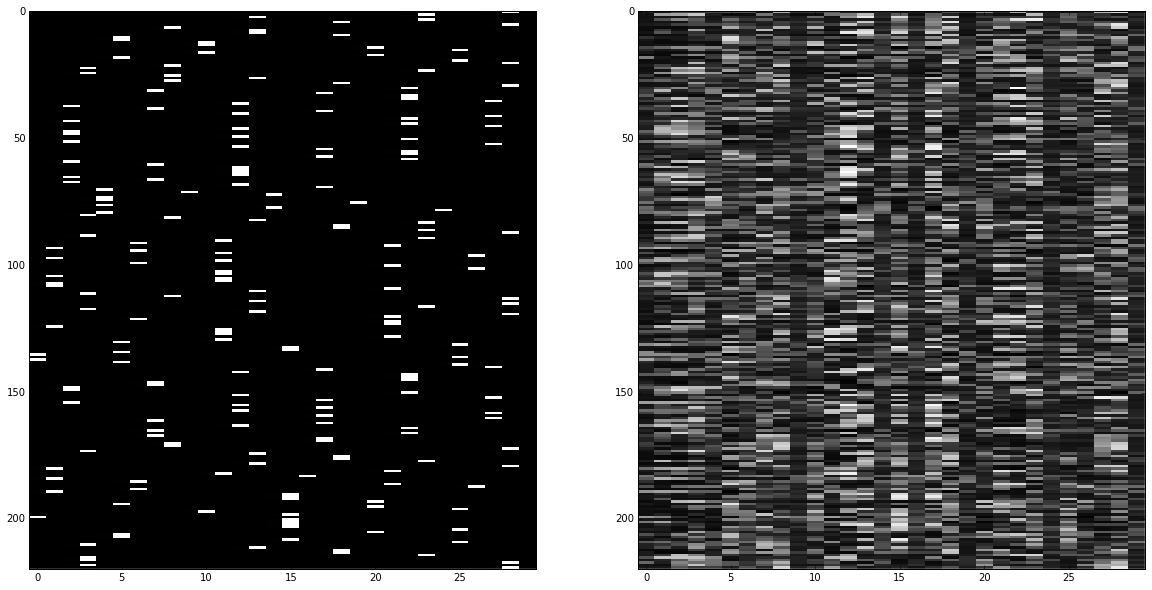

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.6034 - val_loss: 2.9968


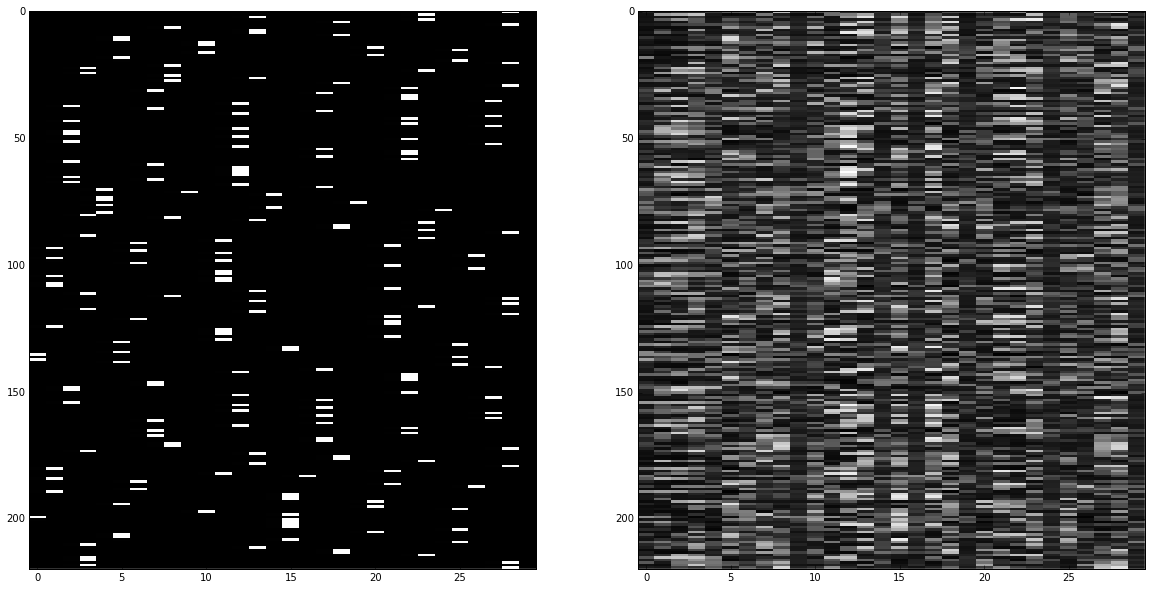

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.5730 - val_loss: 3.0391


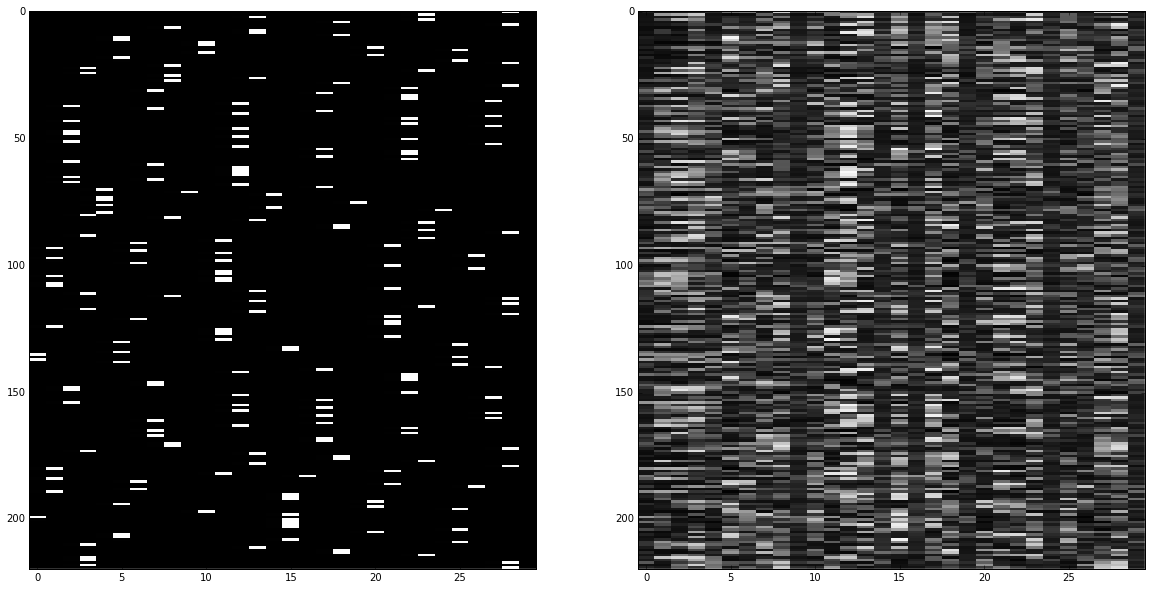

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.5692 - val_loss: 3.0913


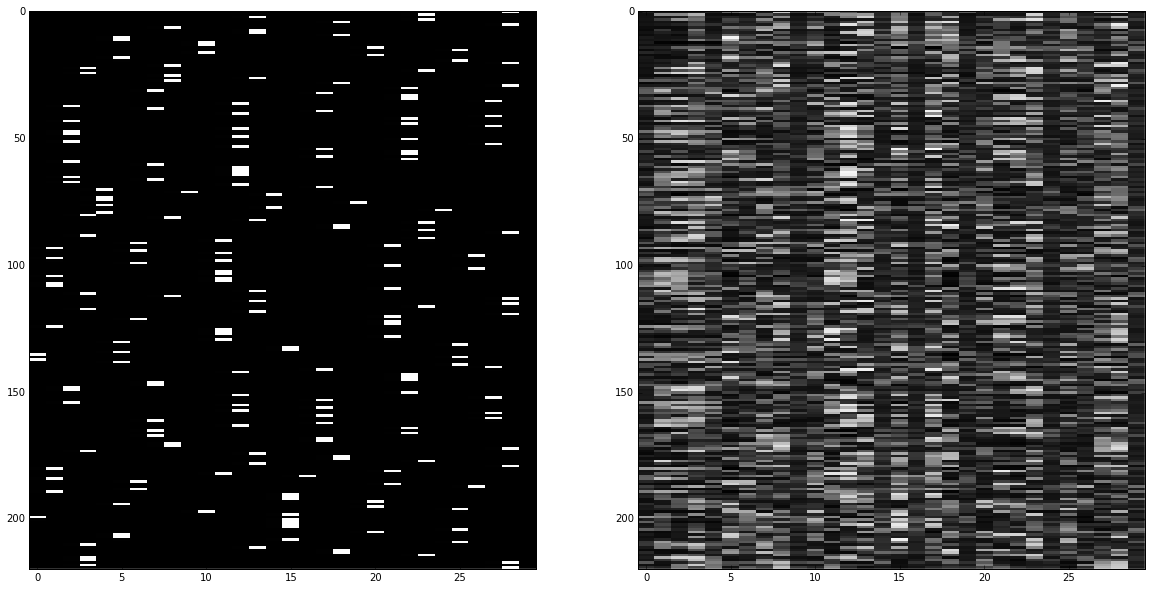

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.5728 - val_loss: 2.9352


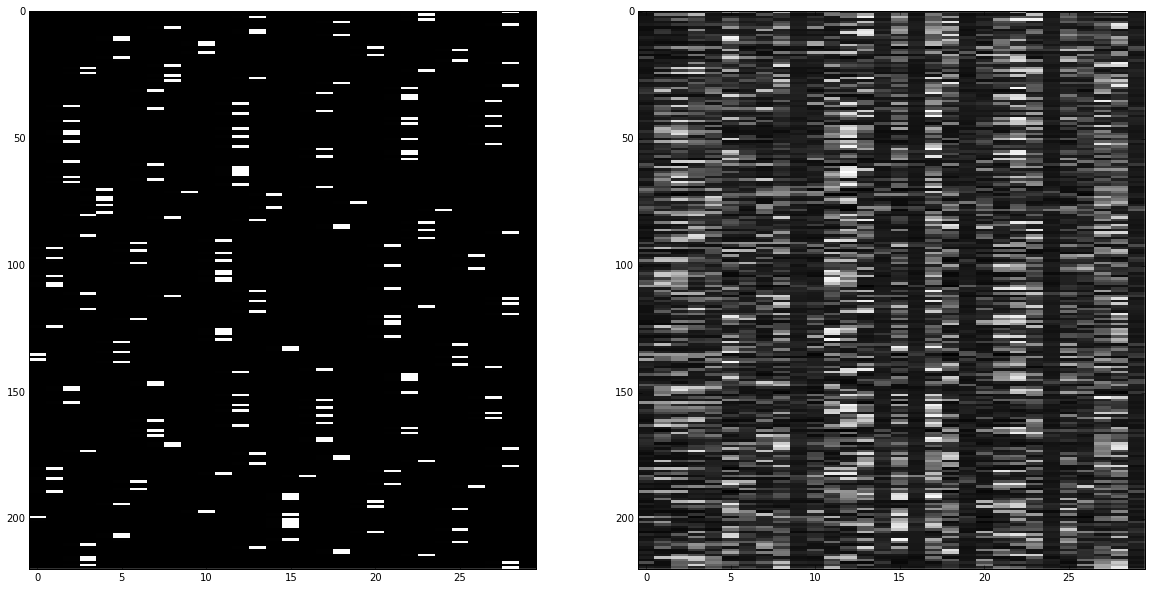

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4675 - val_loss: 2.9269


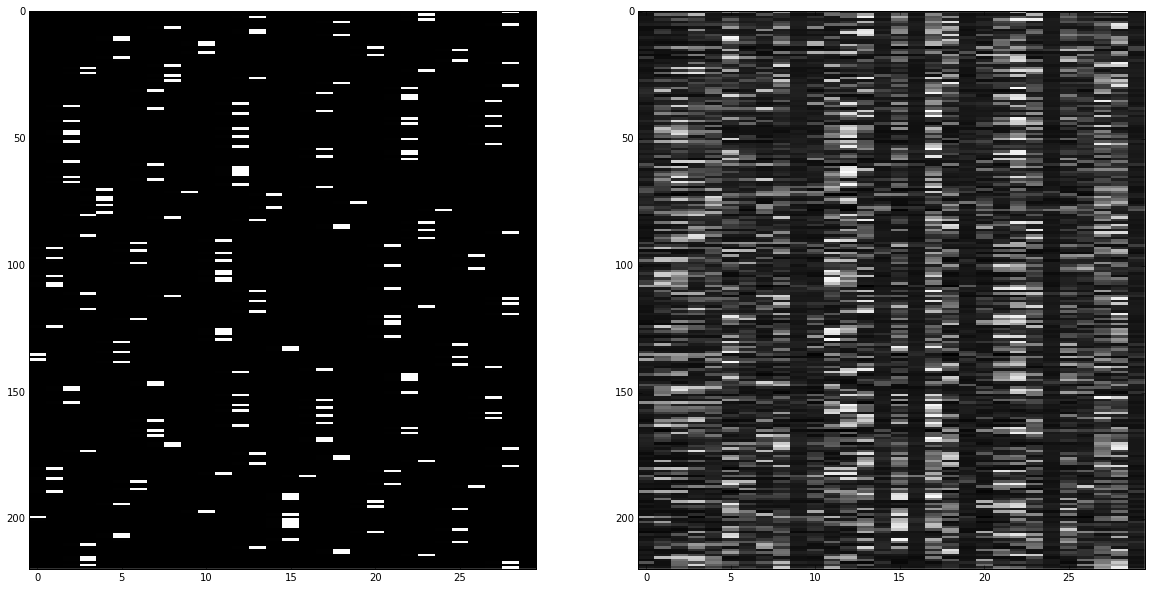

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4503 - val_loss: 2.9752


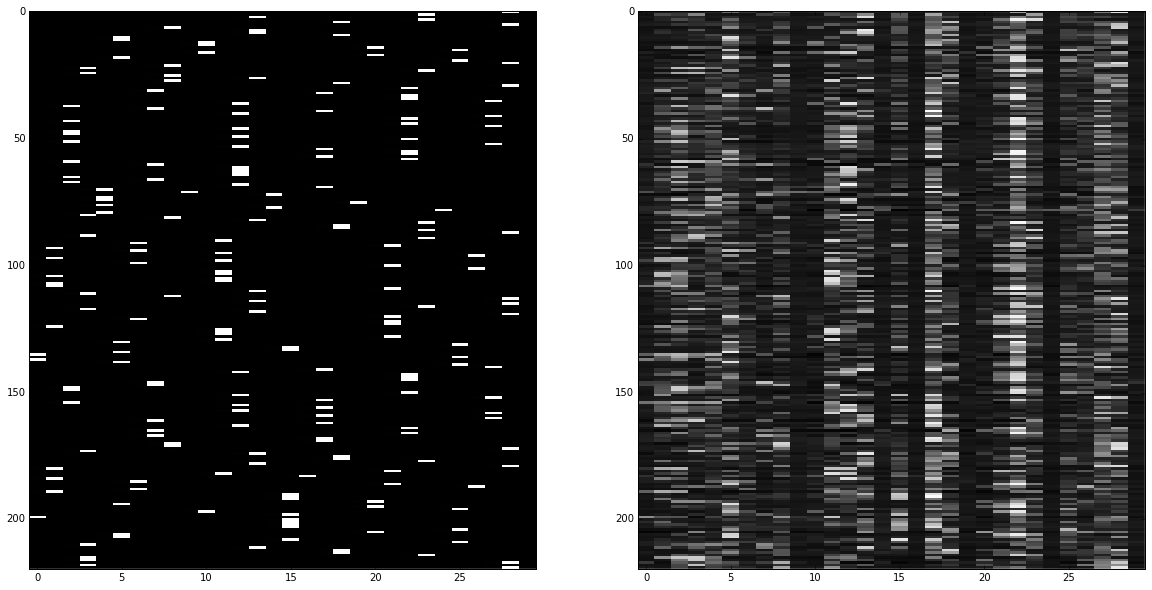

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.5873 - val_loss: 2.9233


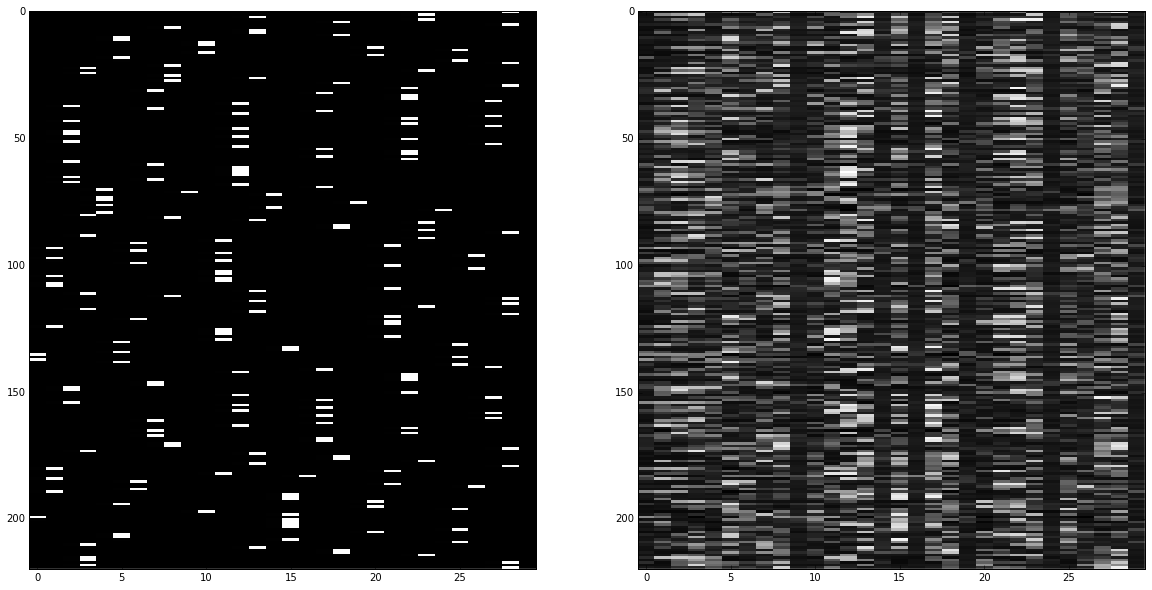

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4475 - val_loss: 2.8872


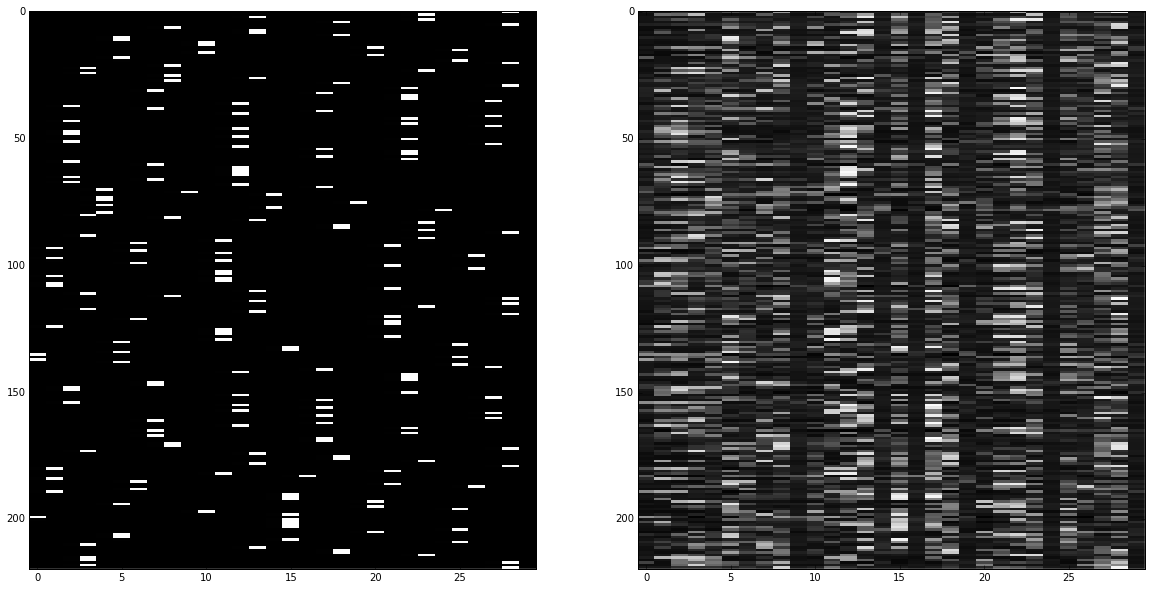

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4084 - val_loss: 2.8868


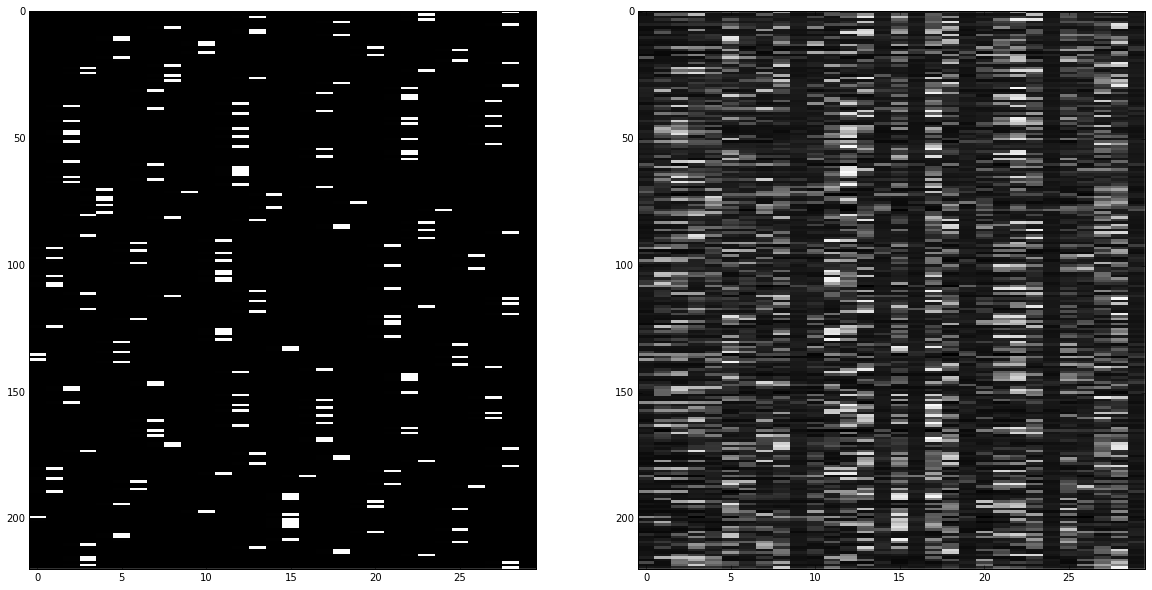

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.3984 - val_loss: 2.8706


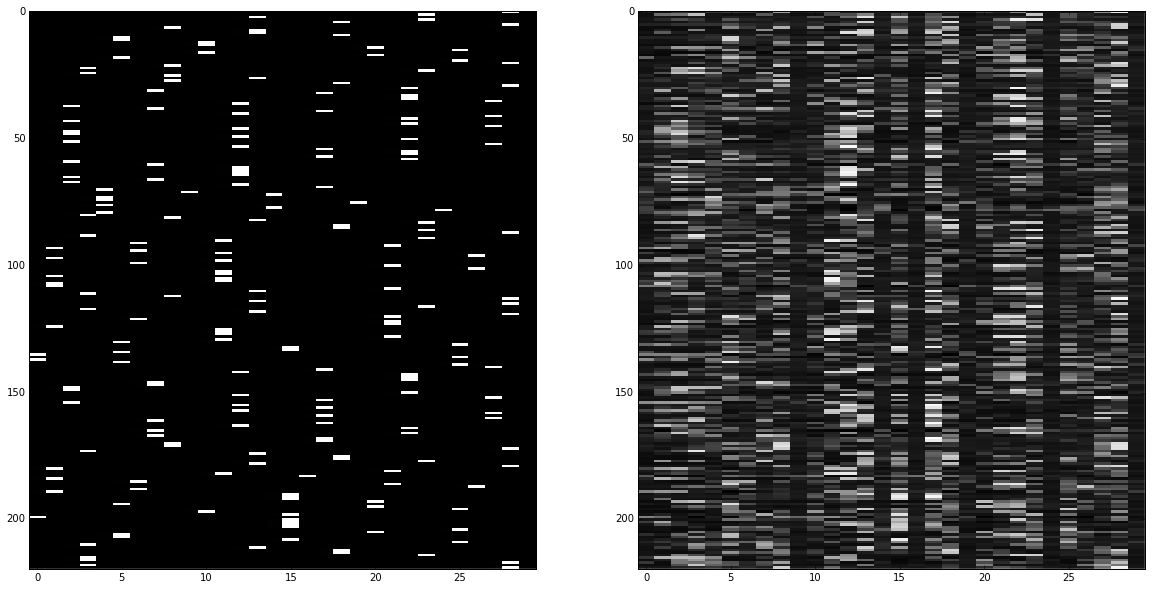

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.3783 - val_loss: 2.9015


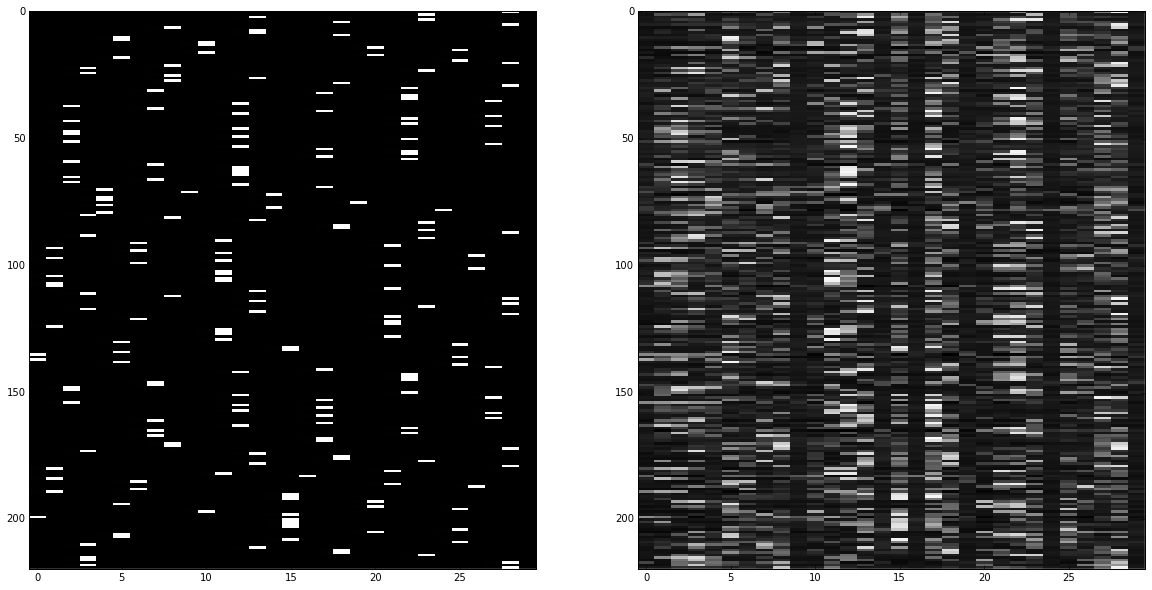

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.3349 - val_loss: 2.9608


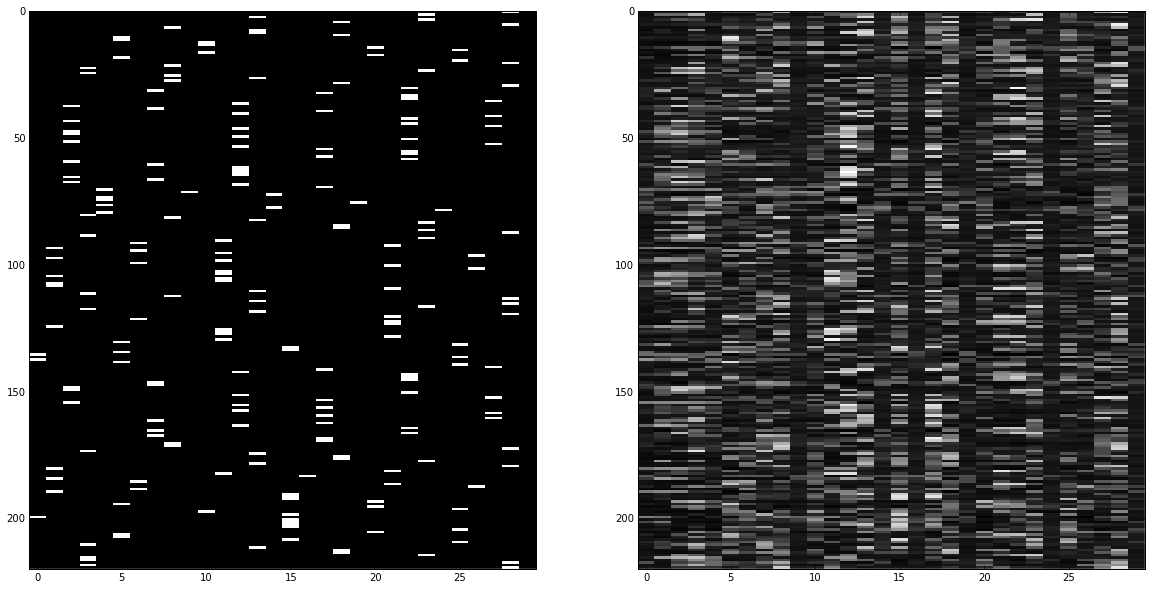

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4681 - val_loss: 3.0612


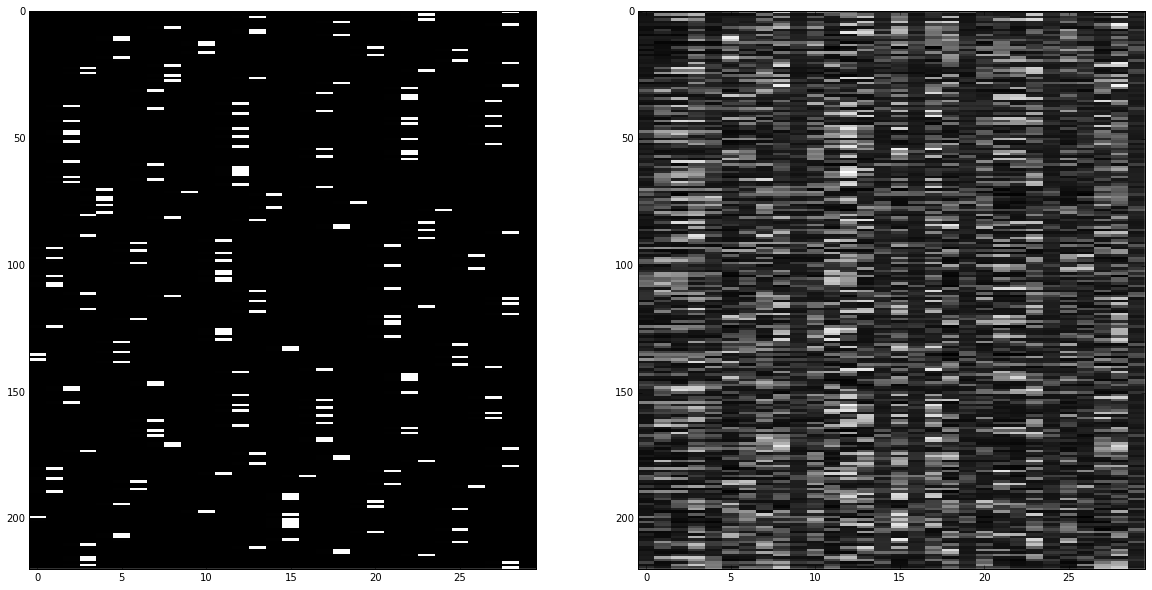

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.4739 - val_loss: 2.9300


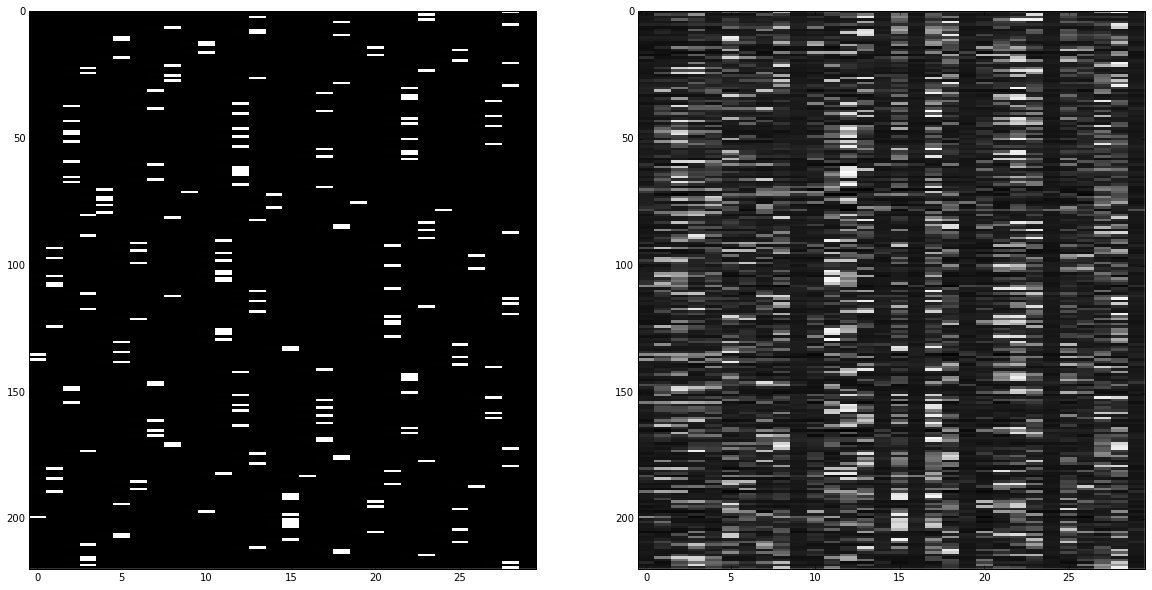

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.3069 - val_loss: 2.8927


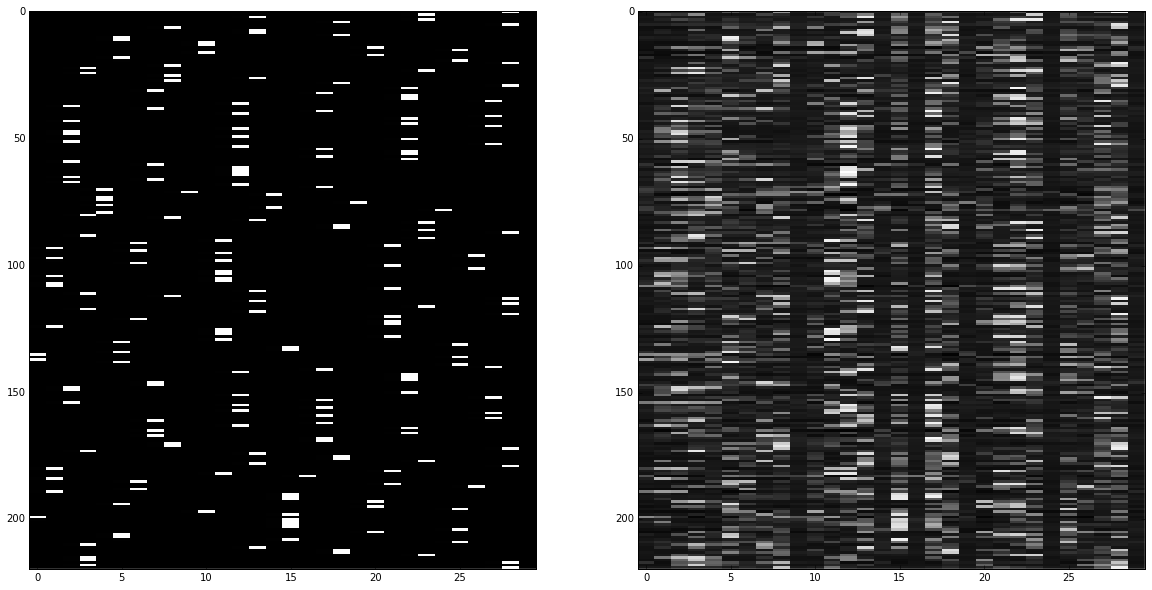

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2743 - val_loss: 2.9142


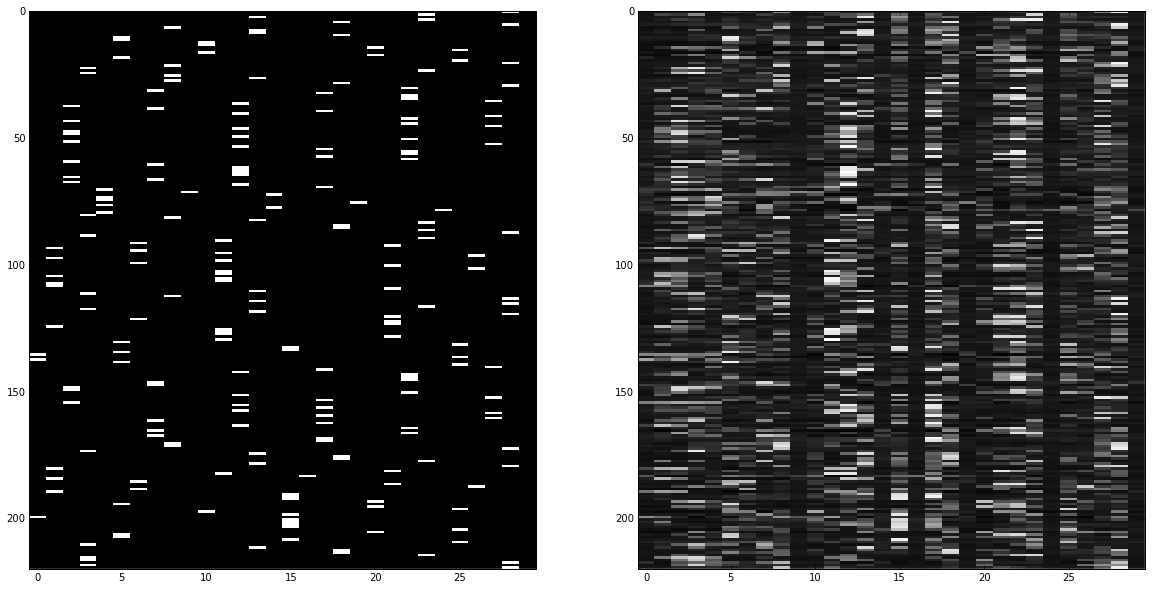

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2596 - val_loss: 2.9334


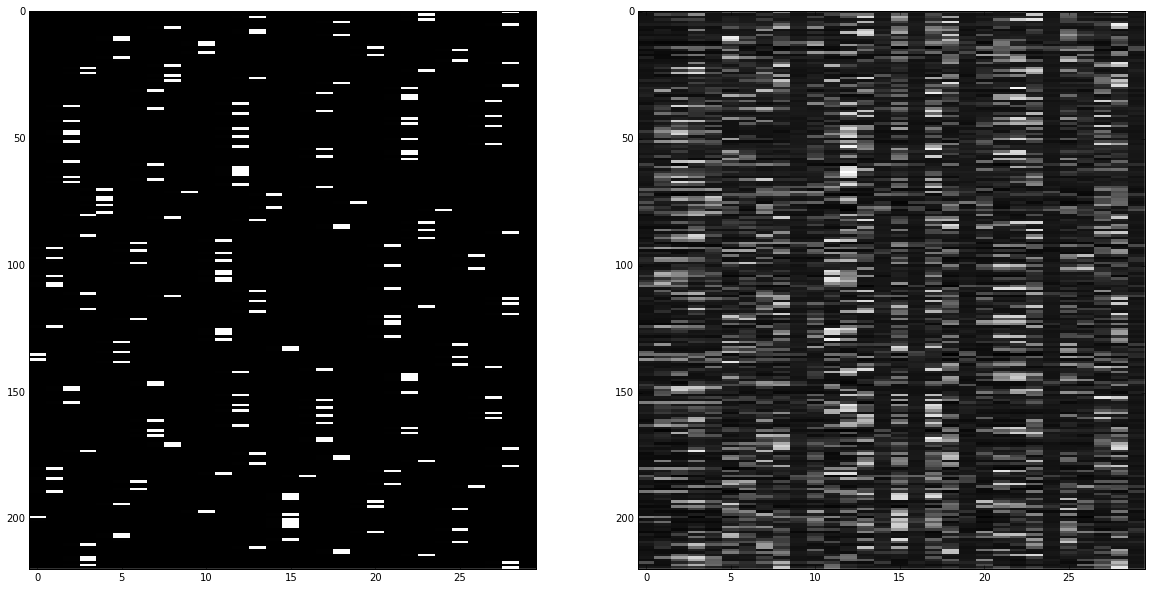

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 13s - loss: 2.3493 - val_loss: 3.0014


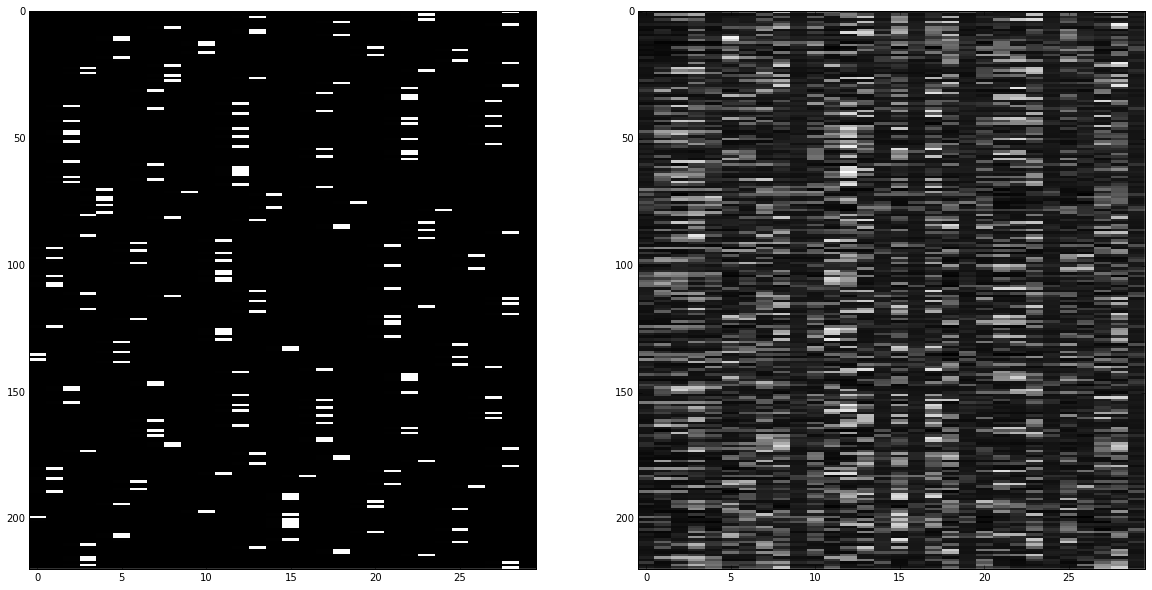

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.3530 - val_loss: 2.9101


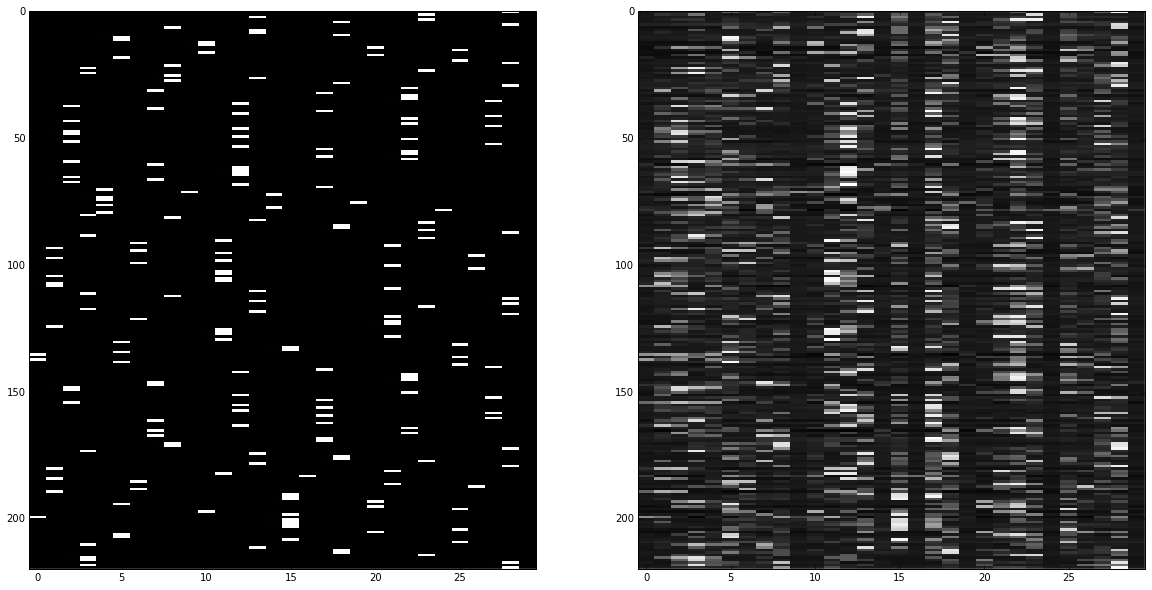

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2286 - val_loss: 2.8797


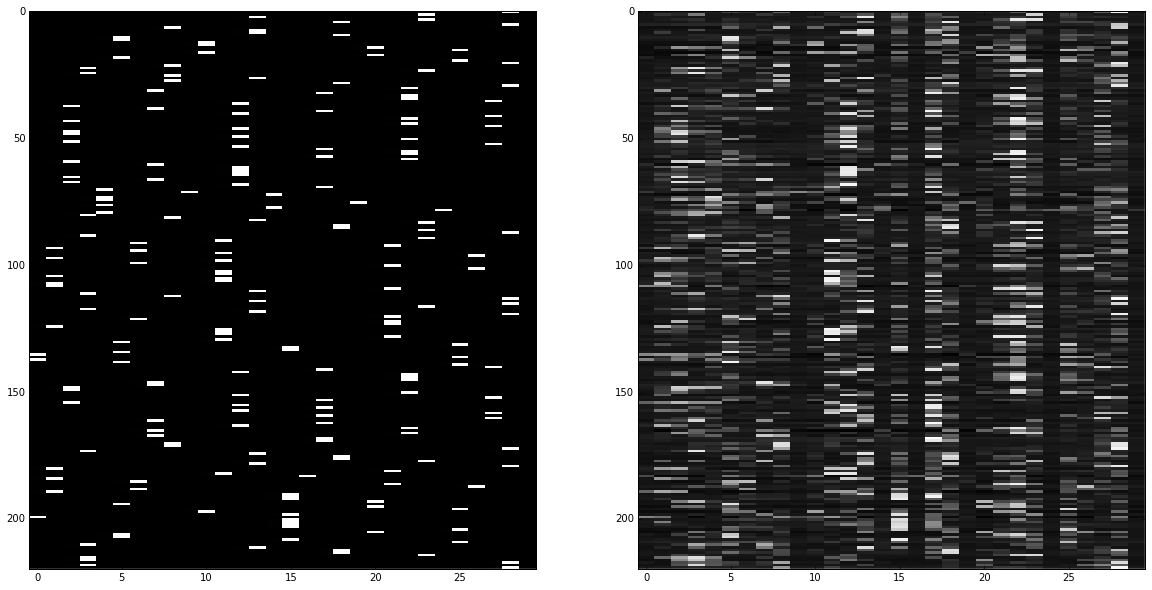

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2590 - val_loss: 2.8333


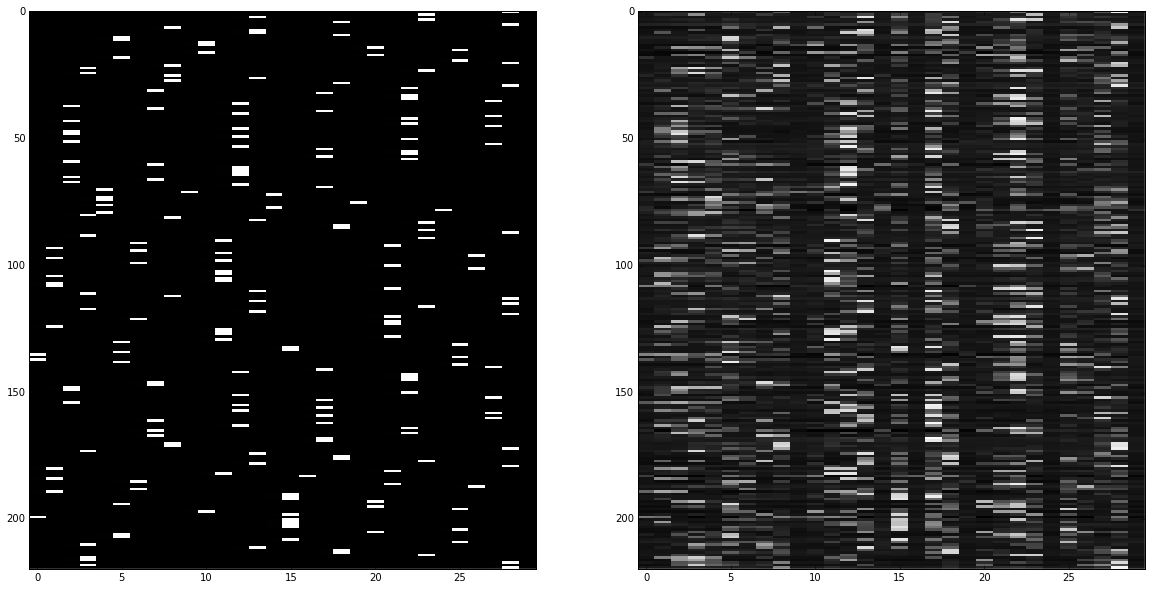

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2956 - val_loss: 2.8322


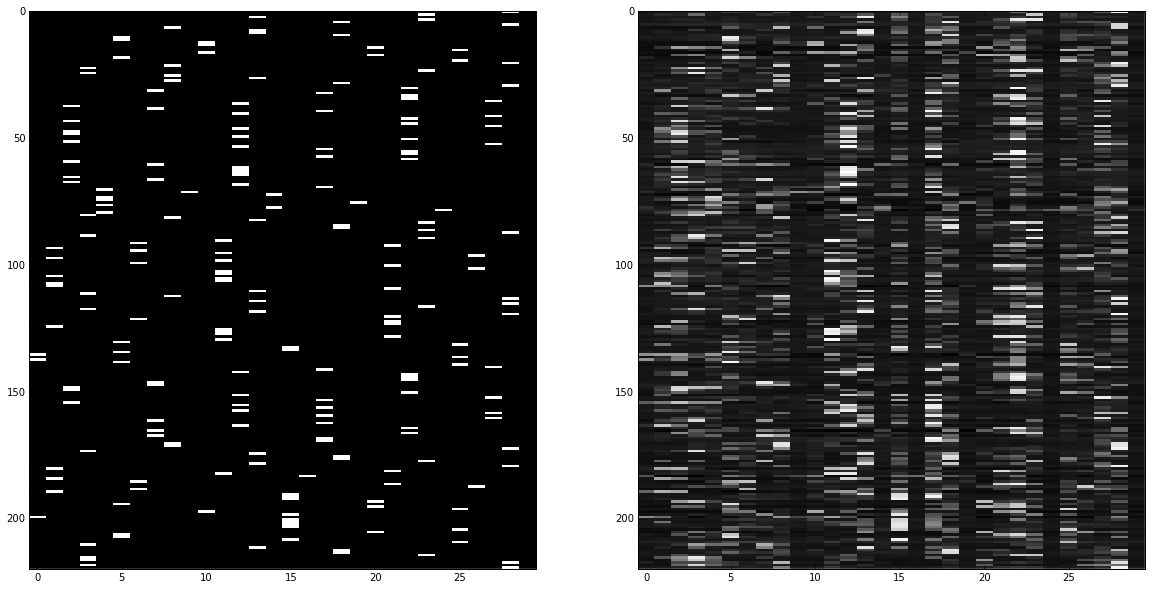

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1961 - val_loss: 2.8831


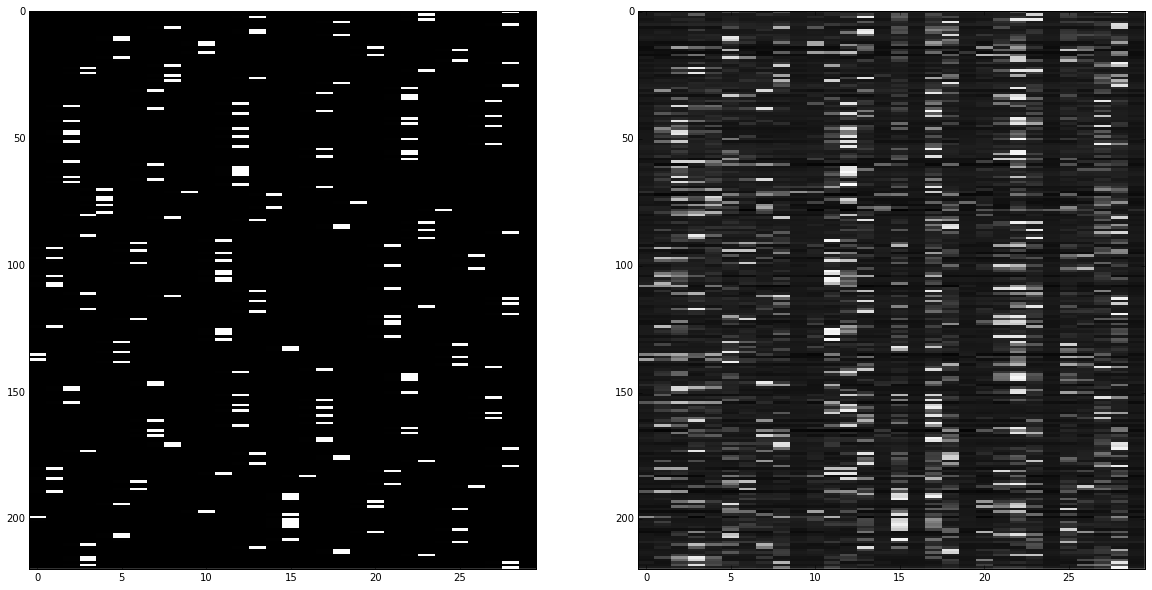

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 13s - loss: 2.2093 - val_loss: 2.9410


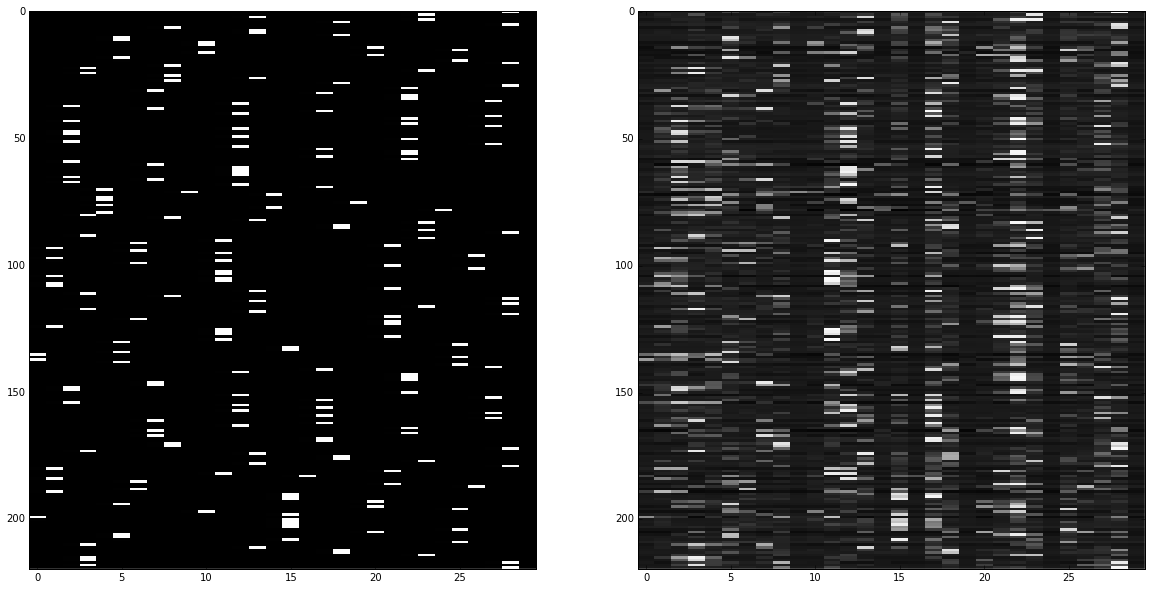

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2777 - val_loss: 2.8438


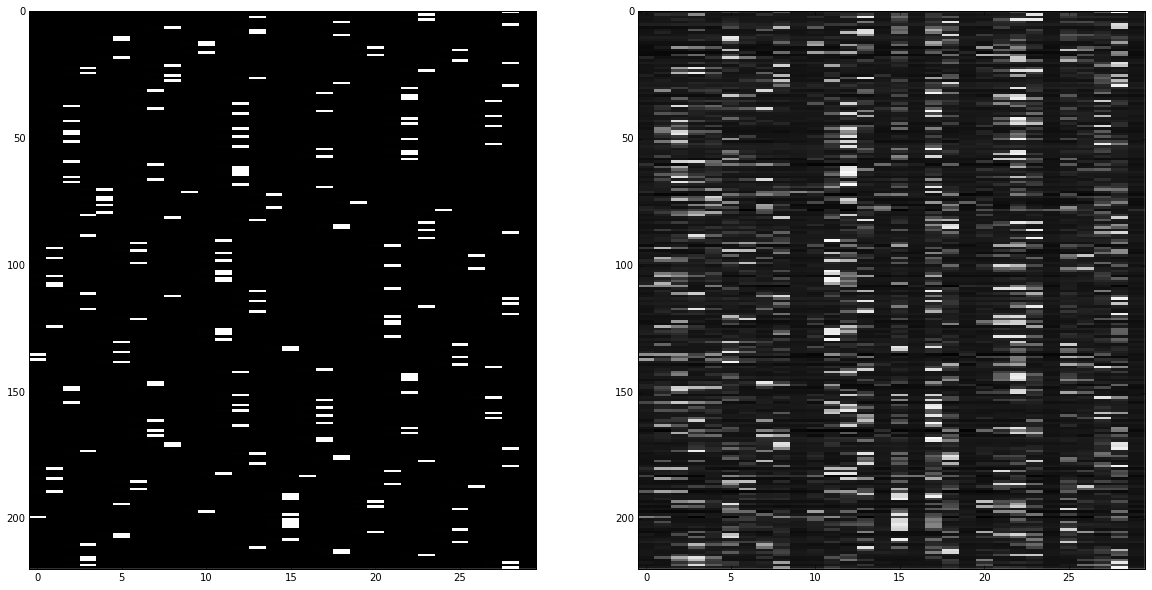

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1607 - val_loss: 2.8760


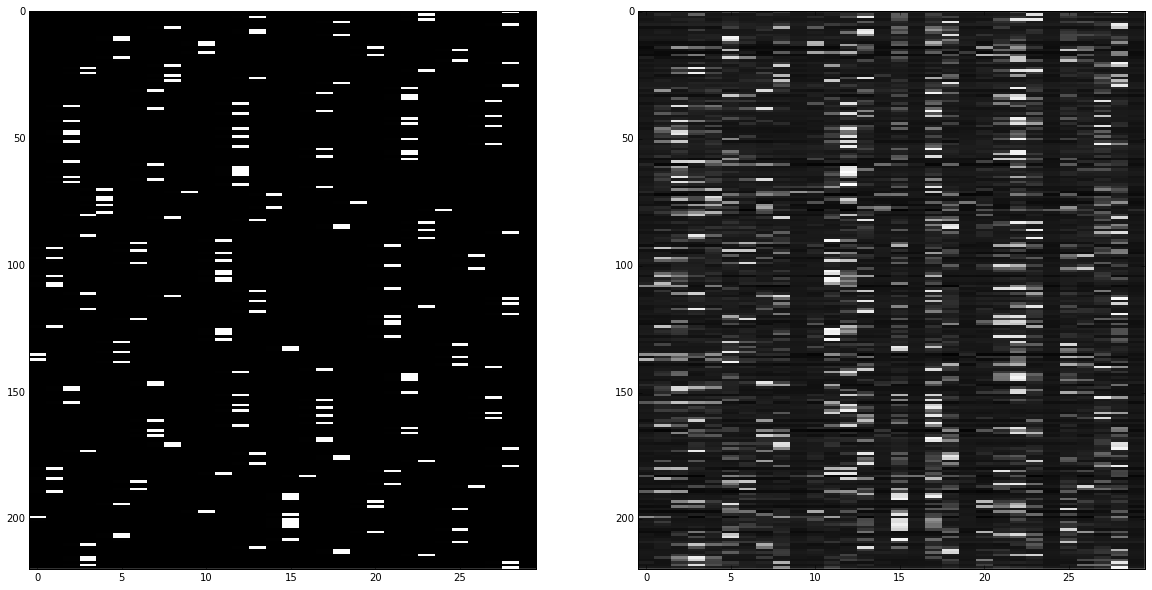

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1330 - val_loss: 2.9011


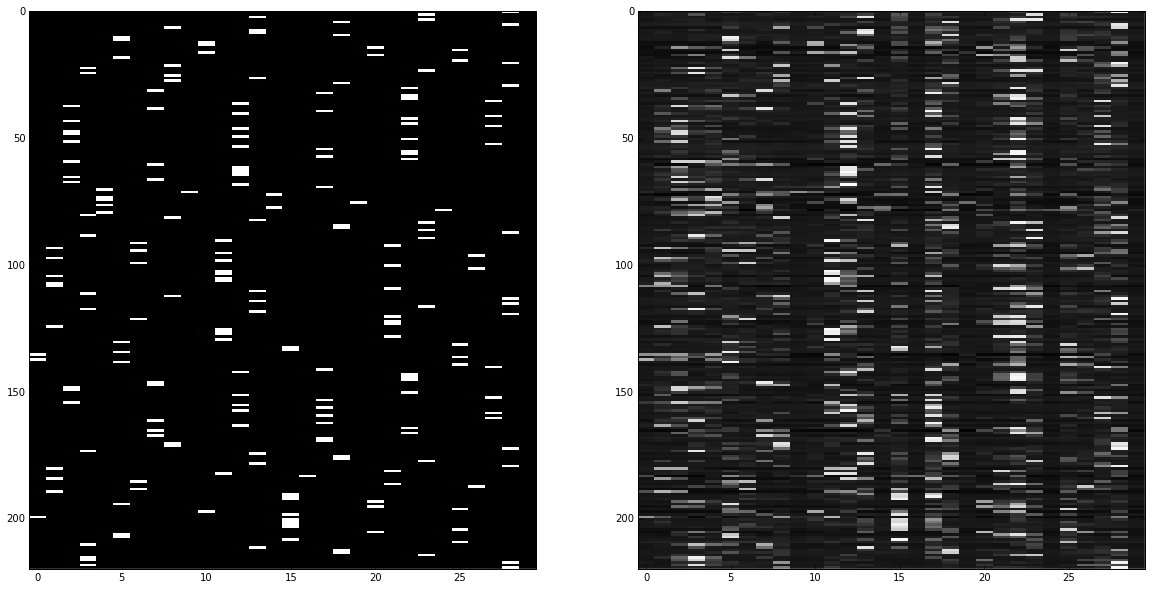

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1823 - val_loss: 2.9029


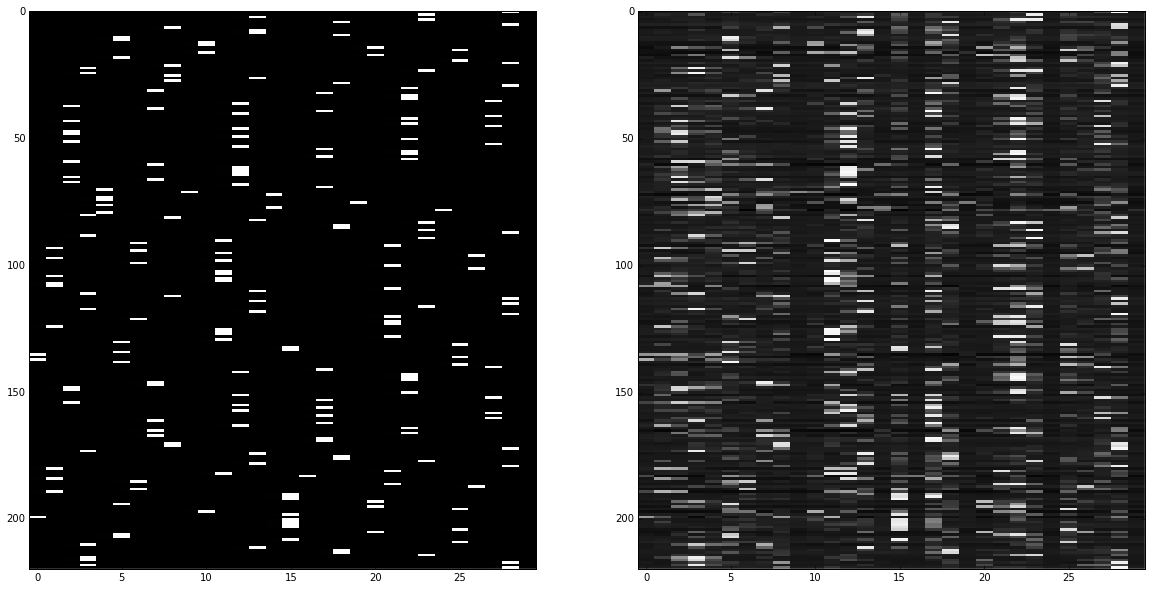

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1375 - val_loss: 2.9104


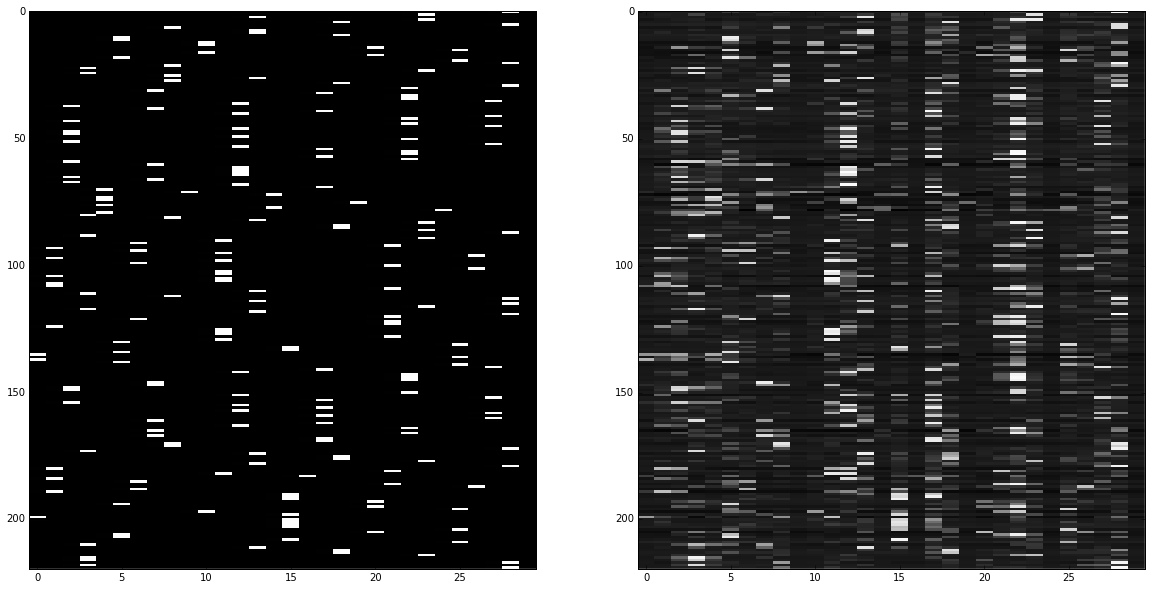

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.2476 - val_loss: 2.9220


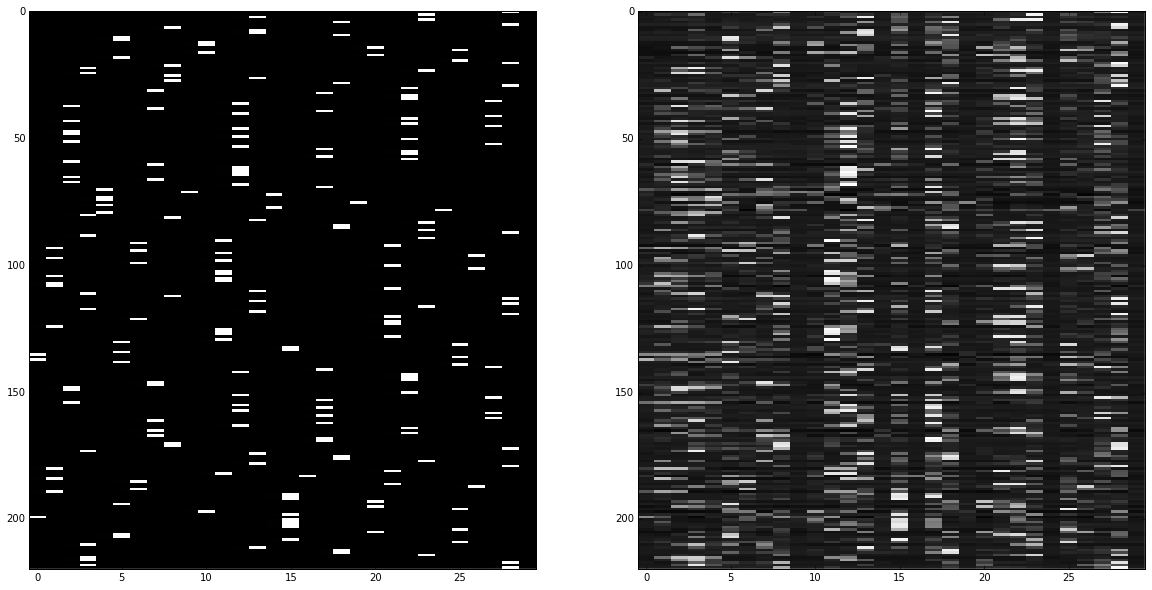

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1283 - val_loss: 2.9392


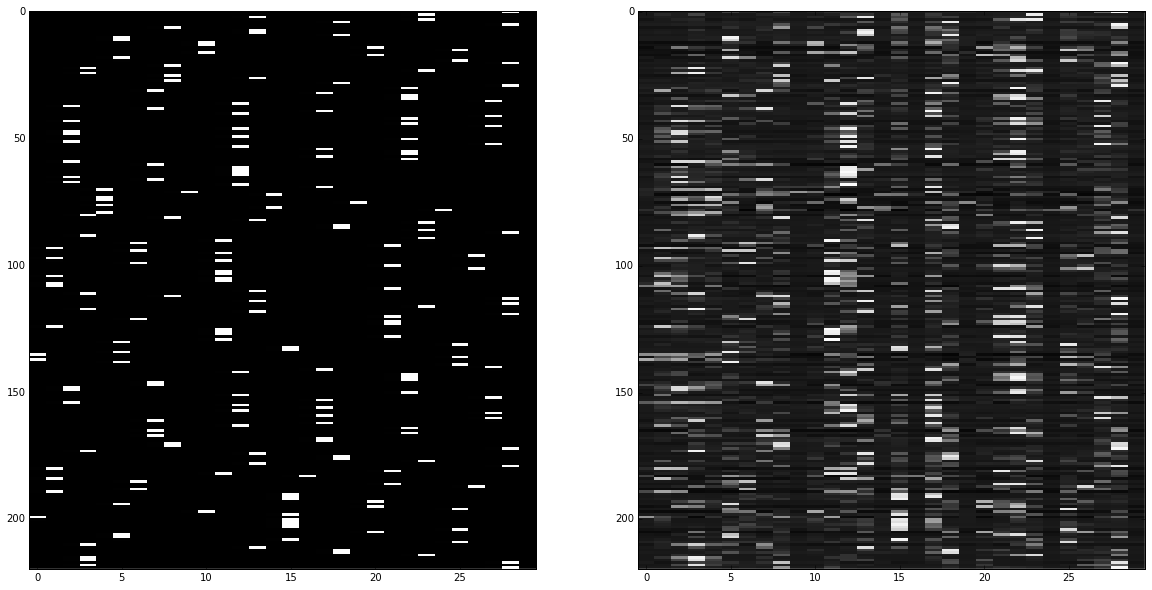

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1164 - val_loss: 2.9625


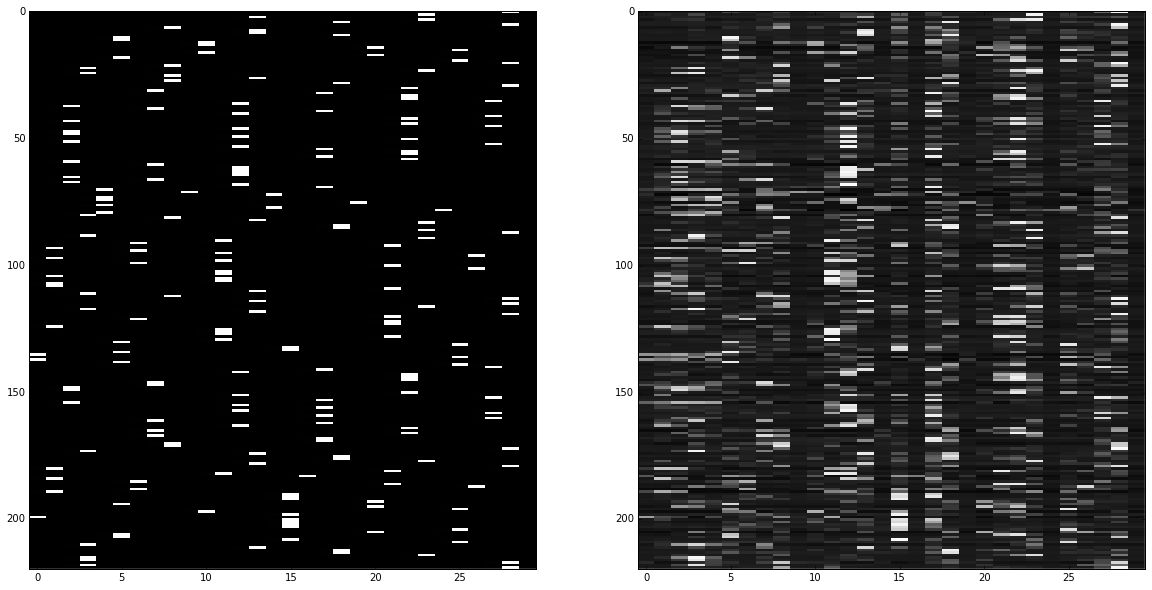

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 13s - loss: 2.1468 - val_loss: 2.9082


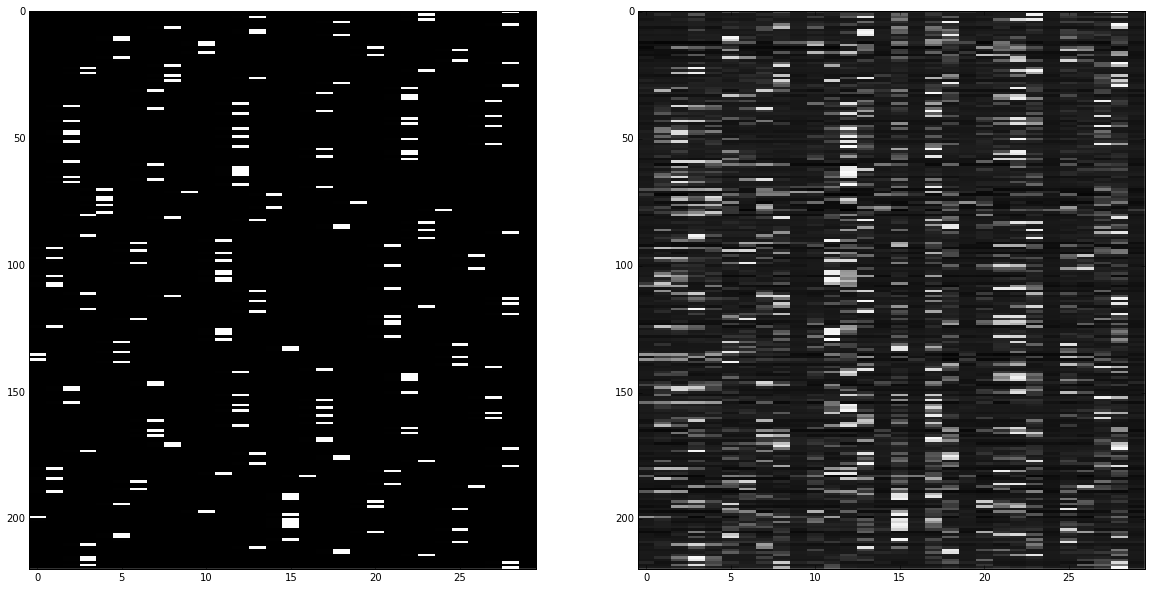

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1021 - val_loss: 2.8805


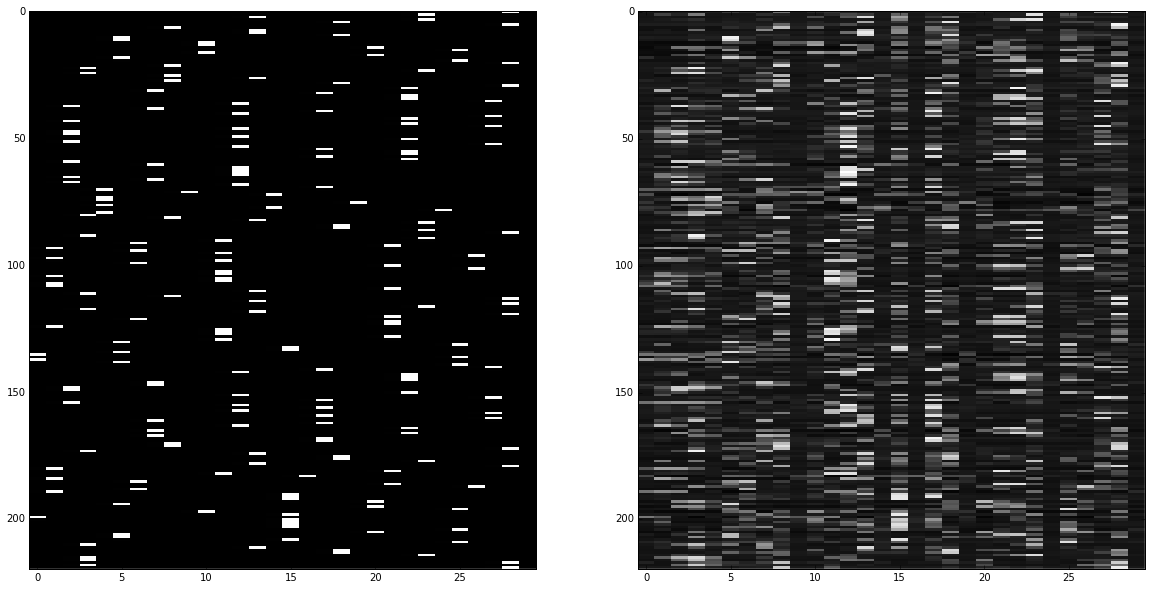

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1335 - val_loss: 2.8518


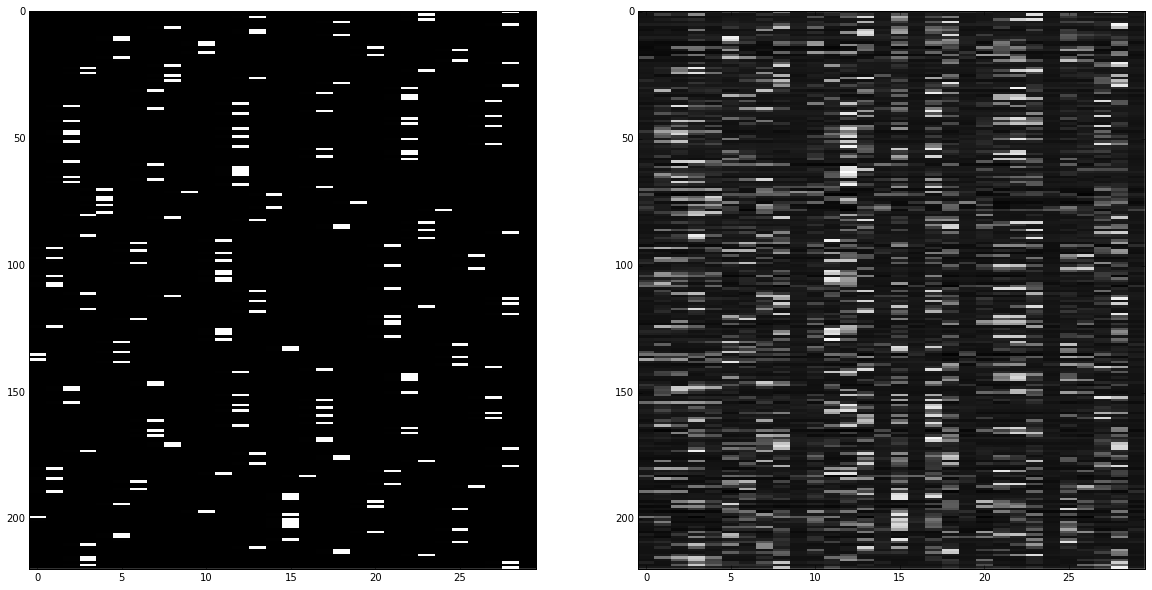

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.1195 - val_loss: 2.8491


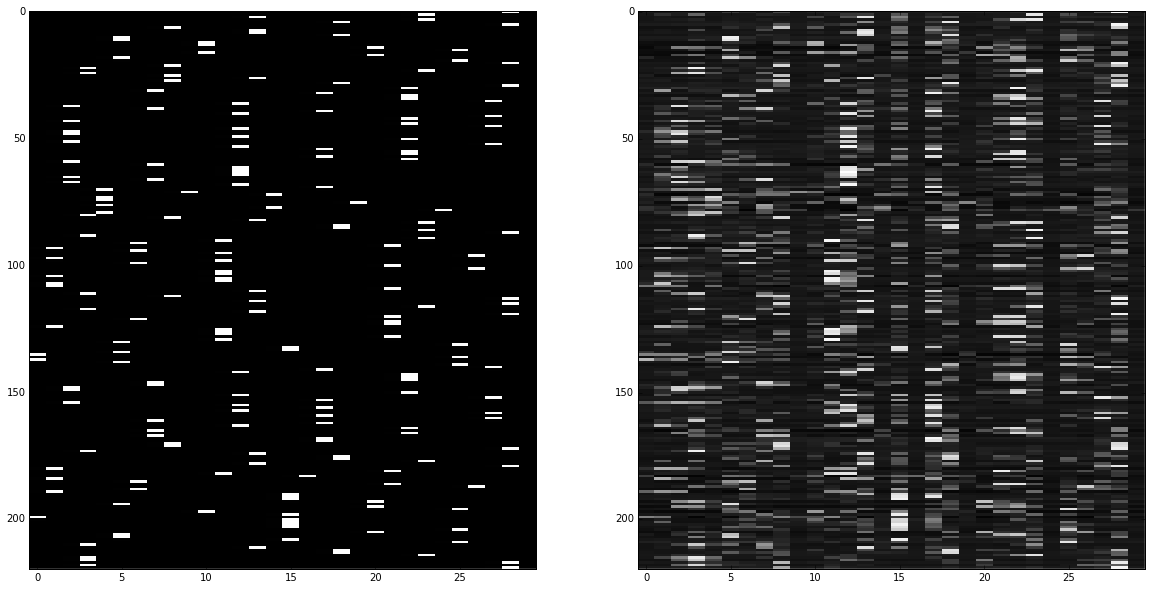

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0658 - val_loss: 2.8320


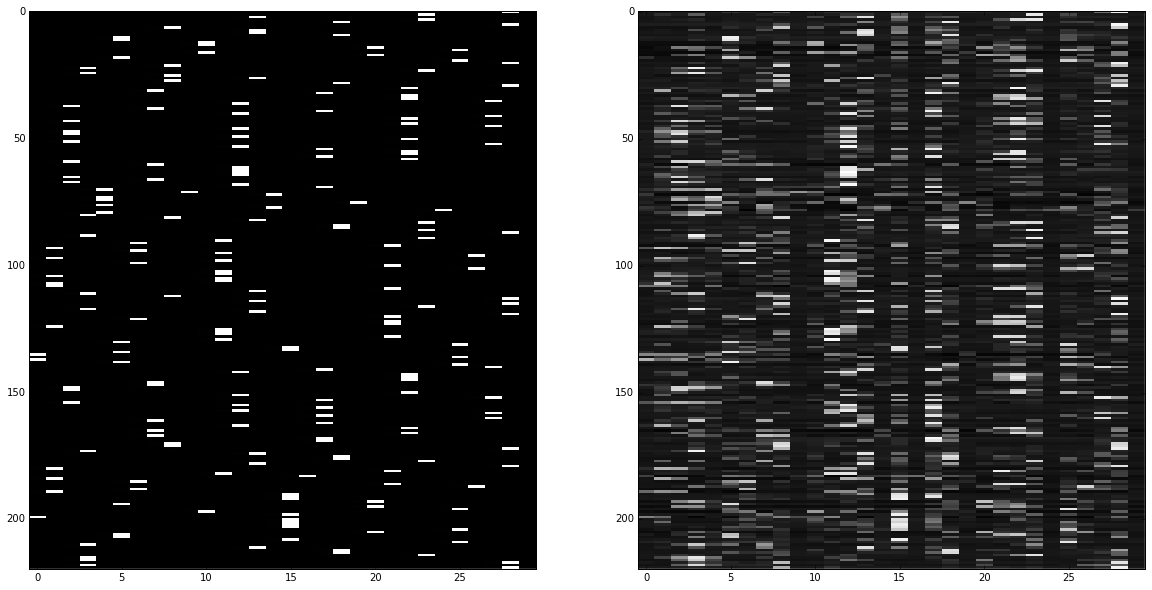

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0609 - val_loss: 2.8952


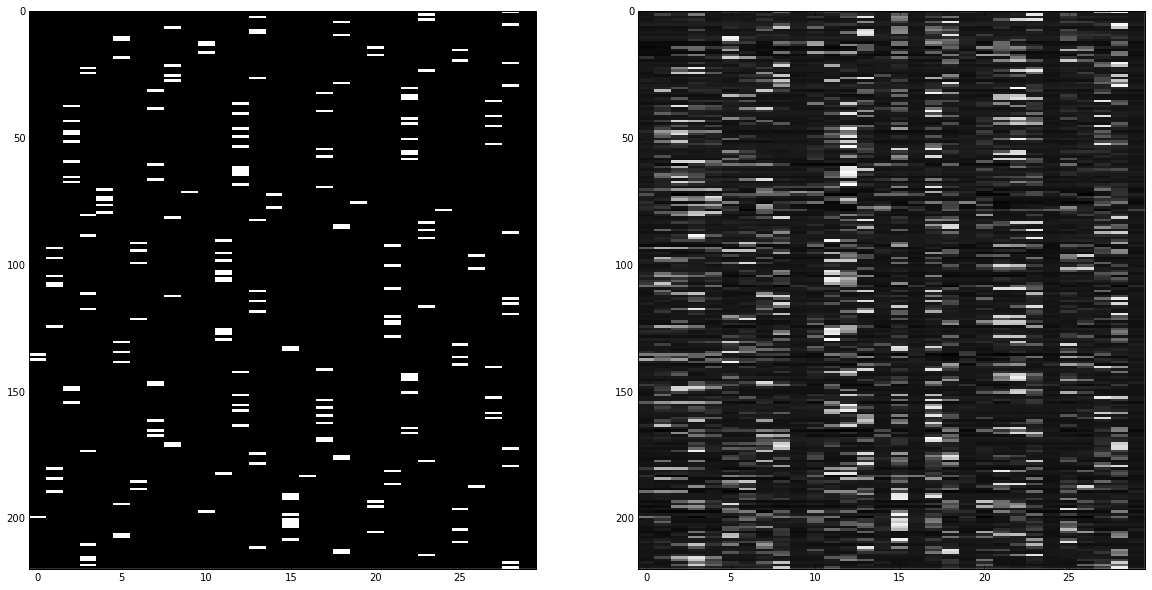

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0756 - val_loss: 2.8831


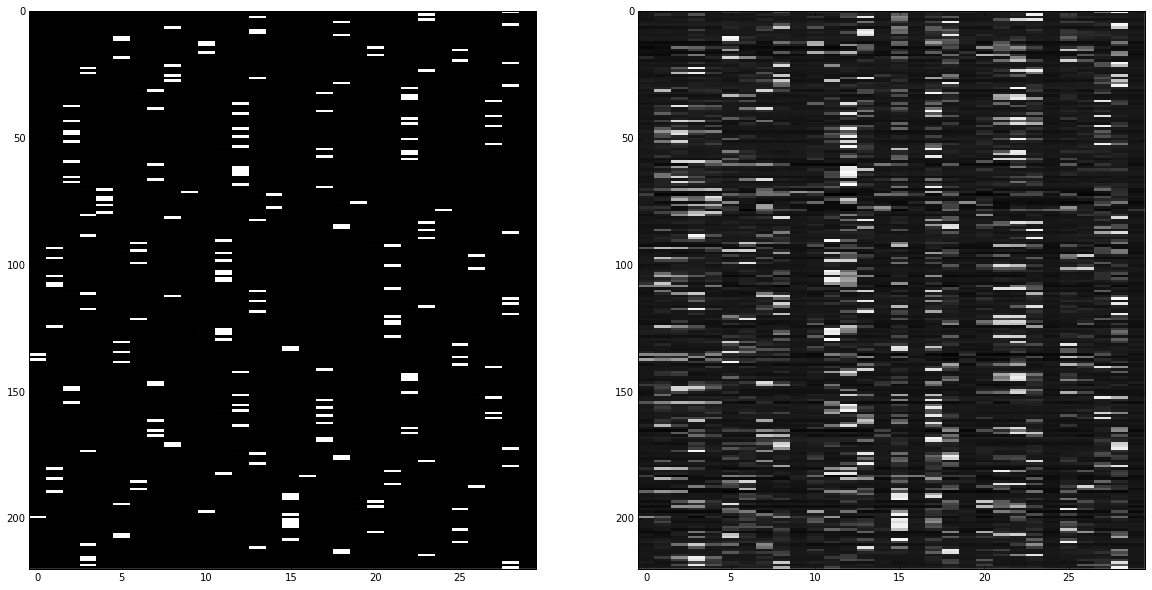

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0473 - val_loss: 2.8894


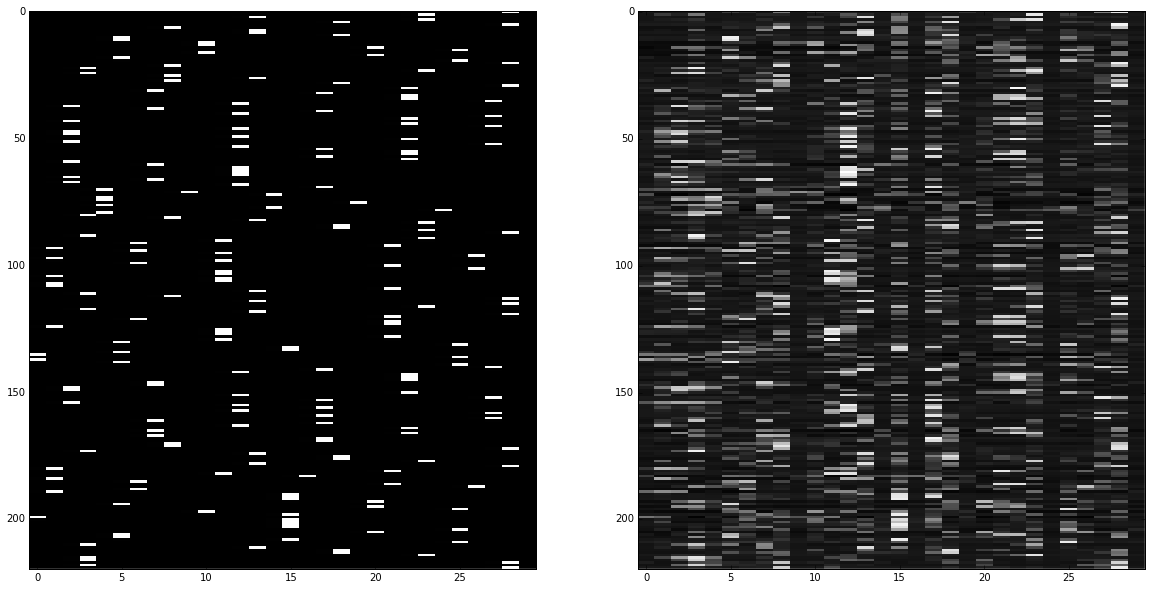

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0787 - val_loss: 2.8449


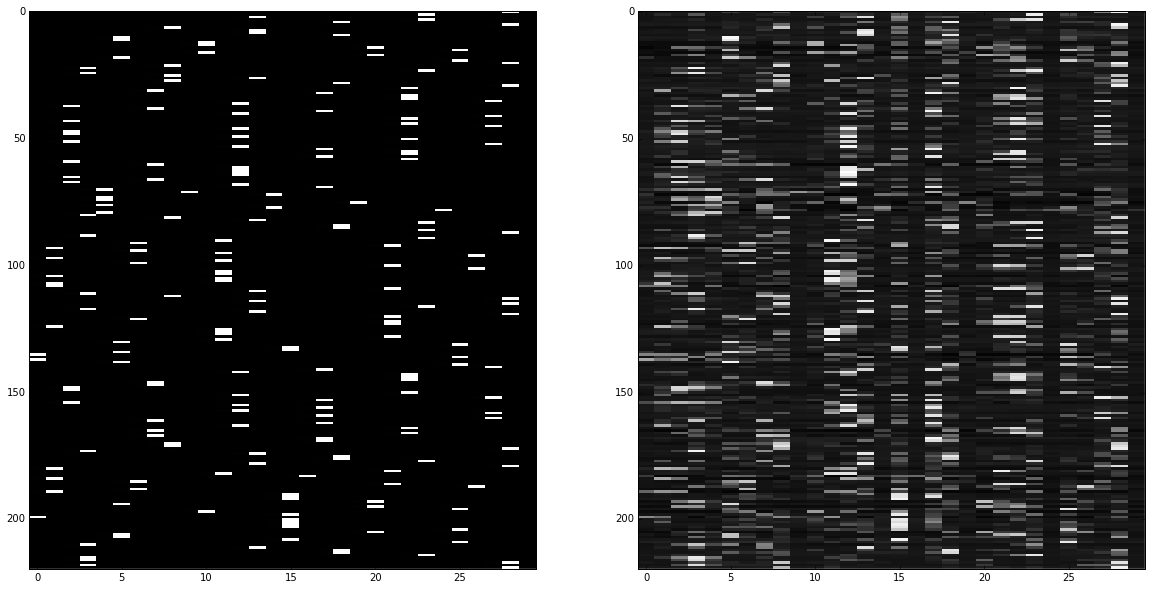

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0351 - val_loss: 2.9055


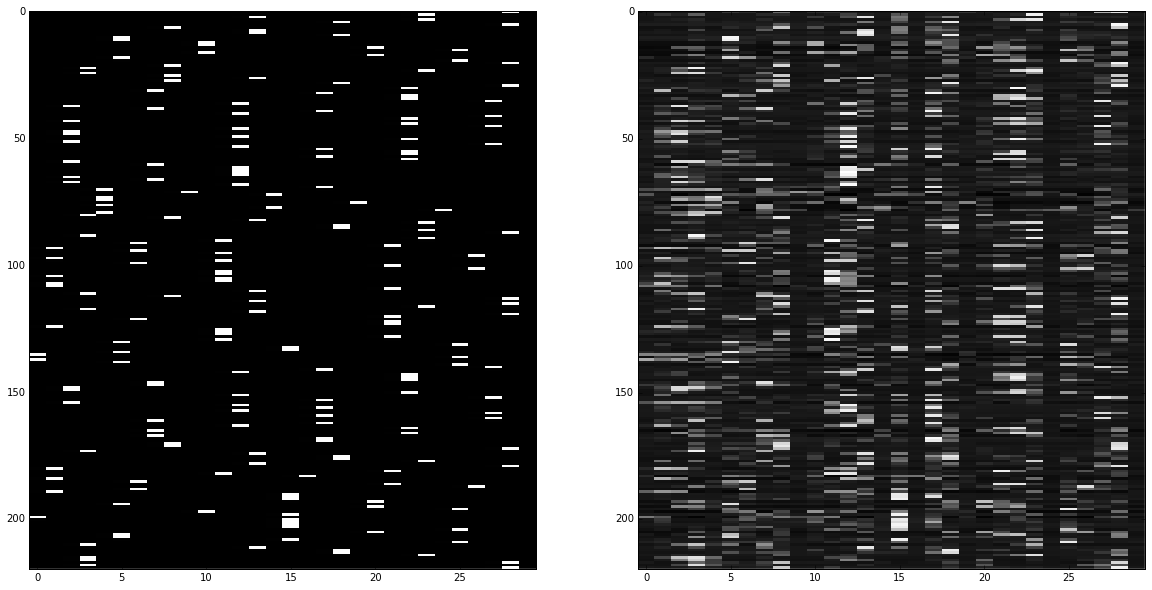

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0395 - val_loss: 2.7989


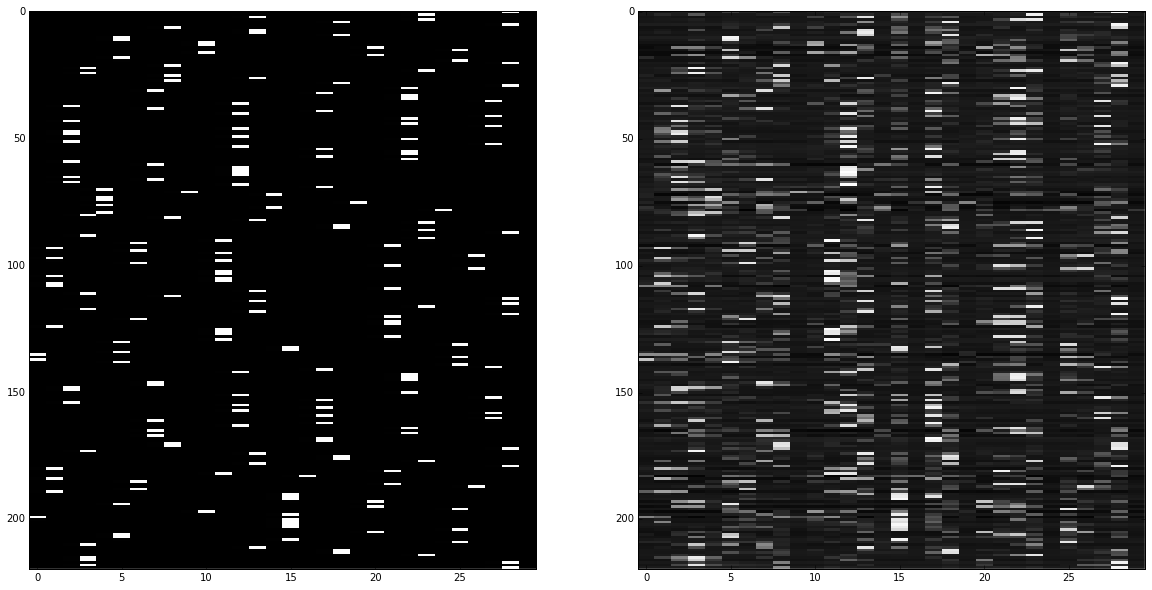

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0103 - val_loss: 2.7414


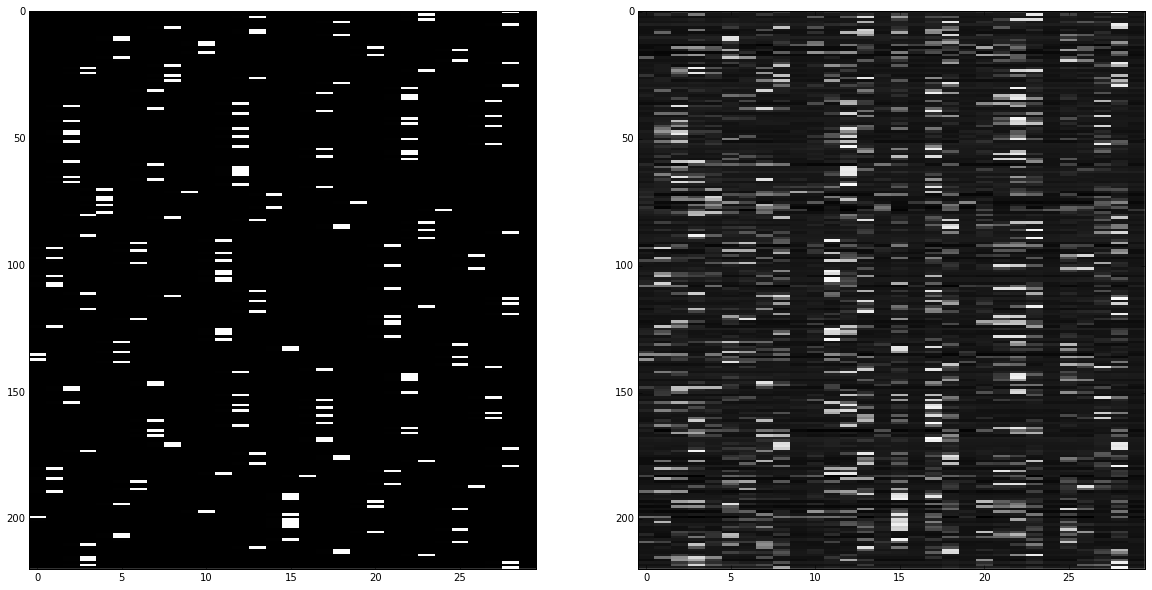

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0378 - val_loss: 2.8337


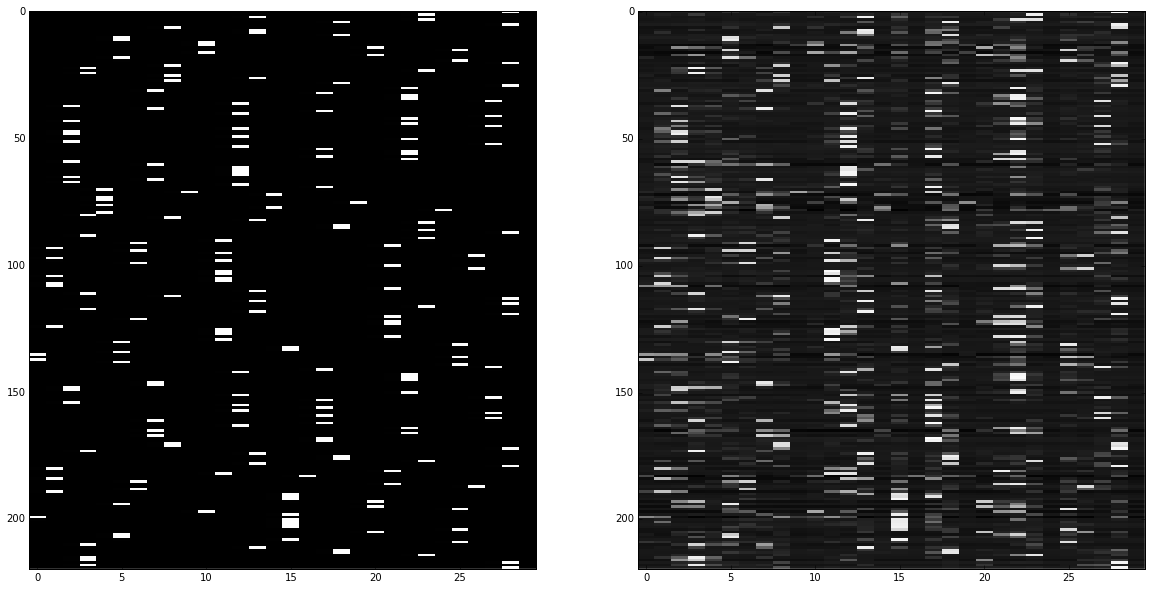

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9906 - val_loss: 2.8870


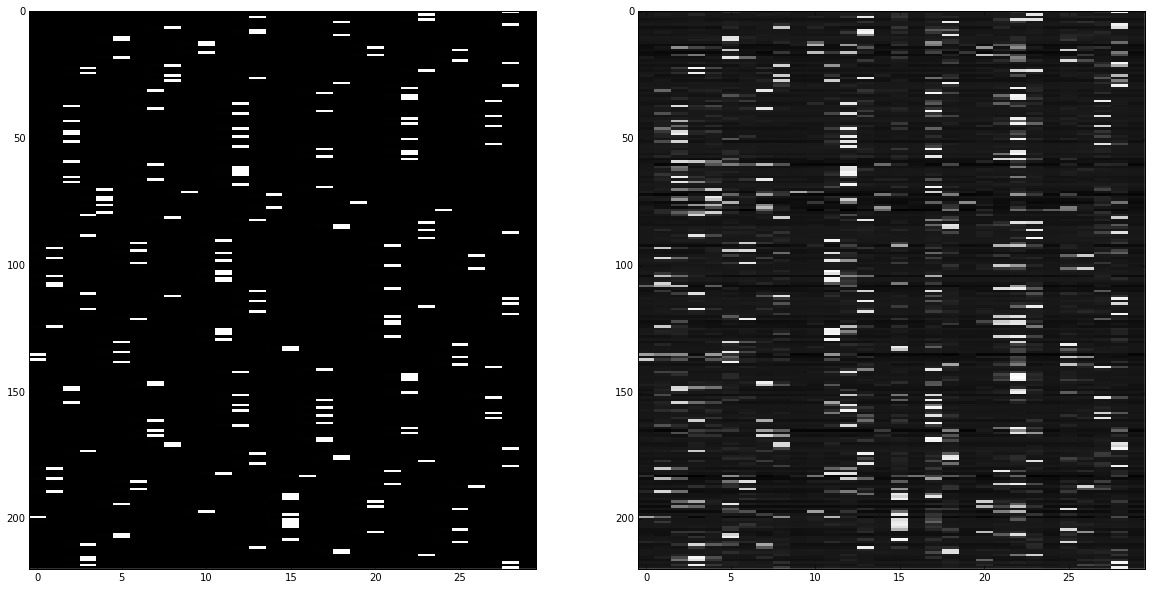

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0178 - val_loss: 2.8484


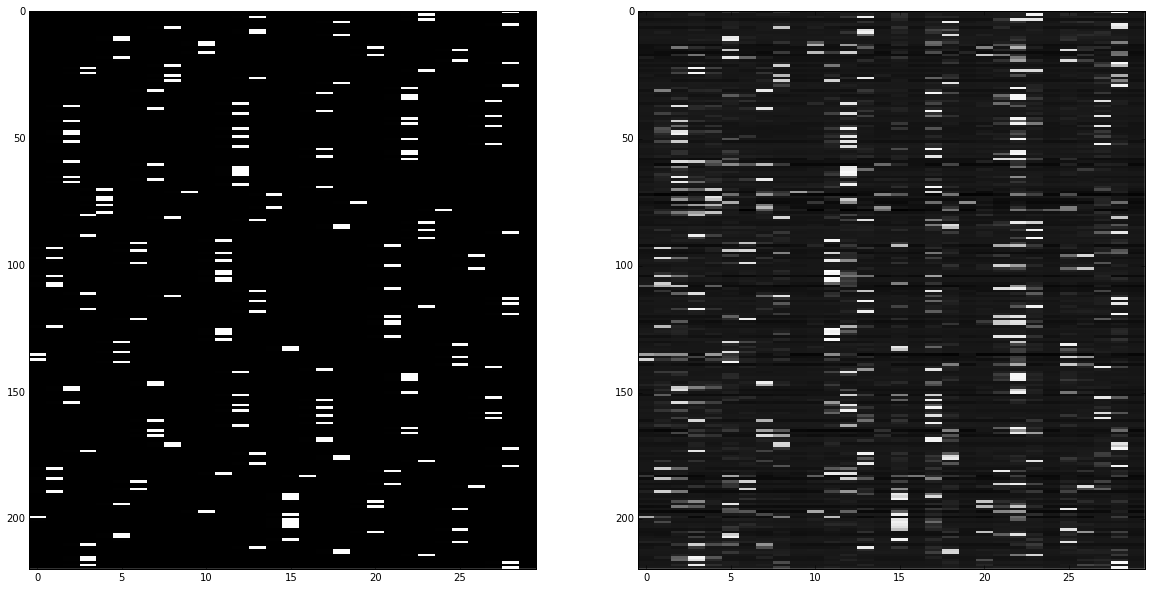

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 2.0129 - val_loss: 2.8528


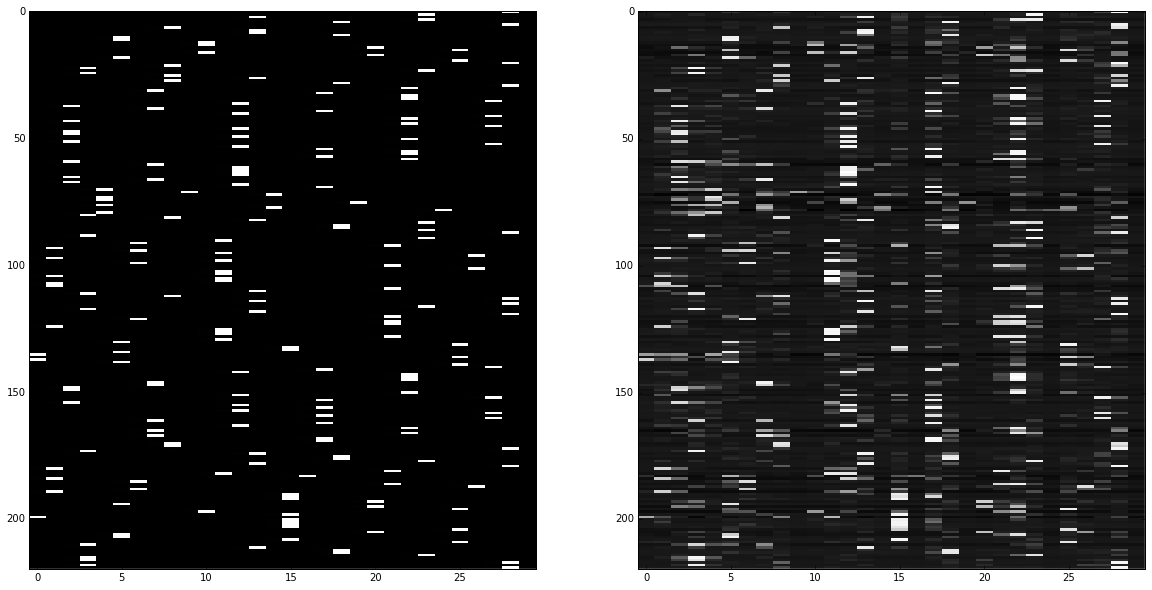

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9749 - val_loss: 2.8958


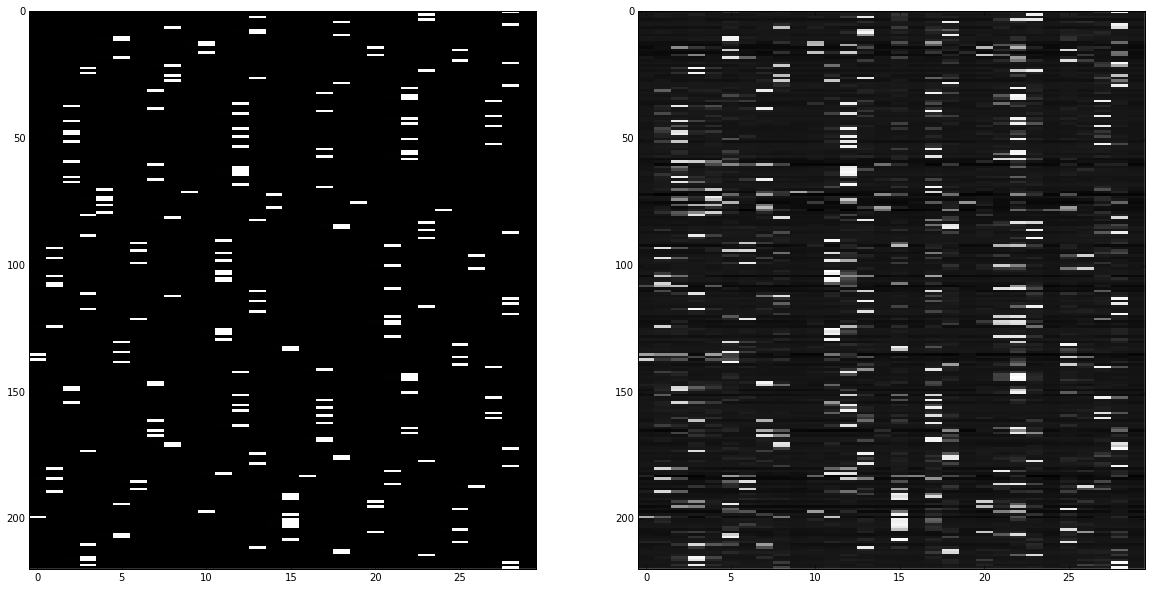

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9816 - val_loss: 2.8585


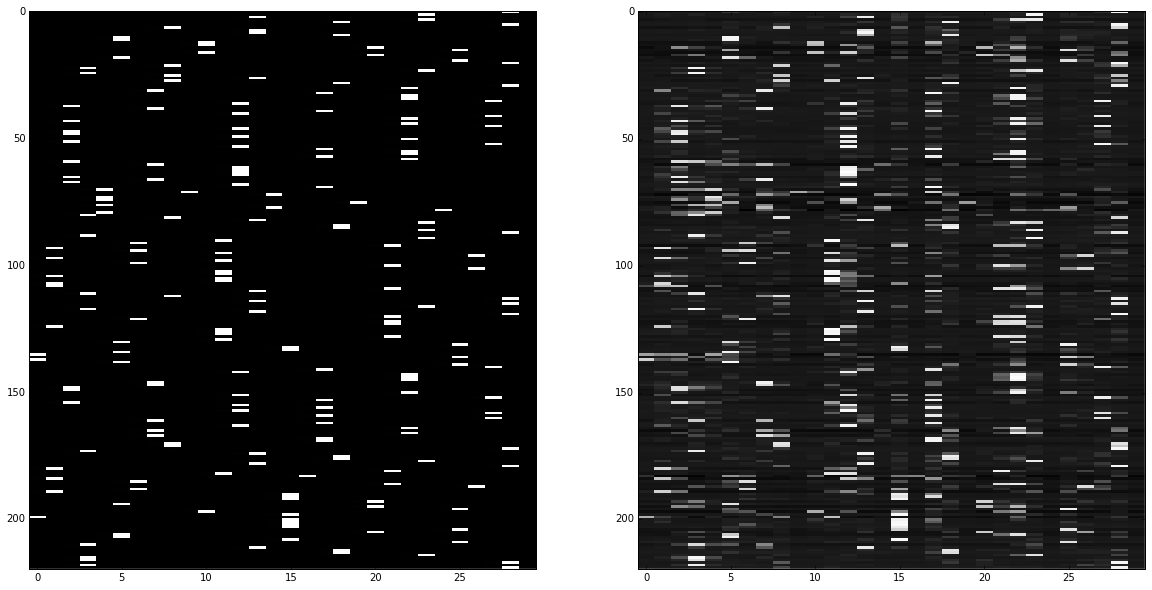

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9405 - val_loss: 2.9103


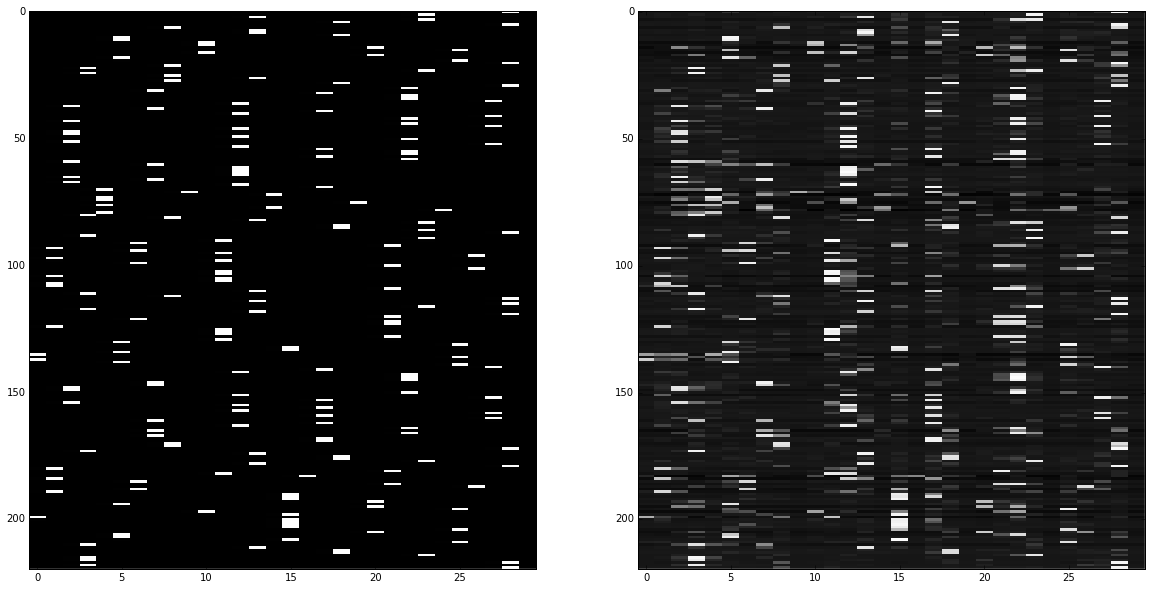

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9585 - val_loss: 2.9055


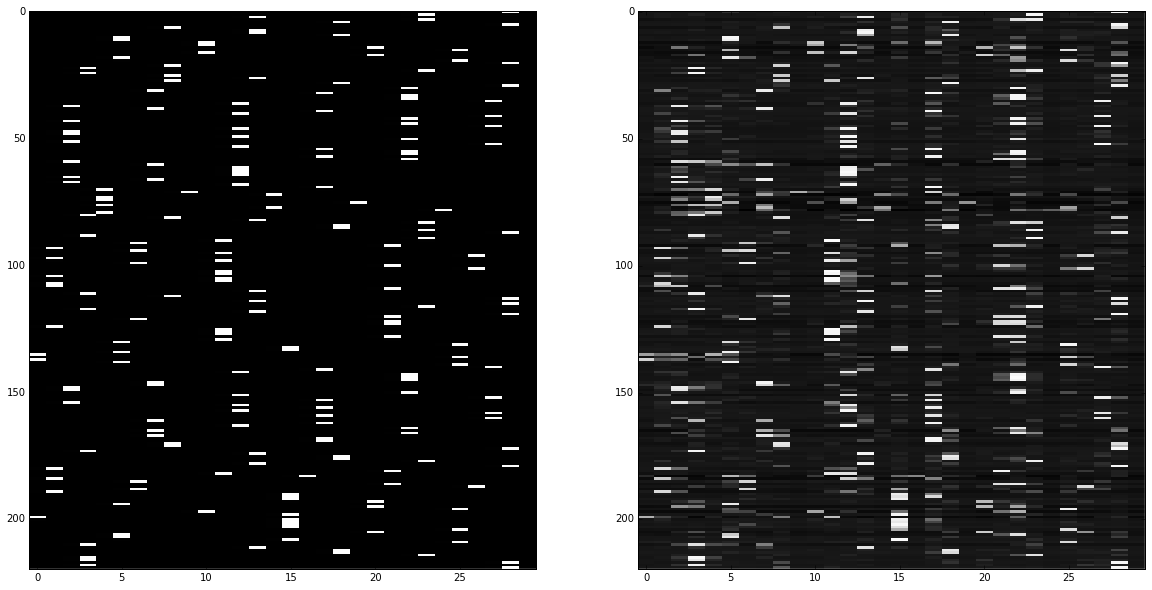

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9551 - val_loss: 2.9164


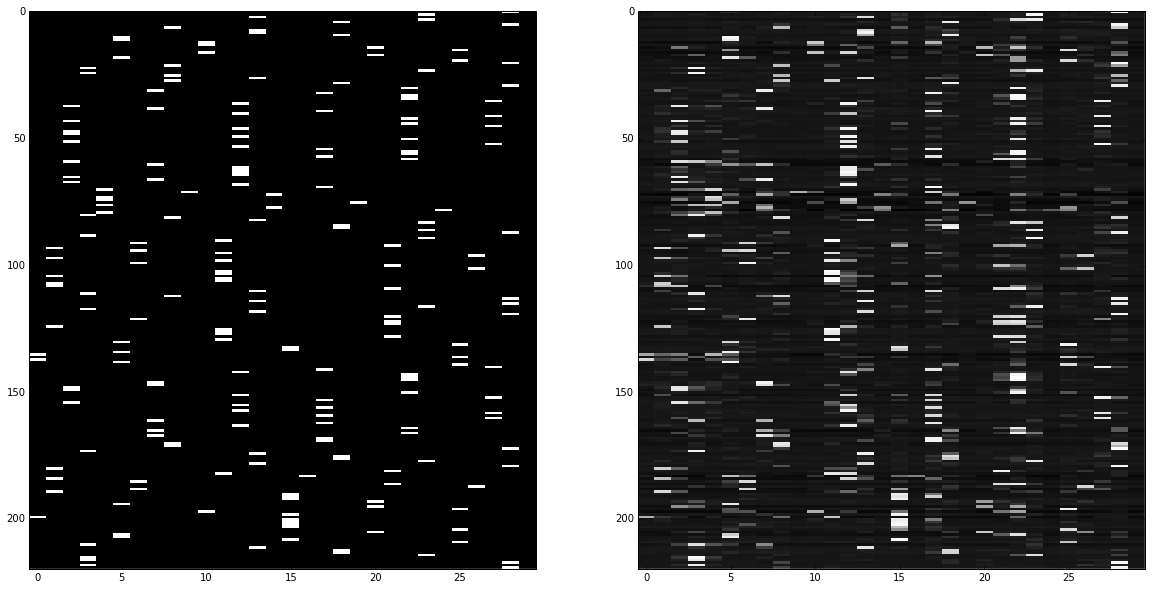

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9735 - val_loss: 2.8387


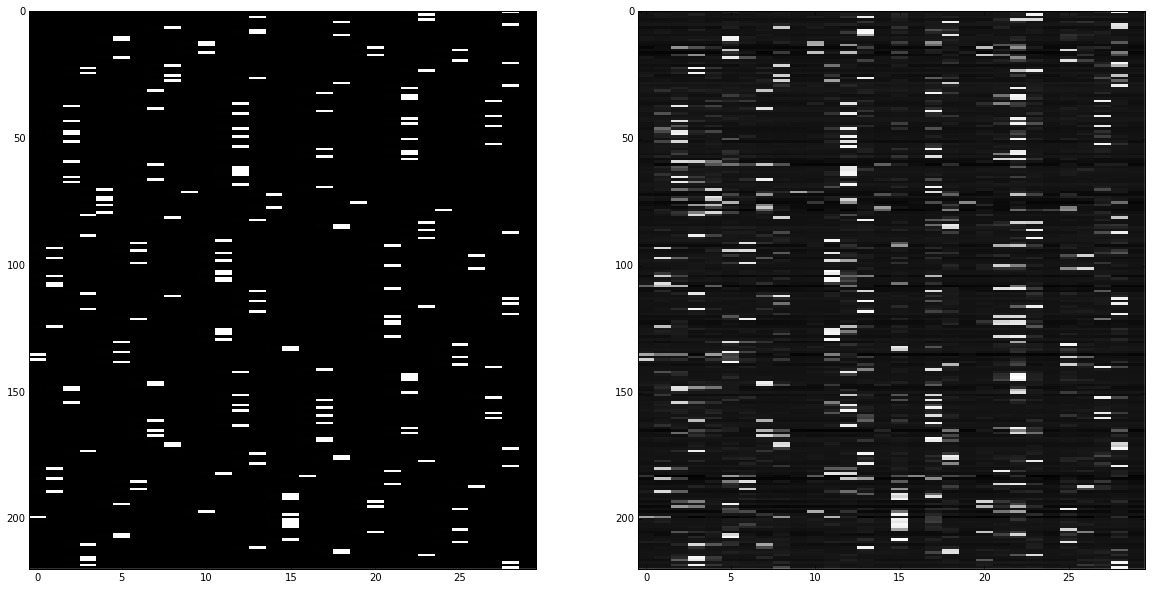

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9860 - val_loss: 2.7391


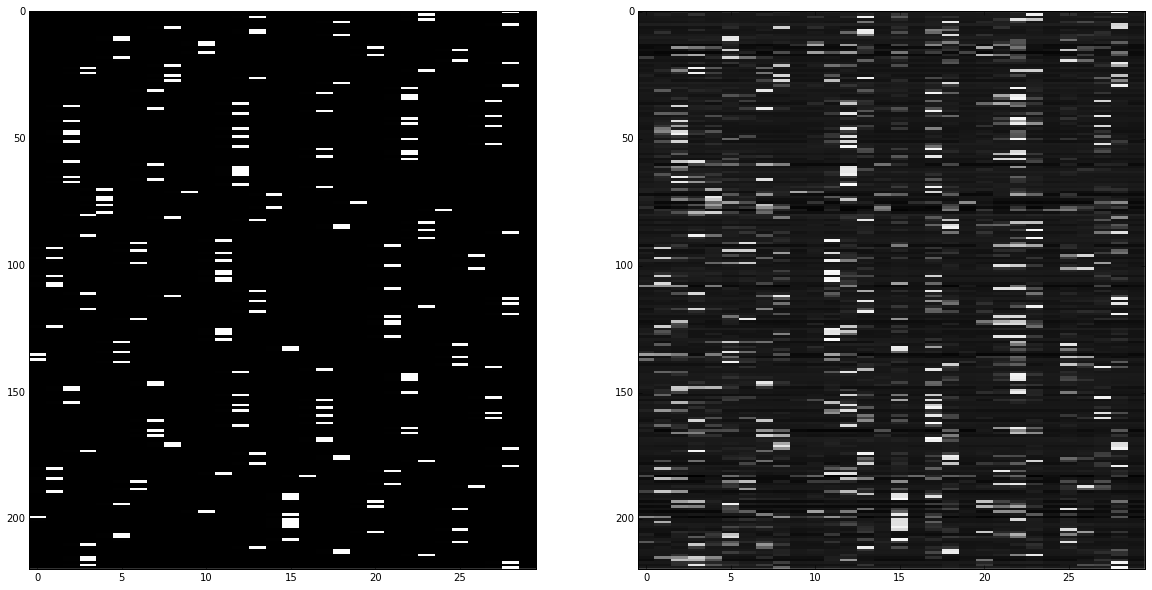

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9889 - val_loss: 2.8070


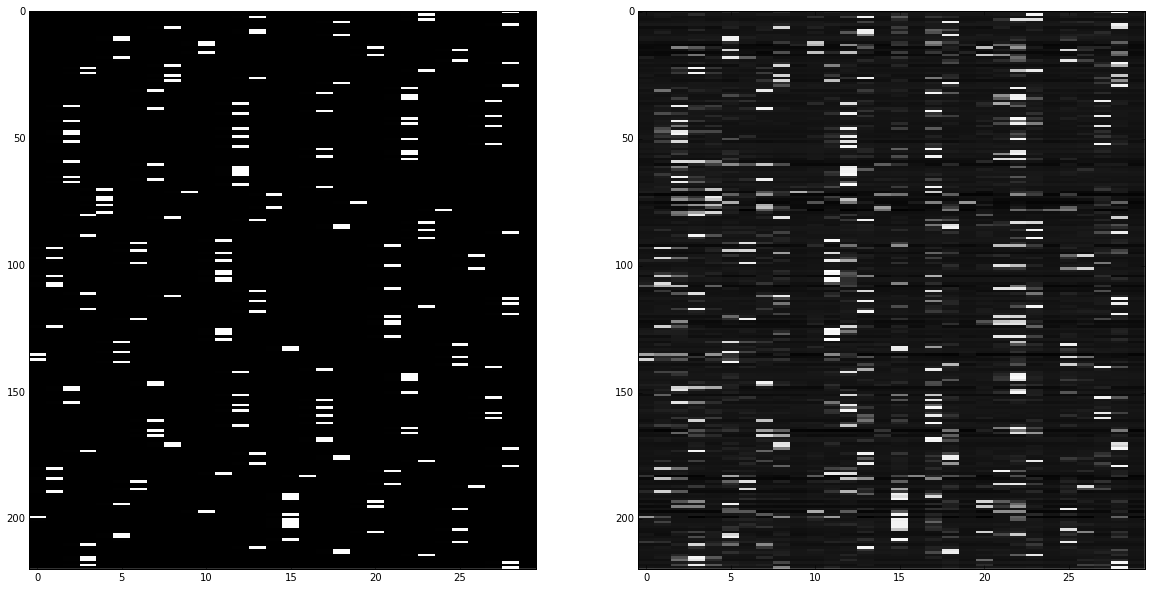

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9049 - val_loss: 2.8566


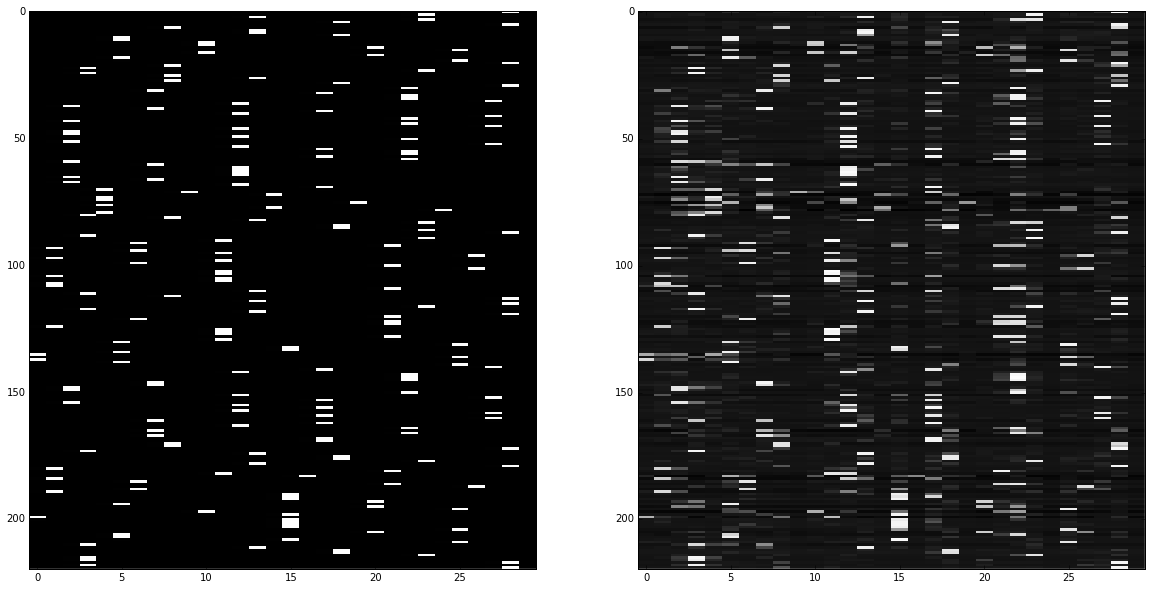

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9047 - val_loss: 2.8713


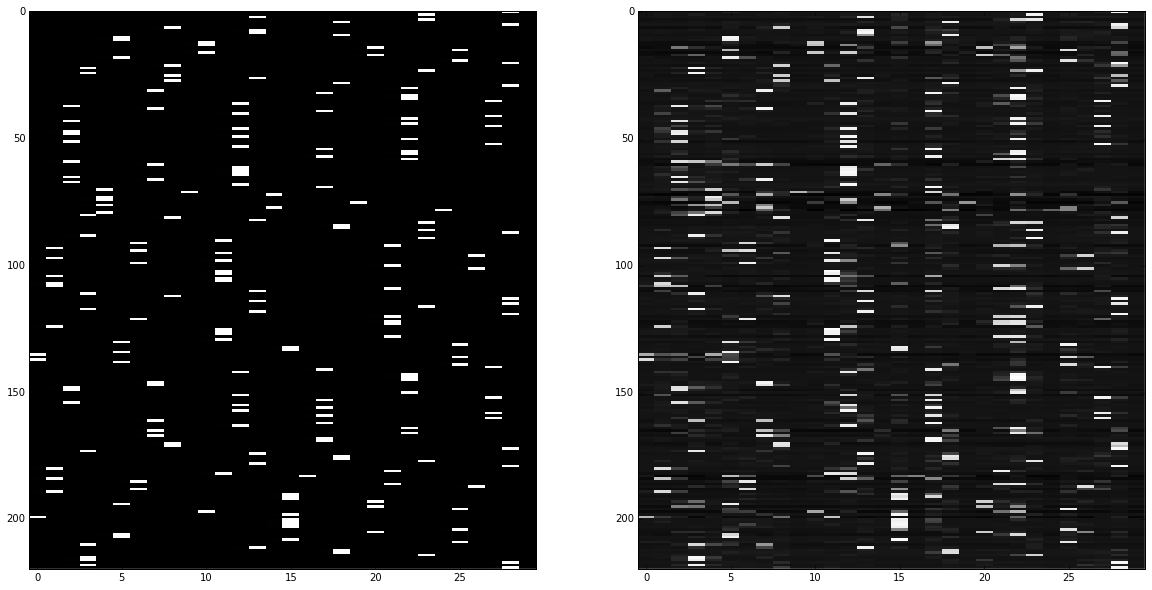

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9220 - val_loss: 2.8518


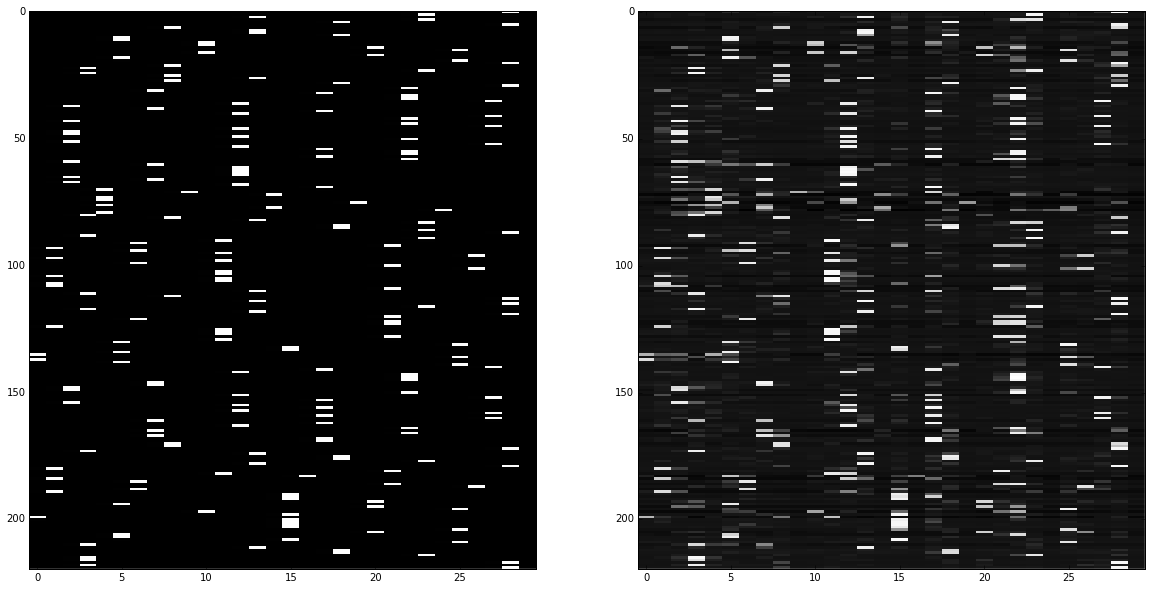

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9055 - val_loss: 2.8715


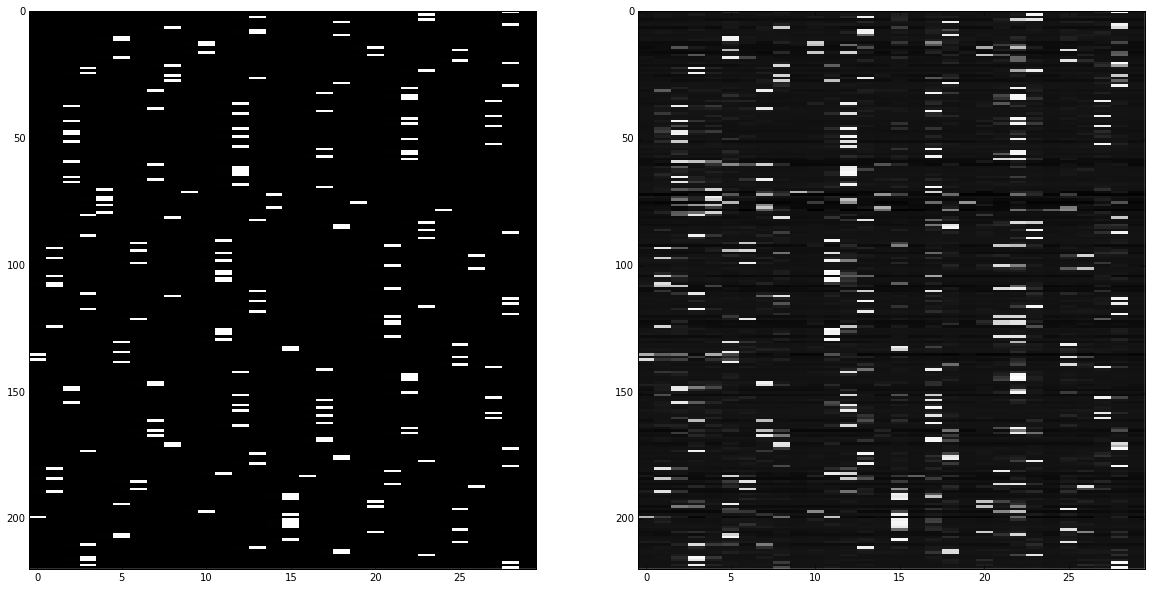

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9089 - val_loss: 2.9009


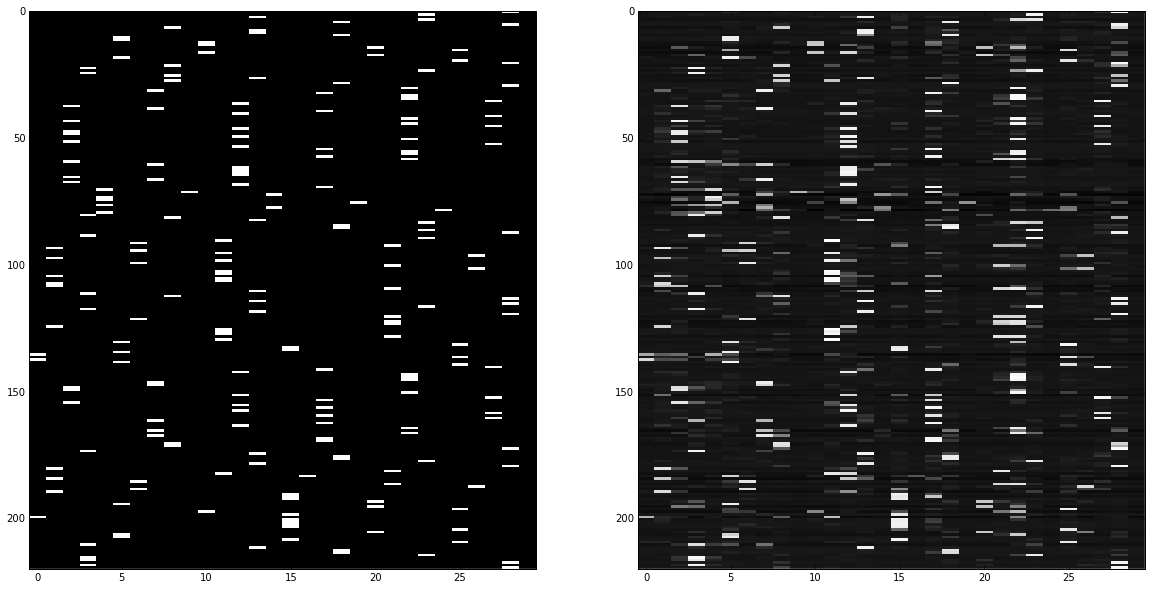

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9094 - val_loss: 2.8557


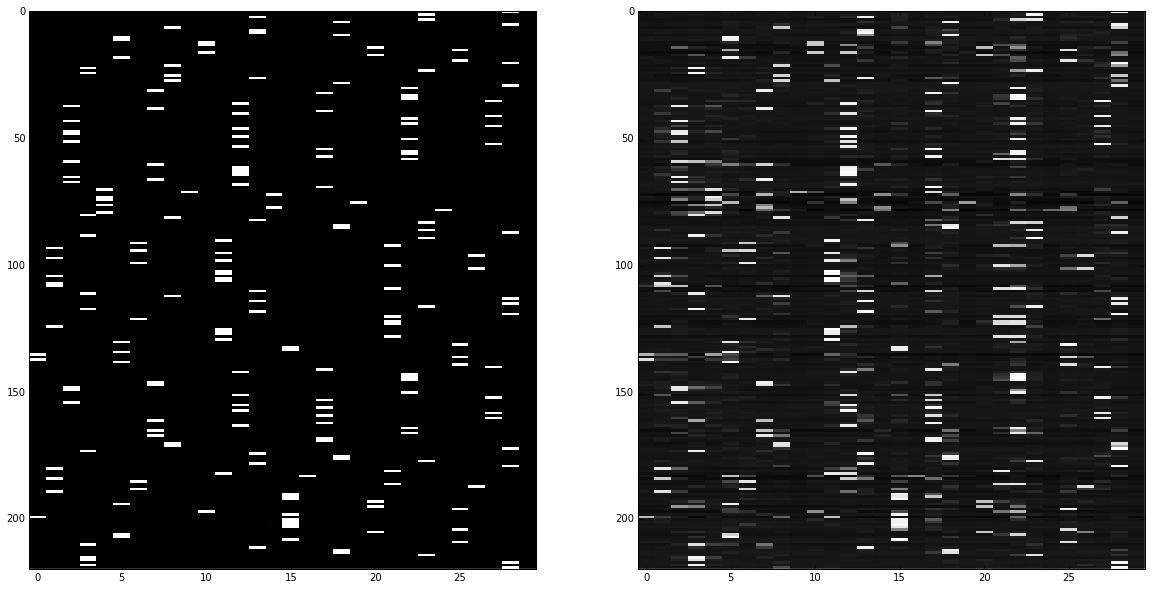

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8964 - val_loss: 2.8207


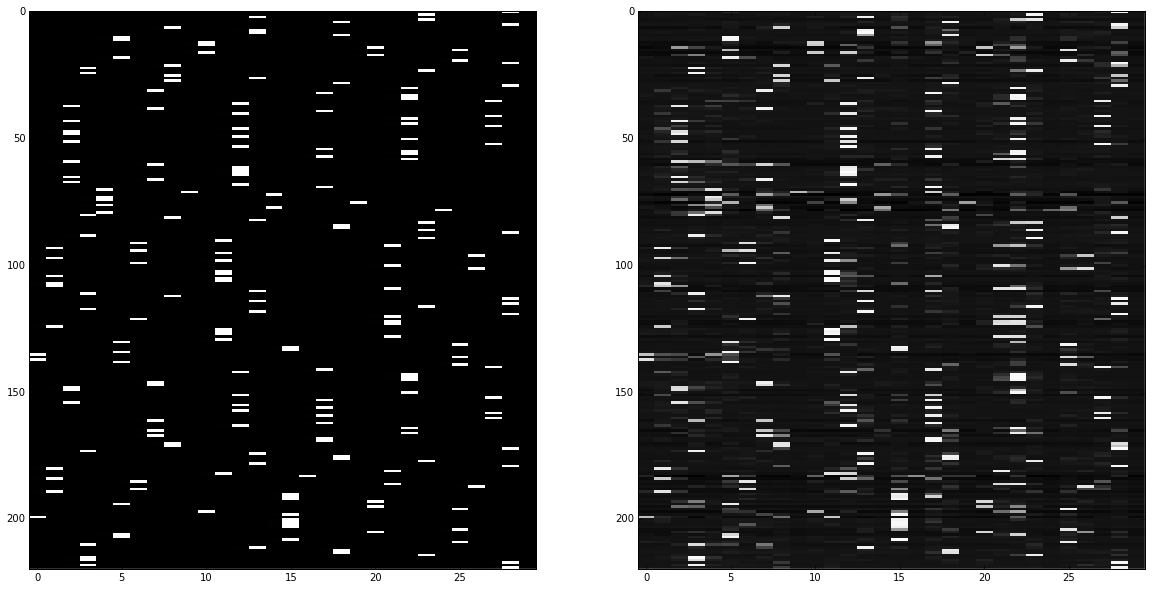

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8750 - val_loss: 2.8598


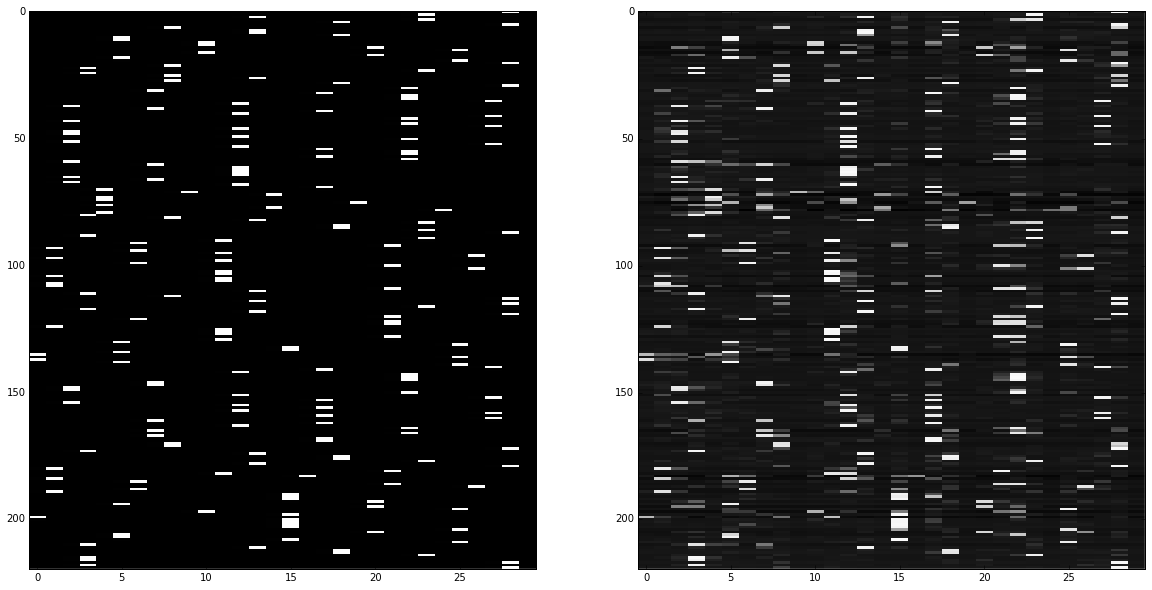

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8529 - val_loss: 2.8289


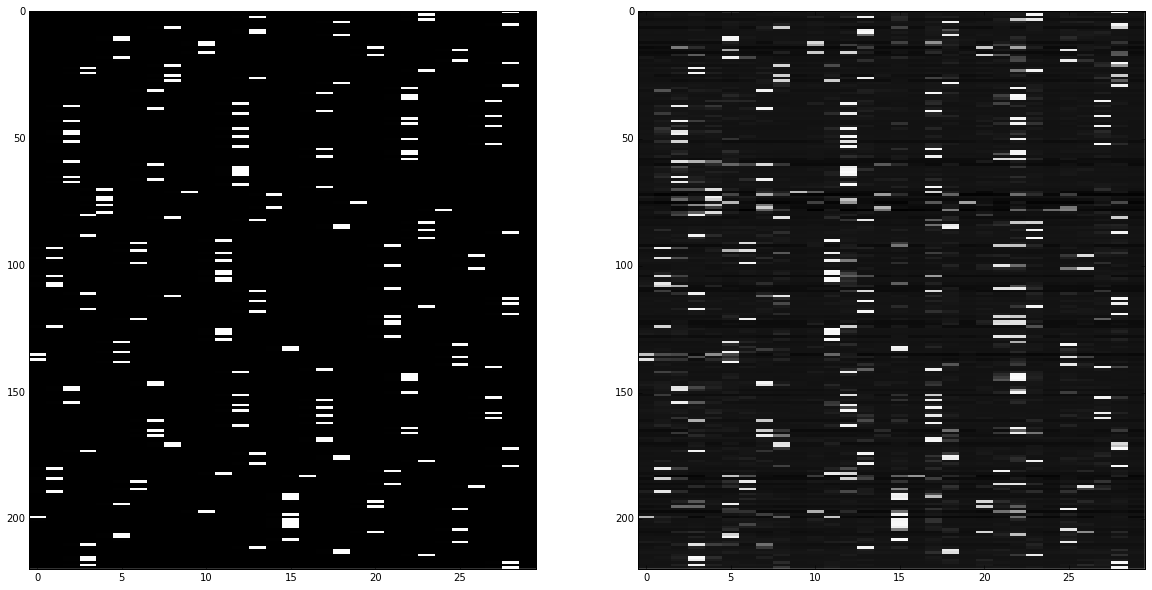

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8619 - val_loss: 2.8312


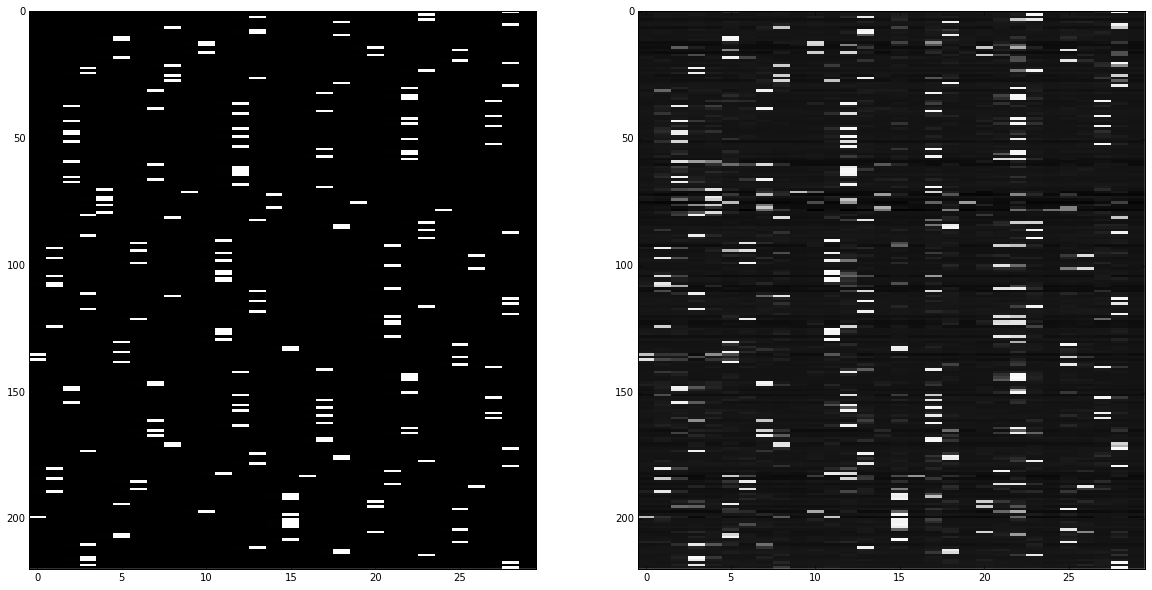

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8749 - val_loss: 2.8691


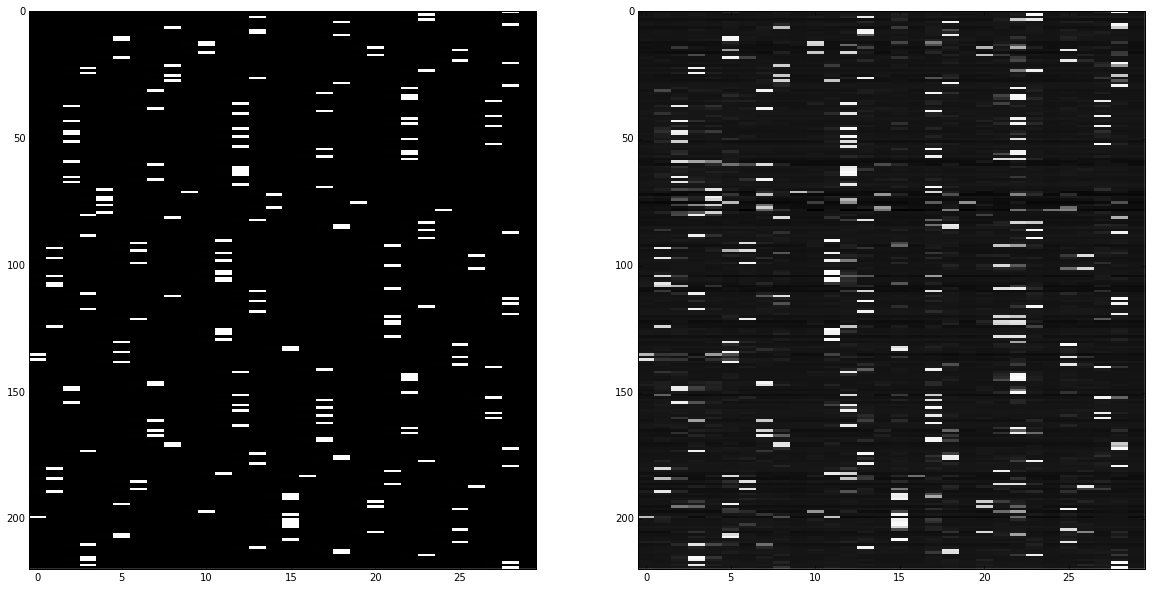

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9022 - val_loss: 2.8271


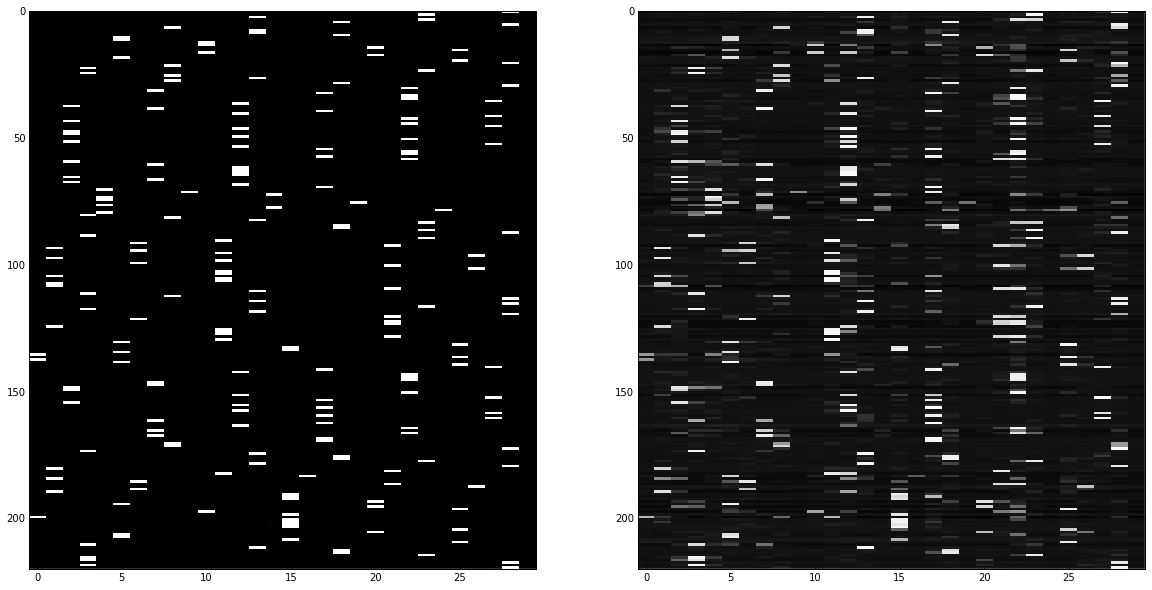

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.9371 - val_loss: 2.7407


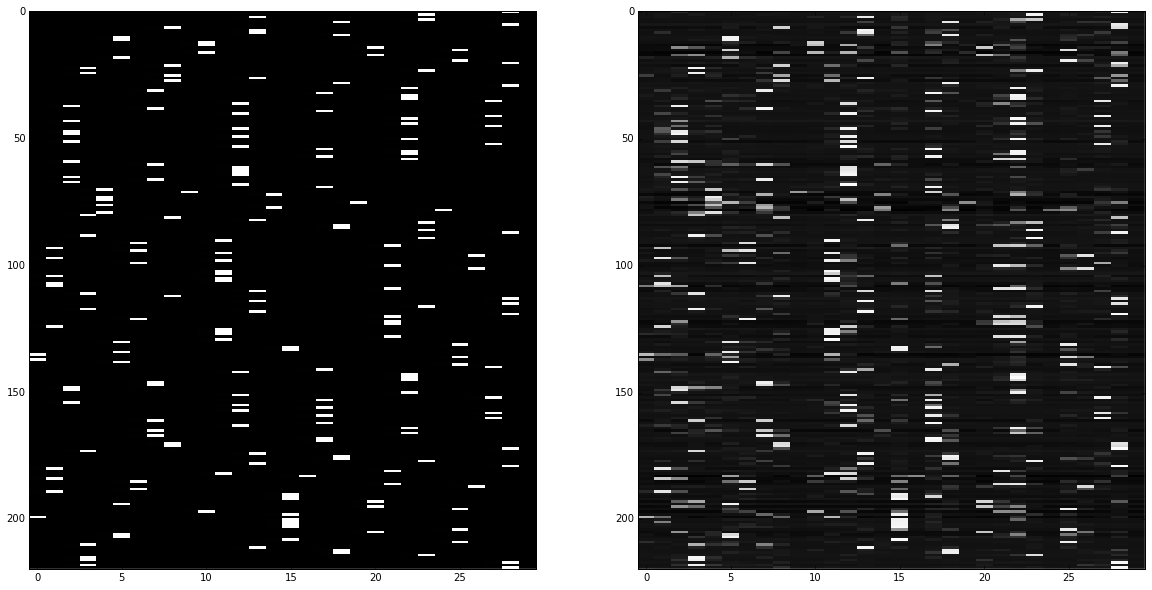

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8886 - val_loss: 2.7605


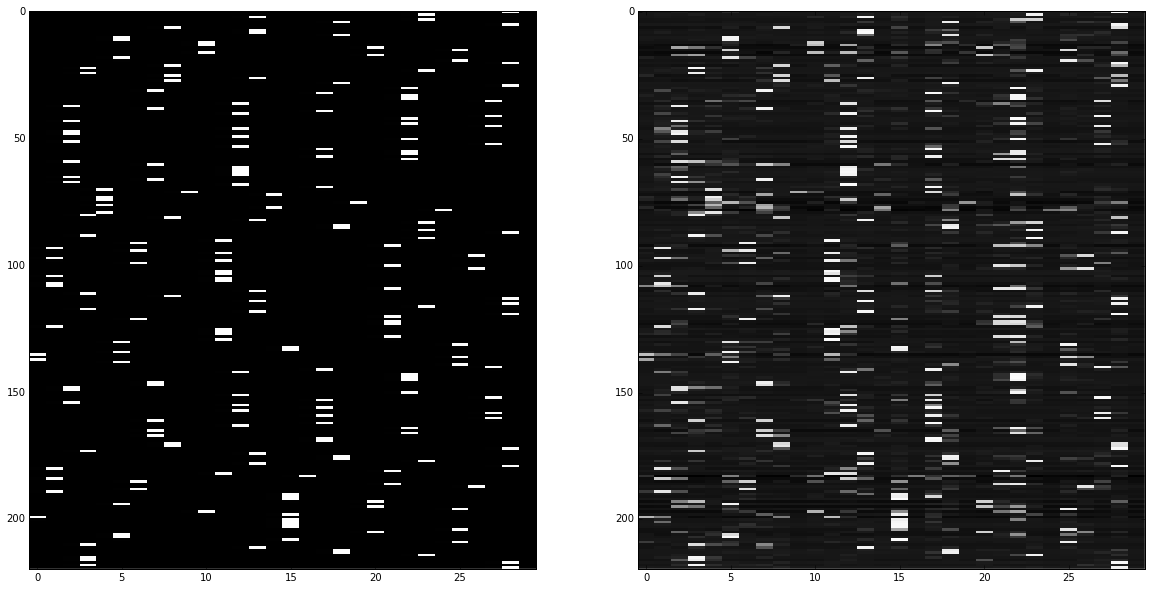

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8542 - val_loss: 2.7925


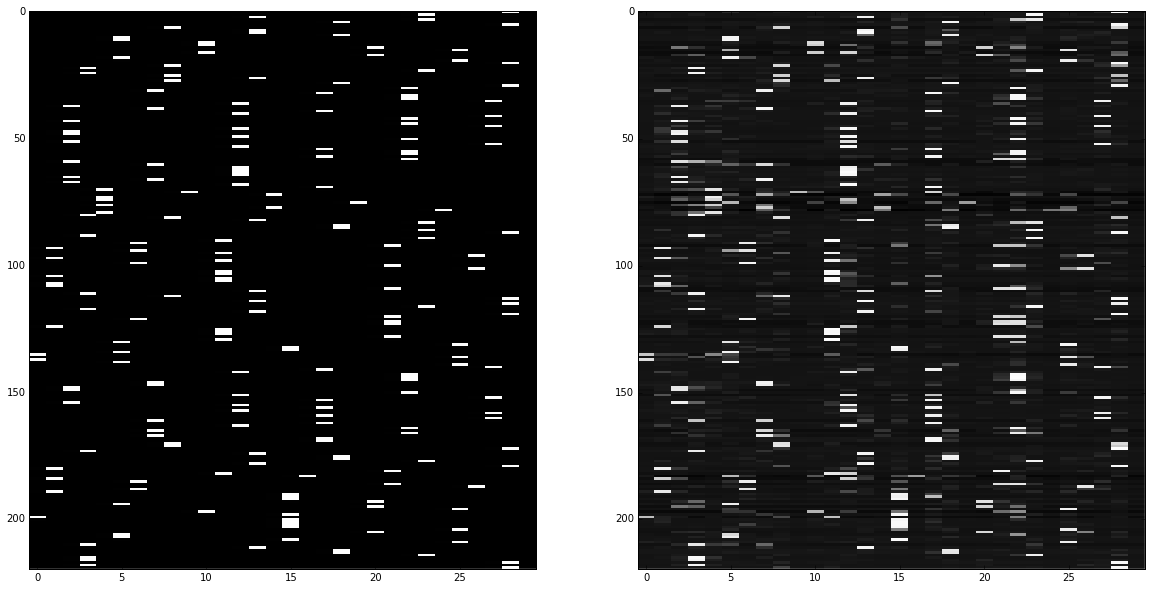

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8230 - val_loss: 2.8002


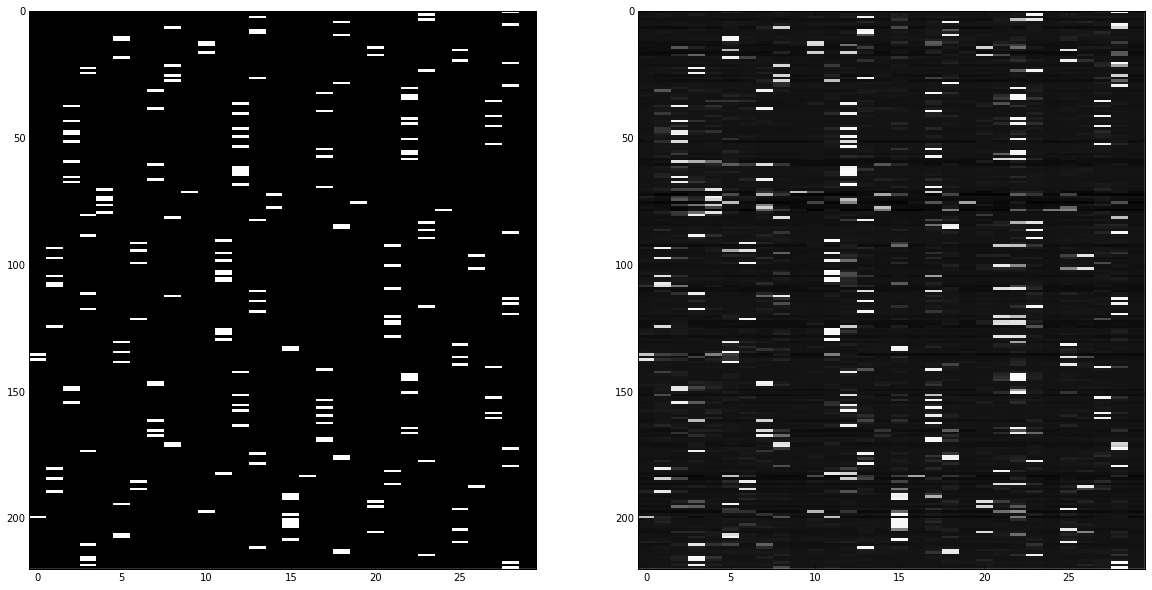

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8149 - val_loss: 2.8044


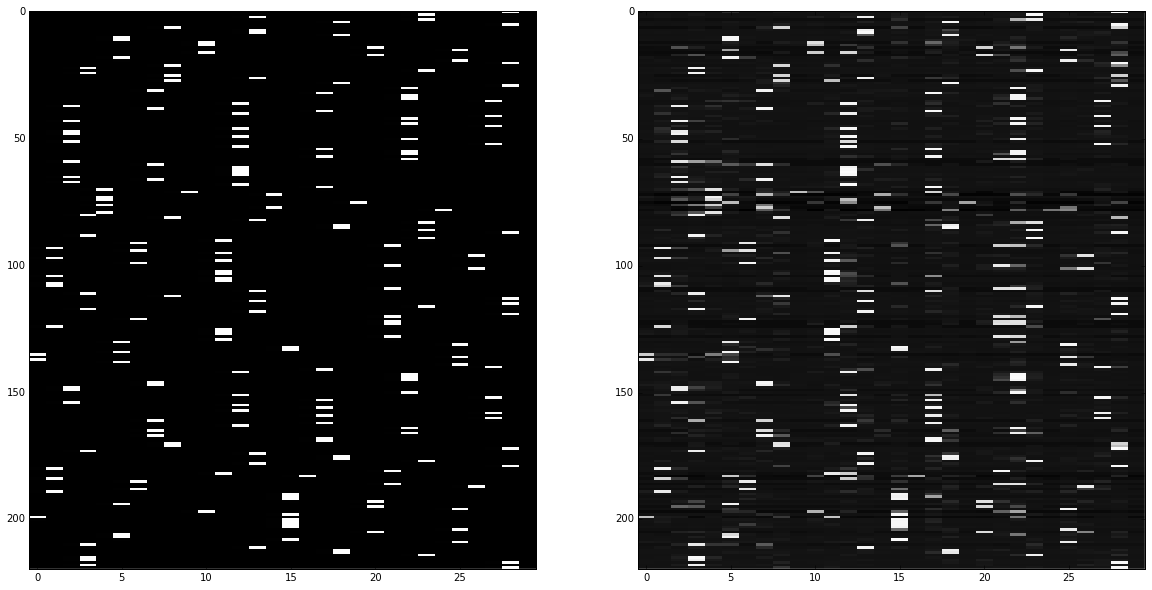

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8276 - val_loss: 2.8442


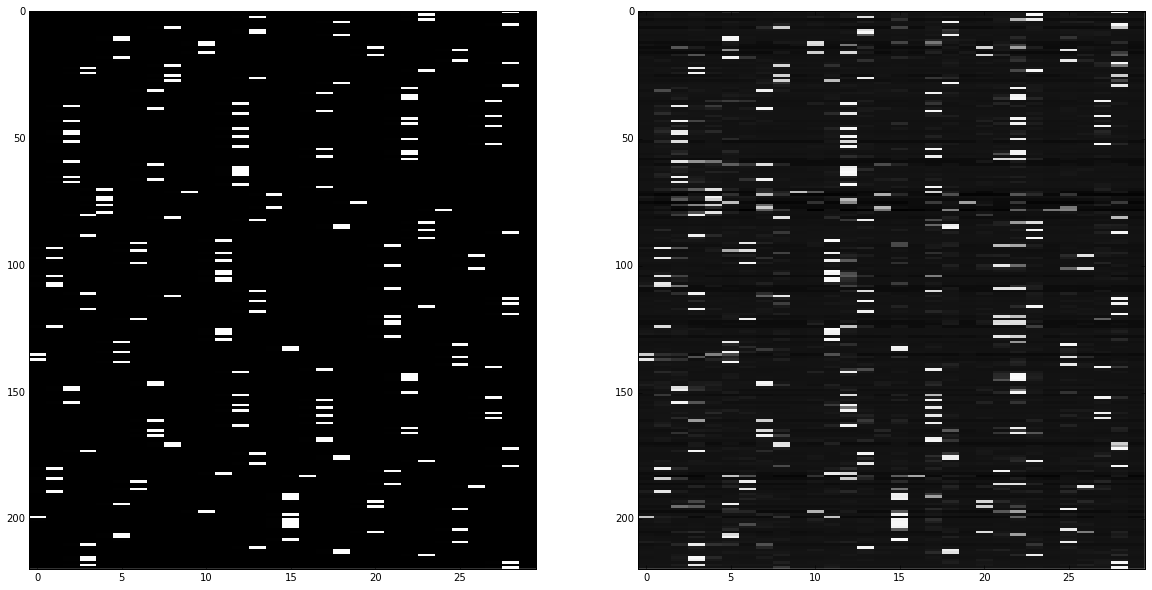

Train on 220 samples, validate on 19 samples
Epoch 1/1
220/220 [==============================] - 14s - loss: 1.8293 - val_loss: 2.8222


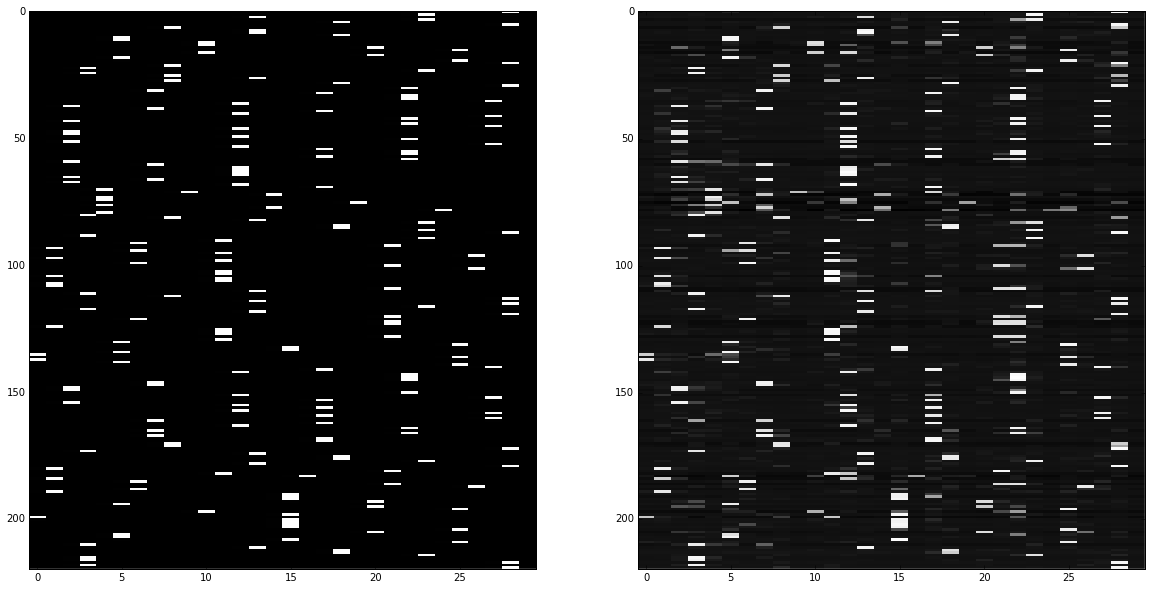

In [10]:
%matplotlib inline

results = []
for subject_name in data_set_locations:
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    
    subject_results = dict()
    for i in range(1):
        g.set_weights(original_weights)
        down_sample_param = 8
        shuffeled_samples, suffule_tags = create_train_data(gcd_res, down_samples_param=down_sample_param)
        shuffeled_samples = stats.zscore(shuffeled_samples, axis=1)
        print shuffeled_samples.shape
        print shuffeled_samples.reshape(-1,30,25,55).shape
        print shuffeled_samples.reshape(-1,30,25,55)[0,0,:,:].shape
        
        
        train_input_dictionary = dict([('input_{0}'.format(i) ,shuffeled_samples.reshape(-1,30,25,55)[:,i,:,:][0:-20]) for i in range(30)])
        train_input_dictionary['output'] = suffule_tags[:,1].reshape(-1,30)[0:-20]
        print "train input size {0}".format(shuffeled_samples.shape)
        validation_input_dictionary = dict([('input_{0}'.format(i) ,shuffeled_samples.reshape(-1,30,25,55)[-30:,i,:,:][-20:-1]) for i in range(30)])
        validation_input_dictionary['output'] = suffule_tags[:,1].reshape(-1,30)[-20:-1]
        print "--------------"
        
        print train_input_dictionary['output'].shape
        print "--------------"
        checkpointer = ModelCheckpoint(filepath=r"c:\temp\25_dec_lstm_with_ds_2.hdf5", verbose=1, save_best_only=True)
        import matplotlib.cm as cm
        for j in range(100):
            plt.figure(figsize=(20,10))
            g.fit(train_input_dictionary, verbose=1, nb_epoch=1, validation_data=validation_input_dictionary, callbacks=[checkpointer])
            prediction_res = g.predict(train_input_dictionary)
            plt.subplot(1,2,1)
            plt.imshow(train_input_dictionary['output'], cmap=cm.Greys_r, interpolation='none', aspect='auto')
            plt.subplot(1,2,2)
            plt.imshow(prediction_res['output'], cmap=cm.Greys_r, interpolation='none', aspect='auto')
            plt.show()
            
        break
    #         print np.max(np.abs(shuffeled_samples.reshape(-1,30,25,55)[1,1,:,:] - shuffeled_samples[31,:,:]))
    #         print suffule_tags[:,1].reshape(-1,30)[:5,:]
        
        test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)
        print np.sum(test_target_gcd.reshape(-1,30), axis=1)
        test_input_dictionary = dict([('input_{0}'.format(i) ,test_data_gcd.reshape(-1,30,25,55)[:,i,:,:]) for i in range(30)])
        prediction_res = g.predict(train_input_dictionary)
        print "----"
        print np.argmax(prediction_res['output'] , axis=1)
        print prediction_res['output'].shape
        print np.argmax(suffule_tags[:,1].reshape(-1,30), axis=1)
        plt.imshow(train_input_dictionary['output'], )
#         plt.tight_layout()
        plt.show()
        plt.imshow(prediction_res['output'])
#         plt.tight_layout()
        plt.show()
        
        print np.array(np.argmax(prediction_res['output'] , axis=1) == np.argmax(suffule_tags[:,1].reshape(-1,30)[0:-20], axis=1), dtype=np.int).reshape(-1,10)
        
        
        break
        sss = list(StratifiedShuffleSplit(suffule_tags[:, 0], n_iter=1, test_size=0.1))
        checkpointer = ModelCheckpoint(filepath=r"c:\temp\25_dec_lstm_with_ds_2.hdf5", verbose=1, save_best_only=True)
        print shuffeled_samples[sss[0][0]].shape
        print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).shape
        model.fit(stats.zscore(shuffeled_samples[sss[0][0]], axis=1), suffule_tags[sss[0][0]],
                  nb_epoch=20, show_accuracy=True, verbose=1, validation_data=(
            stats.zscore(shuffeled_samples[sss[0][1]], axis=1), suffule_tags[sss[0][1]]),
                  class_weight={0: 1, 1: 50},
                  callbacks=[checkpointer])





        test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)

        test_prediction = model.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)

        x, y, _ = roc_curve(test_target_gcd, test_prediction[:, 1])



        # This is the ROC curve
        # plt.plot(x, y)
        # plt.show()
        auc_score = roc_auc_score(test_target_gcd, test_prediction[:, 1])
        print "auc_score:{0}".format(auc_score)
        sub_gcd_res = create_data_for_compare_by_repetition(file_name)
        # sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
        # train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
        # stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

        _, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
        _, _, actual_data_for_sum = create_target_table(sub_gcd_res, test_prediction[:, 1])
        subject_results[i] = dict(test_prediction=test_prediction, 
                                  auc_score=auc_score,
                                  acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

        print "accuracy_by_repetition {0}".format(
            accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

    results.append(dict(subject_name=subject_name, subject_results=subject_results))
    break


In [4]:
# np.save(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\ipytho_notebook\reports\6_feb_2016_explore_LSTM.npy',results)
[(sub['subject_name'], [sub['subject_results'][i]['acc_by_rep'] for i in range(4) ]) for sub in results]


[('RSVP_Color116msVPicr.mat',
  [0.9736842105263158,
   0.9473684210526315,
   0.8947368421052632,
   0.9473684210526315]),
 ('RSVP_Color116msVPpia.mat',
  [0.8444444444444444,
   0.7777777777777778,
   0.8222222222222222,
   0.7777777777777778]),
 ('RSVP_Color116msVPfat.mat',
  [0.9736842105263158, 1.0, 0.9473684210526315, 0.9736842105263158]),
 ('RSVP_Color116msVPgcb.mat',
  [0.8048780487804879,
   0.8048780487804879,
   0.7560975609756098,
   0.7804878048780488]),
 ('RSVP_Color116msVPgcc.mat',
  [0.918918918918919,
   0.8918918918918919,
   0.8918918918918919,
   0.9459459459459459]),
 ('RSVP_Color116msVPgcd.mat',
  [0.8260869565217391,
   0.8260869565217391,
   0.717391304347826,
   0.7391304347826086]),
 ('RSVP_Color116msVPgcf.mat',
  [0.9473684210526315,
   0.9473684210526315,
   0.9736842105263158,
   0.9473684210526315]),
 ('RSVP_Color116msVPgcg.mat',
  [0.7608695652173914,
   0.8043478260869565,
   0.8695652173913043,
   0.8260869565217391]),
 ('RSVP_Color116msVPgch.mat',
  [0

In [32]:
results

[{'subject_name': 'RSVP_Color116msVPicr.mat',
  'subject_results': {0: {'acc_by_rep': 0.8333333333333334,
    'auc_score': 0.86468444018731372,
    'test_prediction': array([[ 0.84226179,  0.15773819],
           [ 0.86728626,  0.13271372],
           [ 0.95803291,  0.04196712],
           ..., 
           [ 0.99279225,  0.00720776],
           [ 0.97658044,  0.02341963],
           [ 0.59612763,  0.40387237]])},
   1: {'acc_by_rep': 0.9444444444444444,
    'auc_score': 0.88640059599829712,
    'test_prediction': array([[ 0.98302346,  0.01697655],
           [ 0.96586055,  0.03413945],
           [ 0.97163624,  0.02836375],
           ..., 
           [ 0.99284935,  0.00715065],
           [ 0.50014472,  0.49985528],
           [ 0.92243224,  0.07756776]])},
   2: {'acc_by_rep': 1.0,
    'auc_score': 0.88121913580246902,
    'test_prediction': array([[ 0.92694533,  0.07305466],
           [ 0.95512652,  0.04487346],
           [ 0.96301597,  0.03698402],
           ..., 
           [ 0

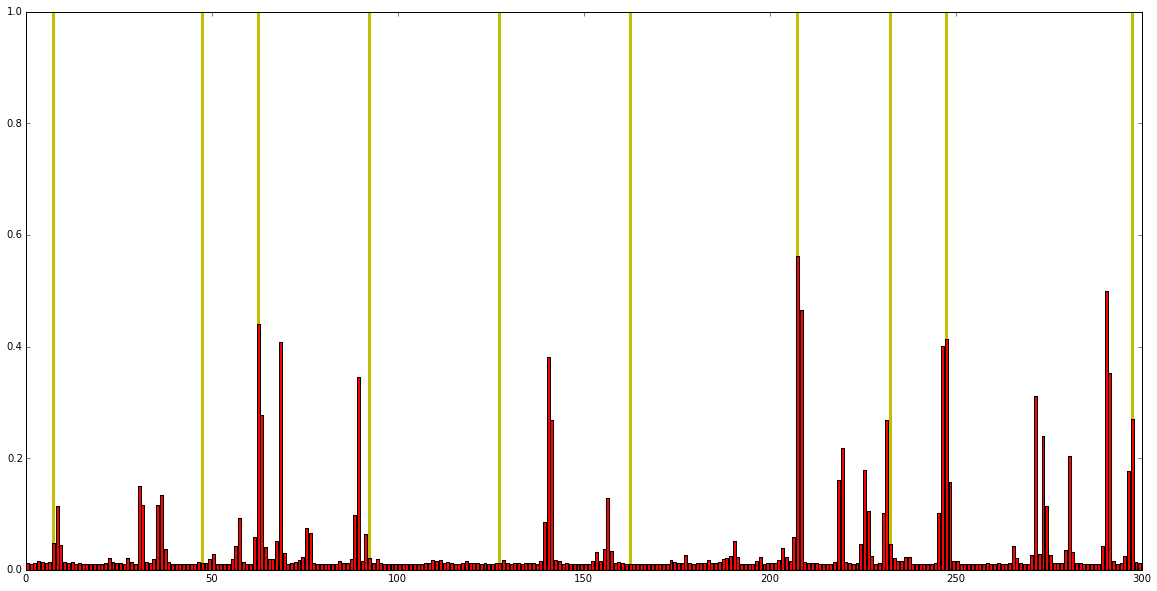

In [14]:
%matplotlib inline 
# %matplotlib qt 
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
plt.bar(range(300), test_target_gcd[0:300], color='y', edgecolor = "none")
plt.bar(range(300), test_prediction[0:300,1], color='r')
plt.show()




In [37]:
%matplotlib qt 
import matplotlib.cm as cm
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(test_target_gcd[0:300].reshape(-1,30), cmap = cm.Greys_r, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(test_prediction[0:300, 1].reshape(-1,30), cmap = cm.Greys_r, interpolation='none')

plt.show()
plt.tight_layout()

In [59]:
plt.plot(test_target_gcd[70:80])
print test_target_gcd[74]
print test_prediction[:,1][74]

1
0.054335616529


In [5]:
for i in range(1,11):
    print "{0}:{1}".format(i, accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=i))

1:0.152173913043
2:0.195652173913
3:0.260869565217
4:0.347826086957
5:0.521739130435
6:0.608695652174
7:0.586956521739
8:0.652173913043
9:0.717391304348
10:0.673913043478


In [9]:
import theano
result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,1])
# convolutions = convout1_f(reshaped[img_to_visualize: img_to_visualize+1])

In [10]:
# result_func.grad
from theano import tensor as T
grad_func = T.grad(model.layers[-1].get_output(train=False)[0,1], model.get_input(train=False) )


In [11]:
result_func(stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,100,55)).shape
# print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,40,55).shape

dlogistic = theano.function([model.get_input(train=False)], grad_func)



DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpplsori/a6c816eba9a8d2dc1e4389ccc1f6a757.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpplsori/a6c816eba9a8d2dc1e4389ccc1f6a757.exp



sample#72: target:0, probability_prediction:0.012906966731


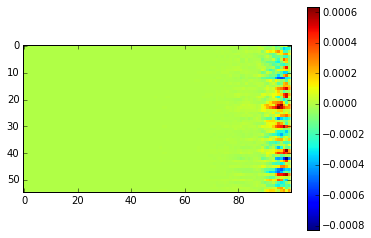

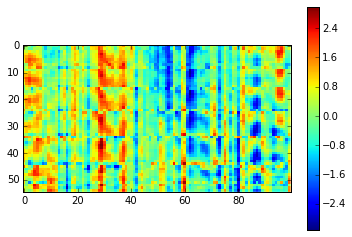

sample#73: target:0, probability_prediction:0.0175742246211


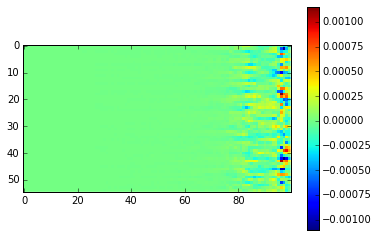

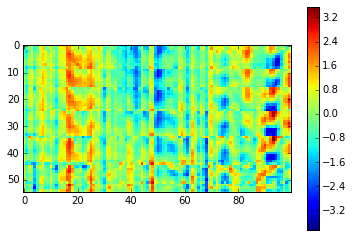

sample#74: target:1, probability_prediction:0.227026358247


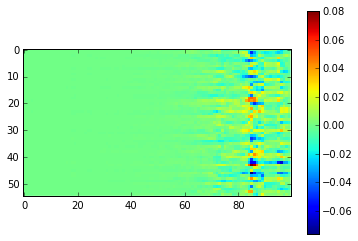

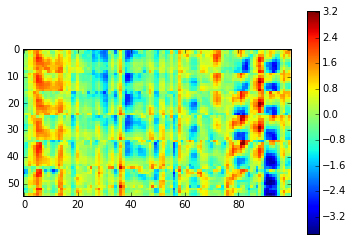

sample#75: target:0, probability_prediction:0.18259011209


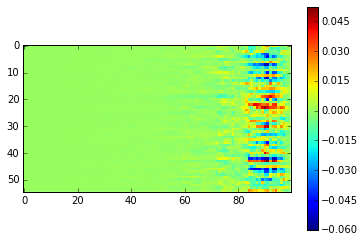

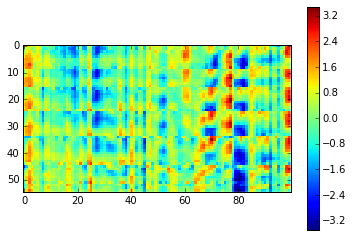

sample#76: target:0, probability_prediction:0.0220258478075


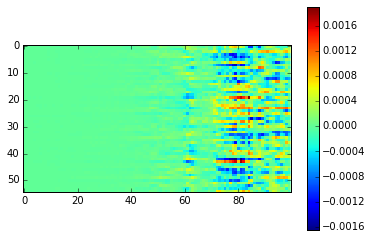

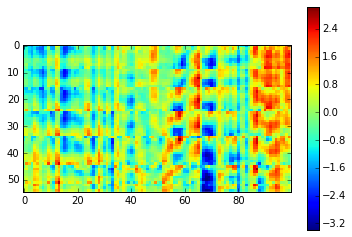

In [15]:
%matplotlib inline

for sample_i in [72,73,74,75,76]:
#     print test_prediction[sample_i,1 ]
    print "sample#{2}: target:{0}, probability_prediction:{1}".format(test_target_gcd[sample_i], test_prediction[sample_i,1 ], sample_i)
    data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[sample_i].reshape(1,100,55)
    
    temp = dlogistic(data_to_diagnots)
    temp.shape
    plt.imshow(temp[0,:,:].T, interpolation='none')
    plt.colorbar()
    plt.show()
    
    plt.imshow(data_to_diagnots[0,:,:].T, interpolation='none')
    plt.colorbar()
    plt.show()




In [41]:
model.layers[-1].get_output(train=False)[0]

# >>> x = T.dmatrix('x')
# >>> s = T.sum(1 / (1 + T.exp(-x)))
# >>> gs = T.grad(s, x)

Subtensor{int64}.0

In [43]:
result_func[0,:]

TypeError: unhashable type

In [57]:

x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = theano.function([x, y], z[:,0])

In [58]:
f(np.asarray([[1,2]]), np.asarray([[1,2]]))

array([ 2.])

In [66]:
 T.grad(z[:,0],x)

TypeError: cost must be a scalar.

In [127]:
np.where(test_prediction[:,1 ] > 0.12)


(array([   38,    74,    75,    76,   103,   104,   178,   183,   187,
          188,   256,   276,   277,   339,   358,   359,   370,   371,
          396,   425,   451,   477,   530,   566,   589,   590,   646,
          653,   692,   693,   694,   747,   770,   771,   789,   790,
          845,   846,   847,   888,   911,   912,   913,   956,   957,
          958,  1020,  1047,  1064,  1068,  1166,  1188,  1276,  1286,
         1357,  1360,  1362,  1407,  1426,  1494,  1495,  1551,  1603,
         1671,  1738,  1765,  1816,  1817,  1827,  1828,  1829,  1857,
         1858,  1924,  1925,  1926,  1927,  1947,  1948,  1997,  1998,
         2020,  2051,  2111,  2112,  2150,  2151,  2168,  2169,  2234,
         2235,  2236,  2269,  2270,  2271,  2305,  2307,  2318,  2360,
         2440,  2441,  2442,  2443,  2491,  2492,  2525,  2526,  2527,
         2566,  2587,  2612,  2680,  2715,  2716,  2758,  2784,  2785,
         2793,  2794,  2847,  2848,  2875,  2920,  2997,  3057,  3058,
      

In [106]:
np.where(test_target_gcd == 1)

(array([    4,    39,    74,   104,   149,   159,   194,   214,   264,
          284,   316,   341,   371,   396,   431,   476,   486,   526,
          566,   596,   608,   658,   678,   693,   723,   753,   788,
          823,   848,   893,   912,   957,   982,   992,  1047,  1057,
         1092,  1127,  1167,  1187,  1220,  1255,  1275,  1305,  1335,
         1365,  1395,  1425,  1460,  1495,  1524,  1534,  1579,  1604,
         1624,  1679,  1709,  1724,  1754,  1789,  1801,  1841,  1876,
         1901,  1946,  1966,  1986,  2016,  2051,  2096,  2110,  2150,
         2165,  2200,  2235,  2270,  2305,  2330,  2365,  2395,  2402,
         2442,  2472,  2492,  2527,  2567,  2607,  2612,  2657,  2692,
         2718,  2758,  2788,  2808,  2838,  2868,  2893,  2928,  2963,
         2988,  3010,  3055,  3060,  3095,  3130,  3165,  3195,  3215,
         3250,  3285,  3308,  3353,  3363,  3393,  3423,  3478,  3498,
         3538,  3568,  3578,  3617,  3647,  3682,  3702,  3722,  3767,
      

In [131]:
test_data_gcd.shape, test_target_gcd.shape


((13800L, 40L, 55L), (13800L,))

In [132]:
# result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,0])
model.layers

In [133]:
precalssify_layer = theano.function([model.get_input(train=False)], model.layers[0].get_output(train=False))

In [141]:
middle_layer_test_data = precalssify_layer(stats.zscore(test_data_gcd, axis=1).astype('float32'))

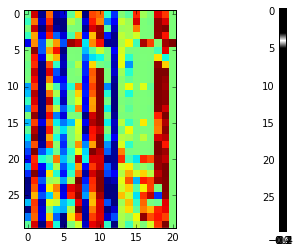

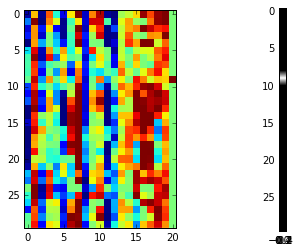

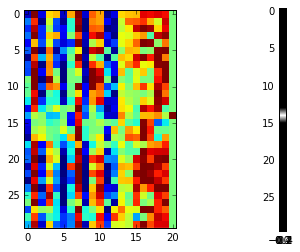

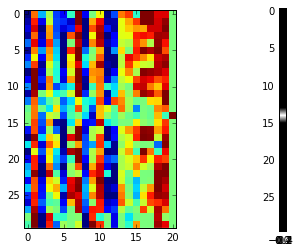

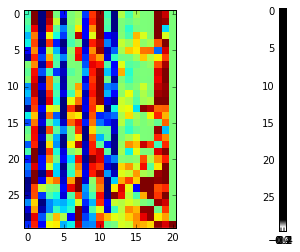

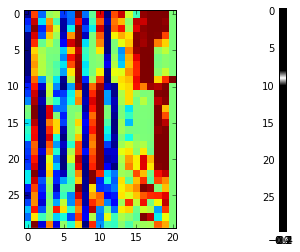

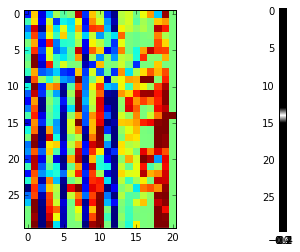

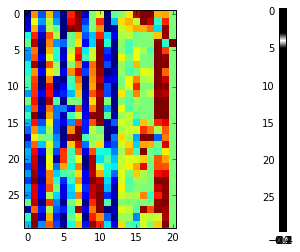

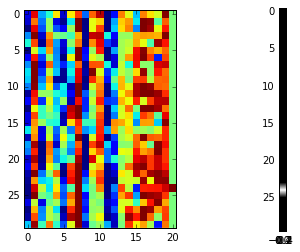

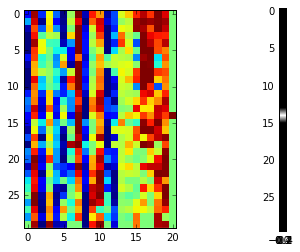

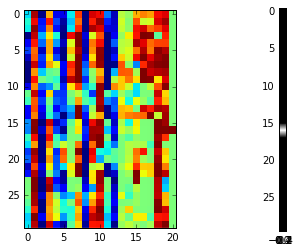

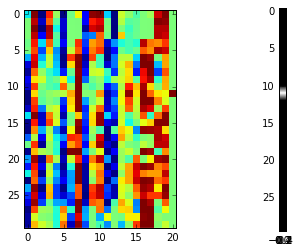

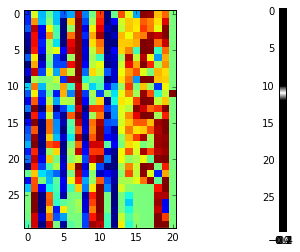

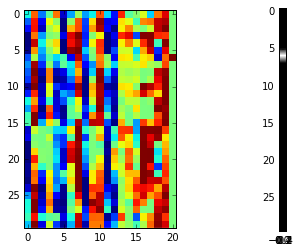

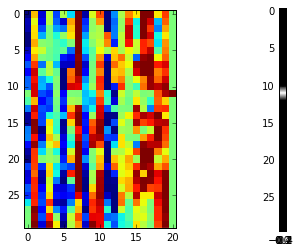

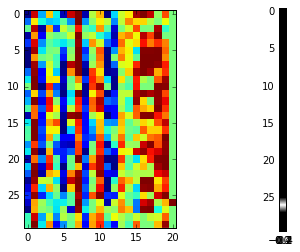

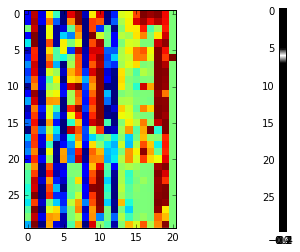

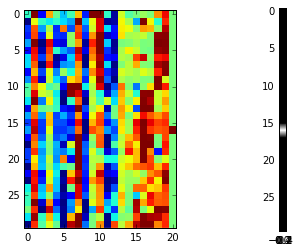

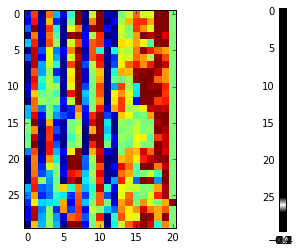

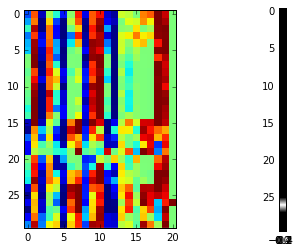

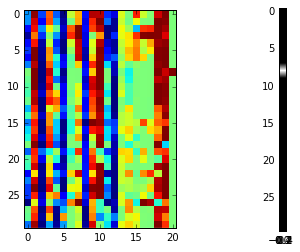

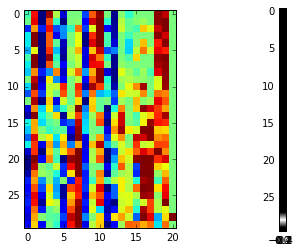

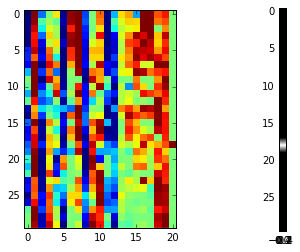

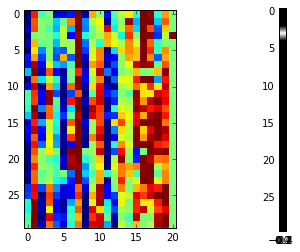

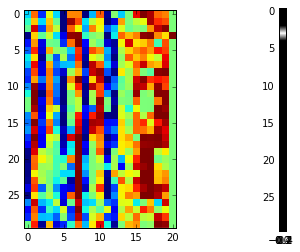

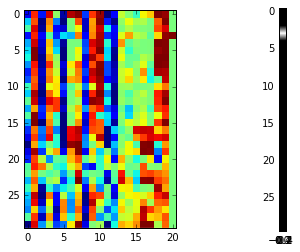

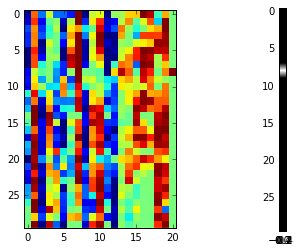

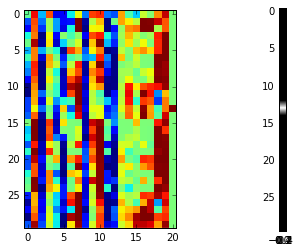

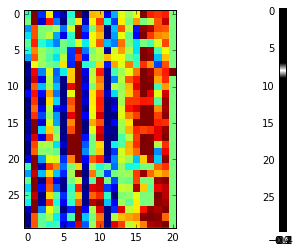

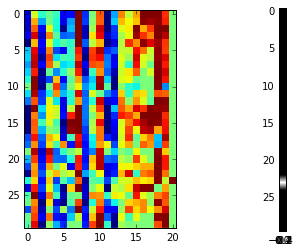

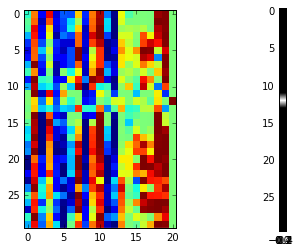

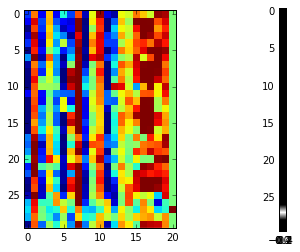

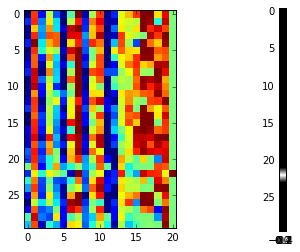

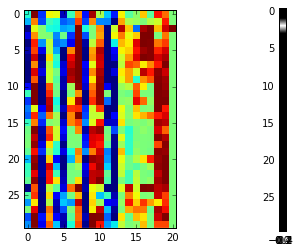

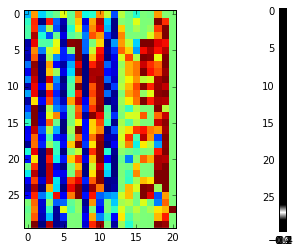

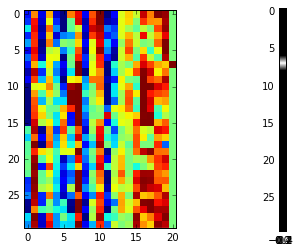

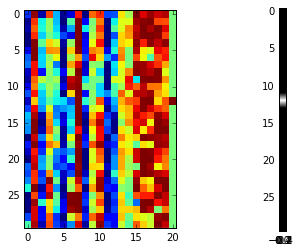

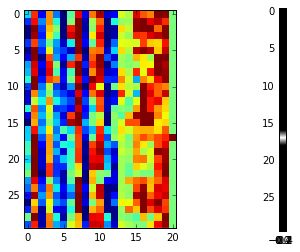

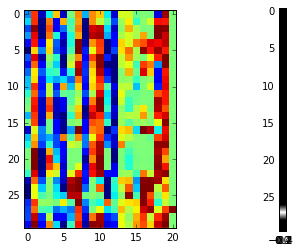

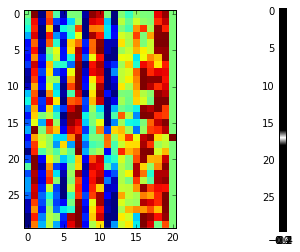

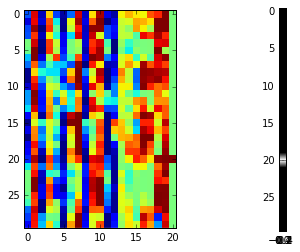

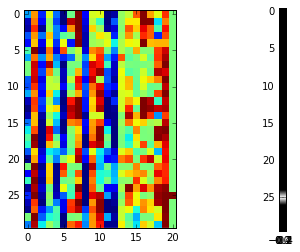

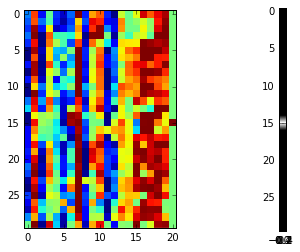

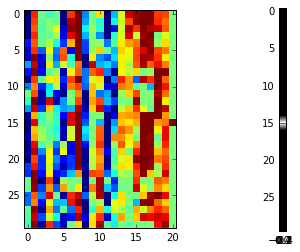

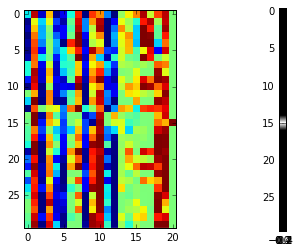

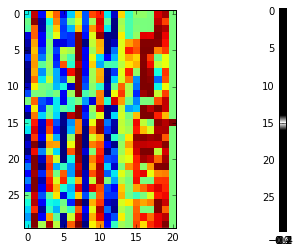

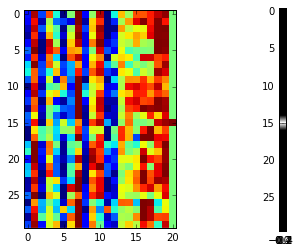

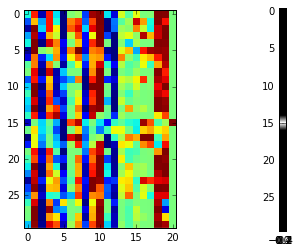

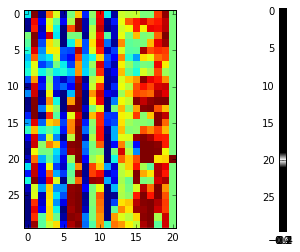

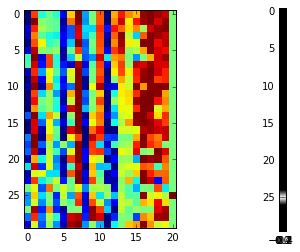

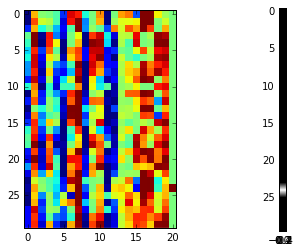

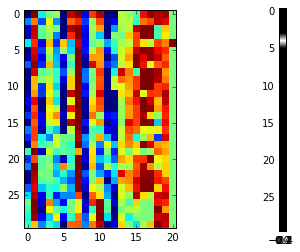

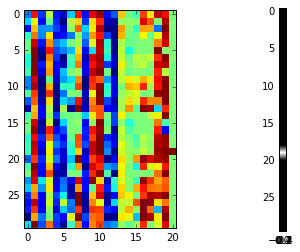

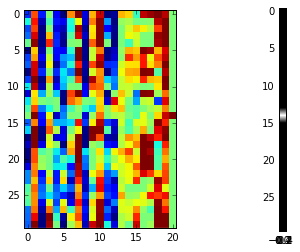

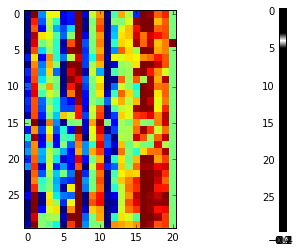

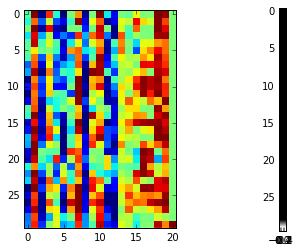

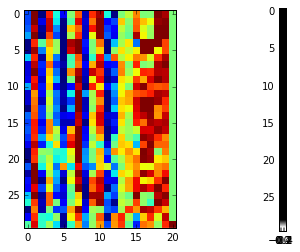

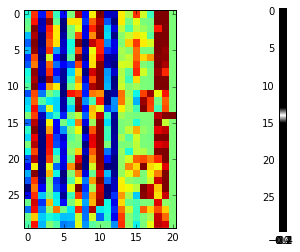

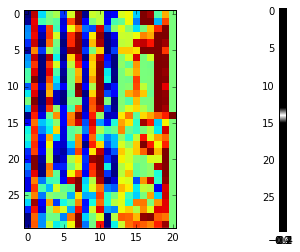

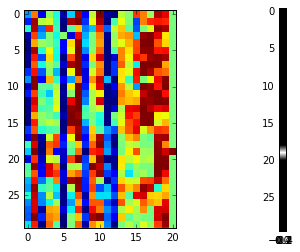

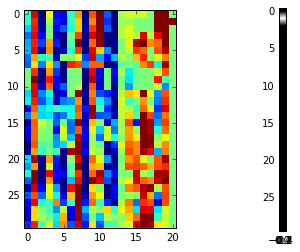

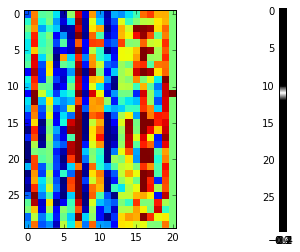

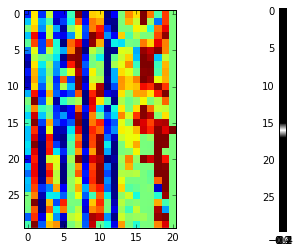

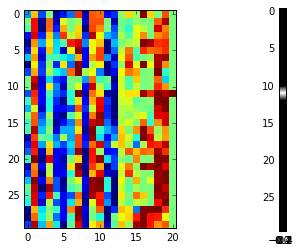

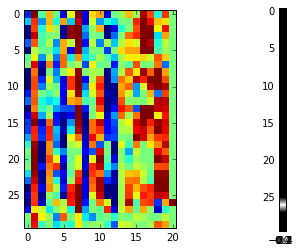

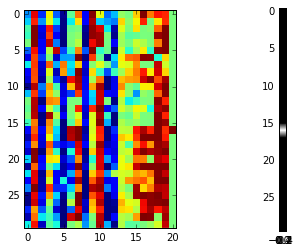

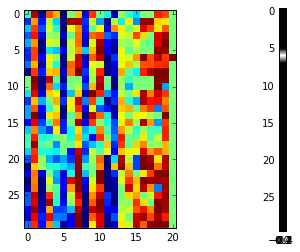

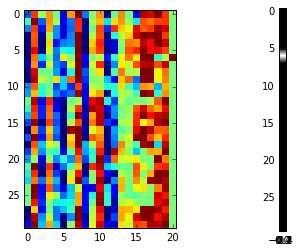

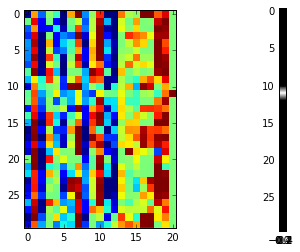

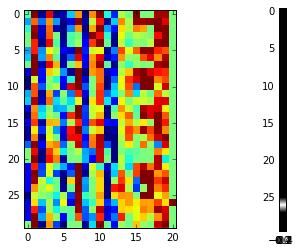

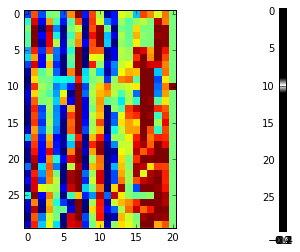

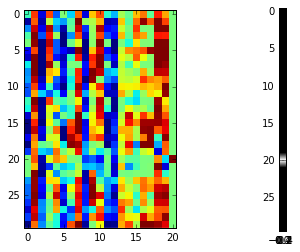

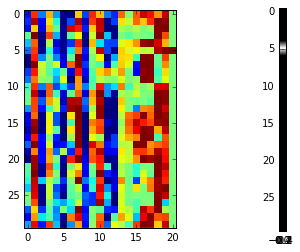

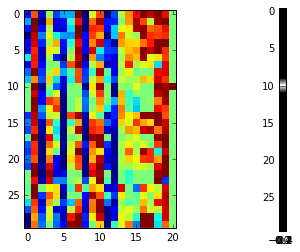

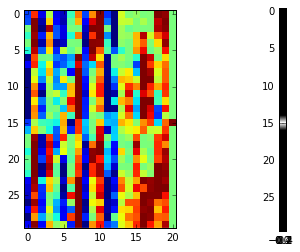

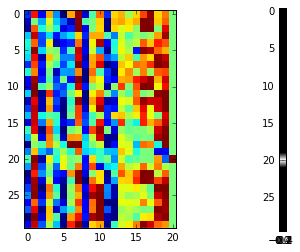

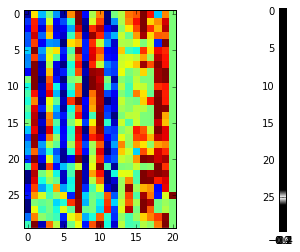

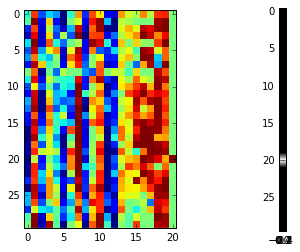

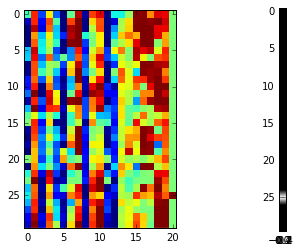

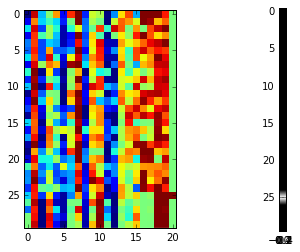

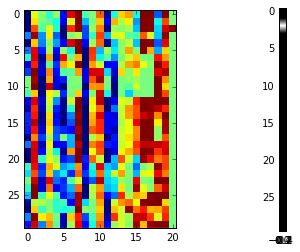

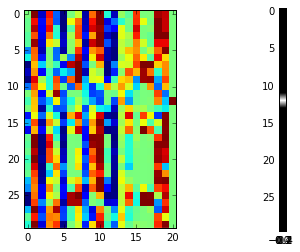

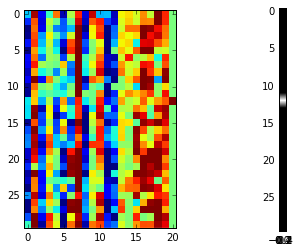

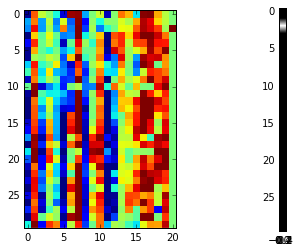

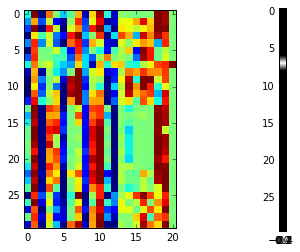

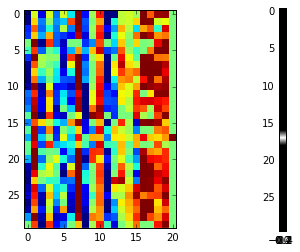

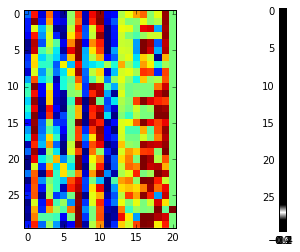

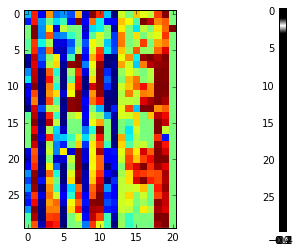

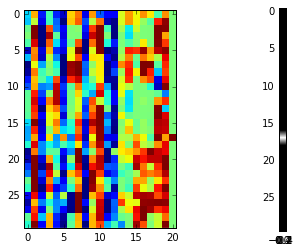

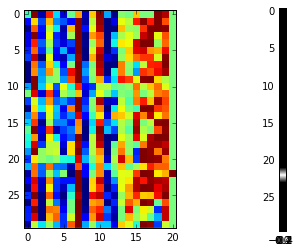

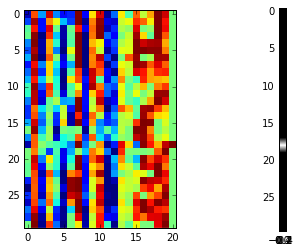

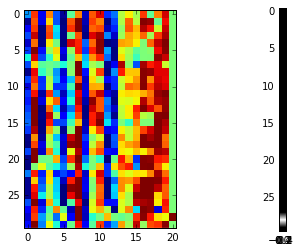

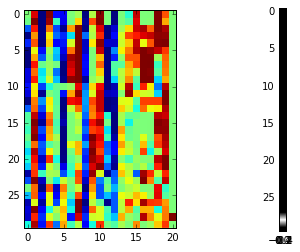

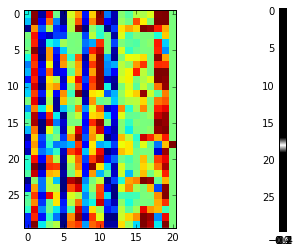

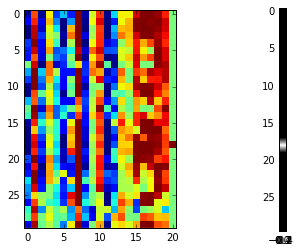

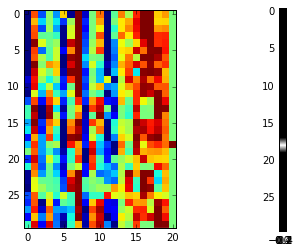

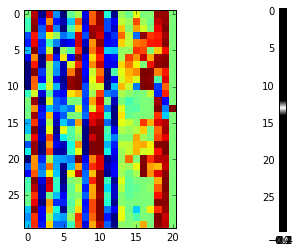

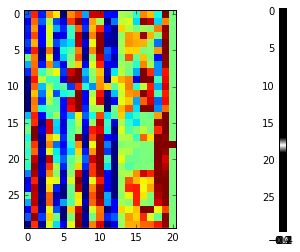

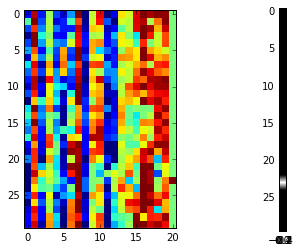

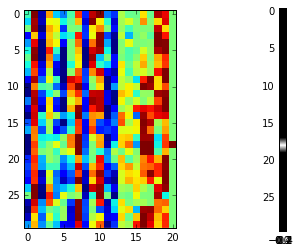

In [168]:
import matplotlib.cm as cm
for i in range(100):
    plt.subplot(1,2,1)
    plt.imshow(np.hstack([middle_layer_test_data[i*30:(i+1)*30,:], test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30]]) ,interpolation='none')
    plt.subplot(1,2,2)
#     print test_target_gcd.reshape(test_target_gcd.shape[0],1)
    plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30],cmap = cm.Greys_r)
    plt.show()
#     plt.subplot(1,2,1)
#     plt.imshow(middle_layer_test_data[30:60,:],interpolation='none')
#     plt.subplot(1,2,2)
#     plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[30:60], cmap = cm.Greys_r)
#     plt.show()
#     reshaped_middle_layer_test_data = middle_layer_test_data.reshape(30,-1)
#     reshaped_middle_layer_test_data.shape

In [152]:
9200/20

460

In [179]:
from sklearn.decomposition import PCA
from sklearn.lda import LDA

C:\Anaconda\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


(13800L, 1L)


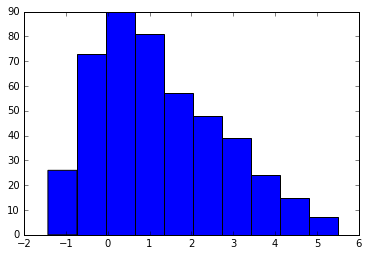

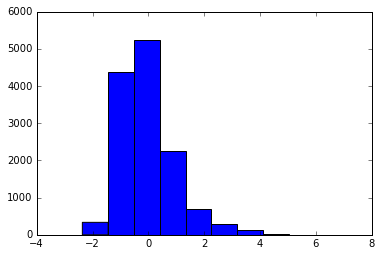

In [185]:
clf = LDA()
lda_res = clf.fit_transform(middle_layer_test_data, test_target_gcd)
print lda_res.shape
plt.hist(lda_res[test_target_gcd == 1])
plt.show()
plt.hist(lda_res[test_target_gcd == 0])
plt.show()


# pca = PCA(n_components=3)
# temp = pca.fit_transform(middle_layer_test_data)

In [176]:
temp.shape

(13800L, 3L)

AttributeError: Unknown property m

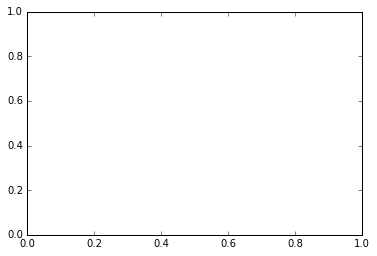

In [178]:
plt.scatter(temp[:,0], temp[:,1], temp[:,2], c=test_target_gcd)